In [1]:
# load, split and scale the maps dataset ready for training
import tensorflow as tf
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = 'maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


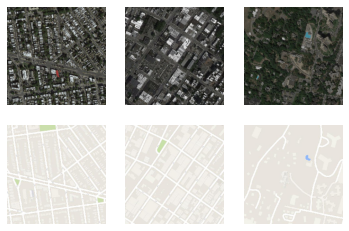

In [2]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [16]:
# example of pix2pix gan for satellite to map image-to-image translation
import tensorflow as tf
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization -khởi tạo weight theo phân phối chuẩn có phương sai là 0.02
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64 - ( C1: S=2, K=4, P=0, N_Fitler=64)
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128 -(C2: S=2, K=4, P=0, N_Filter=128)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256 -(C3: S=2, K=4, P=same, N_Filter=256)
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512 -( S=2, K=4, P=same, N_Filter=512)
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer -(Out: S=1, K=4, P=same)
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable-đóng băng discriminator (không train)
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image-Truyền source image vào generator model
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input-concatenate source input vào generator output và truyền qua discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output-source image như là input, gan model sẽ sinh ảnh và phân loại output.
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target-Lựa chọn một batch của mẫu ngẫu nhiên và trả về sources và targets
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images -Khôi phục lại ảnh gốc
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)- Gán nhãn real = 1
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets-Lựa chọn các mẫu fake và trả về sources và targets.
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance-Khởi tạo các mẫu fake từ generator
	X = g_model.predict(samples)
	# create 'fake' class labels (0)-Gán nhãn fake = 0
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images- Lựa chọn một mẫu của input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples-Tạo ra một batch của các fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images-Visualize hình ảnh của source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=30, n_batch=1):
	# determine the output square shape of the discriminator-Xác định output square shape của discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch-Tính toán số lượng các batches trên một training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations-tính toán số lần lặp lại đào tạo
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs-Huấn luyện trên từng epoch
	for i in range(n_steps):
		# select a batch of real samples-chọn một loạt các mẫu thực
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples-tạo ra một loạt các mẫu giả
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples-cập nhật bộ phân biệt cho các mẫu thực
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples-cập nhật bộ phân biệt cho các mẫu đã tạo
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator-Cập nhật generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


C:\Users\Bich Ninh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, d1[0.421] d2[0.620] g[70.407]
>2, d1[0.409] d2[0.577] g[80.535]
>3, d1[0.344] d2[0.467] g[81.666]
>4, d1[0.360] d2[0.645] g[62.247]
>5, d1[0.313] d2[0.464] g[77.628]
>6, d1[0.305] d2[0.402] g[59.879]
>7, d1[0.290] d2[0.542] g[59.784]
>8, d1[0.320] d2[0.381] g[68.923]
>9, d1[0.205] d2[0.269] g[67.077]
>10, d1[0.199] d2[0.233] g[64.617]
>11, d1[0.126] d2[0.247] g[59.284]
>12, d1[0.162] d2[0.374] g[45.533]
>13, d1[0.127] d2[0.262] g[58.592]
>14, d1[0.612] d2[0.240] g[48.353]
>15, d1[0.052] d2[0.340] g[53.854]
>16, d1[0.062] d2[0.121] g[46.602]
>17, d1[0.161] d2[0.123] g[45.808]
>18, d1[0.064] d2[0.161] g[48.408]
>19, d1[0.070] d2[0.083] g[43.194]
>20, d1[0.200] d2[0.548] g[33.539]
>21, d1[0.120] d2[0.045] g[41.375]
>22, d1[1.011] d2[0.429] g[29.340]
>23, d1[0.067] d2[0.750] g[35.480]
>24, d1[0.613] d2[0.452] g[26.042]
>25, d1[0.715] d2[0.495] g[18.923]
>26, d1[0.056] d2[0.159] g[30.224]
>27, d1[0.237] d2[0.274] g[20.629]
>28, d1[1.052] d2[1.277] g[16.243]
>29, d1[0.831] d2[0.298] g[18

>233, d1[0.192] d2[0.215] g[10.952]
>234, d1[0.008] d2[0.105] g[12.759]
>235, d1[0.781] d2[0.214] g[8.413]
>236, d1[0.099] d2[0.331] g[9.092]
>237, d1[0.005] d2[0.120] g[12.811]
>238, d1[0.010] d2[0.088] g[10.903]
>239, d1[0.020] d2[0.070] g[17.676]
>240, d1[0.040] d2[0.051] g[9.796]
>241, d1[0.866] d2[0.253] g[24.130]
>242, d1[0.568] d2[0.388] g[20.780]
>243, d1[0.631] d2[0.275] g[7.750]
>244, d1[0.155] d2[1.155] g[19.272]
>245, d1[0.752] d2[0.182] g[10.576]
>246, d1[0.609] d2[0.285] g[6.426]
>247, d1[0.119] d2[0.262] g[12.455]
>248, d1[0.076] d2[0.225] g[21.106]
>249, d1[0.144] d2[0.150] g[9.620]
>250, d1[0.030] d2[0.119] g[13.959]
>251, d1[0.277] d2[0.129] g[8.446]
>252, d1[0.277] d2[0.143] g[9.107]
>253, d1[0.012] d2[0.121] g[10.562]
>254, d1[0.187] d2[0.152] g[8.252]
>255, d1[0.016] d2[0.102] g[10.966]
>256, d1[0.037] d2[0.119] g[17.376]
>257, d1[0.009] d2[0.060] g[23.622]
>258, d1[0.053] d2[0.092] g[9.084]
>259, d1[0.013] d2[0.079] g[21.581]
>260, d1[0.008] d2[0.145] g[13.281]
>2

>463, d1[0.024] d2[0.114] g[12.715]
>464, d1[0.016] d2[0.027] g[15.595]
>465, d1[1.784] d2[0.061] g[21.254]
>466, d1[0.010] d2[0.102] g[24.440]
>467, d1[0.029] d2[0.046] g[21.645]
>468, d1[0.802] d2[0.527] g[12.191]
>469, d1[0.716] d2[0.119] g[17.349]
>470, d1[0.531] d2[0.317] g[13.731]
>471, d1[0.012] d2[0.337] g[19.337]
>472, d1[0.344] d2[0.202] g[12.609]
>473, d1[0.594] d2[0.298] g[8.921]
>474, d1[0.266] d2[0.360] g[8.313]
>475, d1[0.009] d2[0.148] g[20.317]
>476, d1[0.059] d2[0.141] g[12.575]
>477, d1[0.027] d2[0.078] g[22.766]
>478, d1[0.542] d2[0.156] g[13.094]
>479, d1[0.031] d2[0.431] g[13.402]
>480, d1[0.024] d2[0.058] g[17.099]
>481, d1[0.339] d2[0.079] g[16.673]
>482, d1[0.508] d2[0.333] g[8.403]
>483, d1[0.012] d2[0.184] g[12.387]
>484, d1[0.147] d2[0.181] g[17.532]
>485, d1[0.017] d2[0.255] g[17.213]
>486, d1[1.063] d2[0.601] g[12.922]
>487, d1[0.679] d2[0.275] g[15.397]
>488, d1[0.021] d2[0.299] g[14.504]
>489, d1[0.398] d2[0.193] g[11.442]
>490, d1[0.476] d2[0.218] g[12.

>692, d1[0.026] d2[0.103] g[10.971]
>693, d1[0.013] d2[0.034] g[15.723]
>694, d1[0.432] d2[0.174] g[10.297]
>695, d1[0.108] d2[0.450] g[16.934]
>696, d1[0.082] d2[0.097] g[9.709]
>697, d1[0.048] d2[0.038] g[11.686]
>698, d1[0.056] d2[0.097] g[12.911]
>699, d1[0.030] d2[0.065] g[13.679]
>700, d1[0.115] d2[0.321] g[10.424]
>701, d1[0.180] d2[0.068] g[12.435]
>702, d1[0.427] d2[0.232] g[9.874]
>703, d1[0.036] d2[0.134] g[17.157]
>704, d1[0.354] d2[0.817] g[12.907]
>705, d1[0.196] d2[0.206] g[14.514]
>706, d1[0.432] d2[0.411] g[11.364]
>707, d1[0.037] d2[0.039] g[17.861]
>708, d1[0.886] d2[0.371] g[10.717]
>709, d1[0.020] d2[0.053] g[12.381]
>710, d1[0.232] d2[0.167] g[9.259]
>711, d1[0.036] d2[0.041] g[22.713]
>712, d1[0.180] d2[0.094] g[11.184]
>713, d1[0.011] d2[0.155] g[23.965]
>714, d1[0.231] d2[0.076] g[16.640]
>715, d1[0.010] d2[0.228] g[12.039]
>716, d1[0.018] d2[0.163] g[17.752]
>717, d1[1.647] d2[0.052] g[9.842]
>718, d1[0.298] d2[0.149] g[10.022]
>719, d1[0.209] d2[0.169] g[10.2

>921, d1[0.030] d2[0.058] g[17.053]
>922, d1[0.949] d2[0.205] g[12.464]
>923, d1[0.081] d2[0.273] g[11.001]
>924, d1[0.020] d2[0.053] g[21.441]
>925, d1[0.536] d2[0.308] g[10.407]
>926, d1[0.541] d2[0.135] g[12.193]
>927, d1[0.045] d2[0.788] g[13.683]
>928, d1[0.658] d2[0.168] g[9.851]
>929, d1[0.100] d2[0.631] g[9.857]
>930, d1[0.052] d2[0.065] g[15.637]
>931, d1[0.928] d2[0.093] g[10.274]
>932, d1[0.549] d2[0.219] g[9.660]
>933, d1[0.051] d2[0.231] g[12.989]
>934, d1[0.050] d2[0.132] g[9.533]
>935, d1[0.429] d2[0.283] g[8.511]
>936, d1[0.017] d2[0.132] g[16.397]
>937, d1[0.343] d2[0.241] g[9.422]
>938, d1[0.016] d2[0.128] g[21.383]
>939, d1[0.142] d2[0.256] g[10.165]
>940, d1[0.304] d2[0.142] g[16.638]
>941, d1[0.118] d2[0.423] g[11.613]
>942, d1[0.341] d2[0.205] g[10.171]
>943, d1[0.108] d2[0.061] g[17.796]
>944, d1[0.012] d2[0.191] g[17.207]
>945, d1[0.082] d2[0.731] g[15.399]
>946, d1[0.007] d2[0.029] g[16.175]
>947, d1[1.593] d2[0.043] g[10.223]
>948, d1[0.554] d2[0.109] g[10.000

>1147, d1[0.041] d2[0.197] g[12.691]
>1148, d1[0.044] d2[0.126] g[8.619]
>1149, d1[0.131] d2[0.105] g[9.154]
>1150, d1[0.204] d2[0.250] g[8.228]
>1151, d1[0.001] d2[0.084] g[13.639]
>1152, d1[0.386] d2[0.285] g[8.497]
>1153, d1[0.016] d2[0.145] g[9.520]
>1154, d1[0.019] d2[0.154] g[11.232]
>1155, d1[0.002] d2[0.057] g[10.200]
>1156, d1[0.342] d2[0.194] g[9.134]
>1157, d1[0.002] d2[0.066] g[16.950]
>1158, d1[0.846] d2[0.232] g[8.118]
>1159, d1[0.058] d2[0.214] g[9.560]
>1160, d1[0.002] d2[0.067] g[17.622]
>1161, d1[0.002] d2[0.046] g[14.069]
>1162, d1[0.047] d2[0.045] g[12.137]
>1163, d1[0.001] d2[0.041] g[24.467]
>1164, d1[0.052] d2[0.061] g[15.041]
>1165, d1[0.002] d2[0.101] g[21.188]
>1166, d1[0.500] d2[1.136] g[12.615]
>1167, d1[0.003] d2[0.060] g[19.888]
>1168, d1[0.844] d2[0.114] g[12.852]
>1169, d1[0.036] d2[0.570] g[11.273]
>1170, d1[0.146] d2[0.256] g[10.450]
>1171, d1[0.486] d2[0.138] g[10.262]
>1172, d1[0.040] d2[0.218] g[10.782]
>1173, d1[0.274] d2[0.517] g[11.255]
>1174, d1

>1371, d1[0.016] d2[0.212] g[8.911]
>1372, d1[0.001] d2[0.116] g[11.012]
>1373, d1[0.047] d2[0.062] g[17.428]
>1374, d1[0.023] d2[0.123] g[10.334]
>1375, d1[0.407] d2[0.092] g[8.886]
>1376, d1[0.119] d2[0.511] g[10.532]
>1377, d1[0.060] d2[0.027] g[13.854]
>1378, d1[0.609] d2[0.081] g[10.448]
>1379, d1[0.272] d2[0.482] g[13.127]
>1380, d1[0.582] d2[0.200] g[8.685]
>1381, d1[0.002] d2[0.131] g[21.272]
>1382, d1[0.072] d2[0.325] g[9.460]
>1383, d1[0.085] d2[0.096] g[11.961]
>1384, d1[0.494] d2[0.230] g[9.962]
>1385, d1[0.001] d2[0.206] g[31.430]
>1386, d1[0.582] d2[0.552] g[8.329]
>1387, d1[0.141] d2[0.070] g[15.143]
>1388, d1[1.148] d2[0.129] g[9.261]
>1389, d1[0.009] d2[0.112] g[20.446]
>1390, d1[0.312] d2[0.244] g[9.952]
>1391, d1[0.212] d2[0.191] g[8.476]
>1392, d1[0.030] d2[0.223] g[9.357]
>1393, d1[0.213] d2[0.534] g[9.398]
>1394, d1[0.010] d2[0.093] g[20.927]
>1395, d1[0.806] d2[0.147] g[8.979]
>1396, d1[0.129] d2[0.469] g[9.696]
>1397, d1[0.001] d2[0.061] g[13.176]
>1398, d1[1.03

>1595, d1[0.052] d2[0.031] g[11.712]
>1596, d1[0.744] d2[0.144] g[7.607]
>1597, d1[0.340] d2[0.467] g[9.223]
>1598, d1[0.001] d2[0.070] g[13.180]
>1599, d1[0.032] d2[0.125] g[10.421]
>1600, d1[0.390] d2[0.239] g[7.605]
>1601, d1[0.276] d2[0.130] g[9.436]
>1602, d1[0.001] d2[0.132] g[13.630]
>1603, d1[0.004] d2[0.126] g[10.738]
>1604, d1[0.124] d2[0.062] g[9.912]
>1605, d1[0.016] d2[0.093] g[10.129]
>1606, d1[0.142] d2[0.455] g[8.599]
>1607, d1[0.009] d2[0.034] g[18.024]
>1608, d1[1.552] d2[0.122] g[7.082]
>1609, d1[0.011] d2[0.076] g[11.412]
>1610, d1[0.352] d2[0.179] g[9.204]
>1611, d1[0.217] d2[0.208] g[10.310]
>1612, d1[0.130] d2[0.370] g[8.896]
>1613, d1[0.004] d2[0.050] g[16.667]
>1614, d1[0.002] d2[0.052] g[12.015]
>1615, d1[0.120] d2[0.044] g[13.596]
>1616, d1[0.108] d2[0.127] g[13.695]
>1617, d1[0.030] d2[0.077] g[9.460]
>1618, d1[0.001] d2[0.071] g[17.181]
>1619, d1[0.270] d2[0.125] g[8.785]
>1620, d1[0.002] d2[0.091] g[15.125]
>1621, d1[0.023] d2[0.180] g[9.504]
>1622, d1[0.0

>1819, d1[0.006] d2[0.032] g[24.774]
>1820, d1[0.186] d2[0.146] g[9.257]
>1821, d1[0.136] d2[0.566] g[13.076]
>1822, d1[0.036] d2[0.035] g[10.172]
>1823, d1[0.166] d2[0.034] g[19.871]
>1824, d1[0.448] d2[0.079] g[16.258]
>1825, d1[0.018] d2[0.275] g[13.360]
>1826, d1[0.291] d2[0.322] g[13.544]
>1827, d1[0.078] d2[0.034] g[18.355]
>1828, d1[0.722] d2[0.142] g[9.882]
>1829, d1[0.070] d2[0.085] g[9.740]
>1830, d1[0.002] d2[0.080] g[15.502]
>1831, d1[0.015] d2[0.248] g[9.458]
>1832, d1[0.012] d2[0.120] g[7.135]
>1833, d1[0.891] d2[0.128] g[7.555]
>1834, d1[0.001] d2[0.138] g[13.012]
>1835, d1[0.170] d2[0.170] g[9.423]
>1836, d1[0.009] d2[0.177] g[10.867]
>1837, d1[0.233] d2[0.250] g[12.182]
>1838, d1[0.104] d2[0.144] g[9.173]
>1839, d1[0.008] d2[0.041] g[16.083]
>1840, d1[0.181] d2[0.337] g[8.514]
>1841, d1[0.070] d2[0.068] g[9.070]
>1842, d1[0.482] d2[0.164] g[8.413]
>1843, d1[0.020] d2[0.179] g[8.586]
>1844, d1[0.036] d2[0.119] g[8.893]
>1845, d1[0.002] d2[0.043] g[14.495]
>1846, d1[0.05

>2043, d1[0.504] d2[0.079] g[10.502]
>2044, d1[0.004] d2[0.364] g[11.841]
>2045, d1[0.002] d2[0.046] g[15.069]
>2046, d1[0.937] d2[0.097] g[9.075]
>2047, d1[0.263] d2[0.645] g[8.617]
>2048, d1[0.001] d2[0.054] g[14.853]
>2049, d1[0.004] d2[0.048] g[15.217]
>2050, d1[0.609] d2[0.170] g[10.434]
>2051, d1[0.014] d2[0.074] g[9.855]
>2052, d1[0.166] d2[0.270] g[7.190]
>2053, d1[0.192] d2[0.159] g[8.074]
>2054, d1[0.021] d2[0.059] g[23.417]
>2055, d1[0.001] d2[0.165] g[13.321]
>2056, d1[0.228] d2[0.360] g[8.997]
>2057, d1[0.016] d2[0.046] g[8.949]
>2058, d1[0.194] d2[0.117] g[11.220]
>2059, d1[0.284] d2[0.250] g[8.659]
>2060, d1[0.063] d2[0.336] g[9.411]
>2061, d1[0.113] d2[0.077] g[10.953]
>2062, d1[0.063] d2[0.103] g[10.640]
>2063, d1[0.950] d2[0.170] g[8.689]
>2064, d1[0.001] d2[0.068] g[15.015]
>2065, d1[0.052] d2[0.128] g[8.191]
>2066, d1[0.001] d2[0.063] g[12.079]
>2067, d1[0.036] d2[0.075] g[10.918]
>2068, d1[0.064] d2[0.128] g[10.015]
>2069, d1[0.037] d2[0.274] g[9.688]
>2070, d1[0.0

>2267, d1[0.238] d2[0.231] g[9.672]
>2268, d1[0.005] d2[0.347] g[9.290]
>2269, d1[0.072] d2[0.088] g[9.866]
>2270, d1[0.003] d2[0.064] g[18.485]
>2271, d1[0.004] d2[0.082] g[22.964]
>2272, d1[0.074] d2[0.081] g[14.393]
>2273, d1[0.330] d2[0.914] g[12.756]
>2274, d1[0.002] d2[0.060] g[13.895]
>2275, d1[0.023] d2[0.030] g[17.537]
>2276, d1[0.009] d2[0.032] g[22.628]
>2277, d1[0.097] d2[0.056] g[10.056]
>2278, d1[0.468] d2[0.122] g[7.960]
>2279, d1[0.547] d2[0.675] g[12.478]
>2280, d1[0.127] d2[0.120] g[9.150]
>2281, d1[0.002] d2[0.128] g[13.251]
>2282, d1[0.259] d2[0.170] g[9.181]
>2283, d1[0.144] d2[0.118] g[9.990]
>2284, d1[0.006] d2[0.149] g[14.150]
>2285, d1[0.005] d2[0.113] g[9.828]
>2286, d1[1.109] d2[0.122] g[7.979]
>2287, d1[0.210] d2[0.366] g[8.584]
>2288, d1[0.002] d2[0.136] g[13.621]
>2289, d1[0.584] d2[0.131] g[9.563]
>2290, d1[0.030] d2[0.315] g[10.749]
>2291, d1[0.006] d2[0.107] g[12.911]
>2292, d1[0.003] d2[0.065] g[13.250]
>2293, d1[0.142] d2[0.235] g[6.811]
>2294, d1[0.0

>2492, d1[1.148] d2[0.190] g[8.548]
>2493, d1[0.012] d2[0.382] g[14.027]
>2494, d1[0.560] d2[0.375] g[9.162]
>2495, d1[0.058] d2[0.074] g[13.641]
>2496, d1[0.009] d2[0.070] g[13.613]
>2497, d1[0.756] d2[0.547] g[9.218]
>2498, d1[0.006] d2[0.045] g[12.339]
>2499, d1[0.940] d2[0.327] g[8.238]
>2500, d1[0.508] d2[0.098] g[8.222]
>2501, d1[0.004] d2[0.129] g[24.692]
>2502, d1[0.006] d2[0.051] g[15.194]
>2503, d1[0.066] d2[0.140] g[10.373]
>2504, d1[0.011] d2[0.071] g[15.187]
>2505, d1[0.073] d2[0.091] g[12.232]
>2506, d1[0.167] d2[0.311] g[7.564]
>2507, d1[0.038] d2[0.050] g[11.894]
>2508, d1[0.005] d2[0.037] g[11.635]
>2509, d1[0.213] d2[0.106] g[13.433]
>2510, d1[0.347] d2[1.532] g[7.420]
>2511, d1[0.378] d2[0.182] g[7.132]
>2512, d1[0.325] d2[0.263] g[10.691]
>2513, d1[0.161] d2[0.336] g[6.330]
>2514, d1[0.138] d2[0.099] g[9.992]
>2515, d1[0.465] d2[0.296] g[8.536]
>2516, d1[0.292] d2[0.176] g[8.946]
>2517, d1[0.021] d2[0.115] g[8.229]
>2518, d1[0.208] d2[0.177] g[9.314]
>2519, d1[0.072

>2717, d1[0.094] d2[0.558] g[10.298]
>2718, d1[0.336] d2[0.171] g[7.967]
>2719, d1[0.097] d2[0.203] g[8.115]
>2720, d1[0.461] d2[0.217] g[14.094]
>2721, d1[0.004] d2[0.179] g[11.766]
>2722, d1[0.138] d2[0.152] g[10.309]
>2723, d1[0.004] d2[0.097] g[14.723]
>2724, d1[0.006] d2[0.078] g[12.194]
>2725, d1[0.005] d2[0.051] g[21.539]
>2726, d1[0.916] d2[0.139] g[8.411]
>2727, d1[0.028] d2[0.111] g[12.011]
>2728, d1[0.104] d2[0.283] g[7.919]
>2729, d1[0.087] d2[0.088] g[9.908]
>2730, d1[0.003] d2[0.082] g[13.930]
>2731, d1[0.004] d2[0.086] g[13.601]
>2732, d1[0.121] d2[0.062] g[8.635]
>2733, d1[0.094] d2[0.068] g[14.172]
>2734, d1[0.028] d2[0.072] g[9.662]
>2735, d1[0.032] d2[0.118] g[9.173]
>2736, d1[0.022] d2[0.072] g[16.285]
>2737, d1[0.267] d2[0.536] g[10.529]
>2738, d1[0.080] d2[0.301] g[8.989]
>2739, d1[0.972] d2[0.058] g[8.492]
>2740, d1[0.074] d2[0.076] g[14.614]
>2741, d1[0.428] d2[0.318] g[7.879]
>2742, d1[0.011] d2[0.099] g[12.603]
>2743, d1[0.005] d2[0.080] g[24.899]
>2744, d1[0.

>2942, d1[0.428] d2[0.186] g[7.955]
>2943, d1[0.008] d2[0.100] g[15.345]
>2944, d1[0.004] d2[0.147] g[11.374]
>2945, d1[0.384] d2[0.100] g[15.527]
>2946, d1[0.005] d2[0.107] g[12.793]
>2947, d1[0.054] d2[0.149] g[8.609]
>2948, d1[0.238] d2[0.316] g[9.767]
>2949, d1[0.113] d2[0.169] g[6.716]
>2950, d1[0.014] d2[0.069] g[5.800]
>2951, d1[0.036] d2[0.045] g[10.623]
>2952, d1[0.169] d2[0.059] g[10.112]
>2953, d1[0.004] d2[0.208] g[12.507]
>2954, d1[0.021] d2[0.065] g[6.349]
>2955, d1[0.026] d2[0.077] g[5.622]
>2956, d1[0.991] d2[0.067] g[9.649]
>2957, d1[0.013] d2[0.109] g[11.166]
>2958, d1[0.216] d2[0.137] g[9.882]
>2959, d1[0.003] d2[0.086] g[11.682]
>2960, d1[0.004] d2[0.080] g[14.168]
>2961, d1[0.403] d2[0.065] g[9.724]
>2962, d1[0.004] d2[0.206] g[11.880]
>2963, d1[0.160] d2[0.316] g[8.567]
>2964, d1[0.013] d2[0.051] g[11.044]
>2965, d1[0.313] d2[0.272] g[9.183]
>2966, d1[0.036] d2[0.120] g[8.156]
>2967, d1[0.008] d2[0.058] g[18.803]
>2968, d1[0.020] d2[0.115] g[9.619]
>2969, d1[0.006

>3167, d1[0.621] d2[0.199] g[9.748]
>3168, d1[0.011] d2[0.122] g[14.245]
>3169, d1[0.009] d2[0.069] g[15.063]
>3170, d1[0.043] d2[0.525] g[7.786]
>3171, d1[0.617] d2[0.058] g[9.767]
>3172, d1[0.007] d2[0.099] g[12.453]
>3173, d1[0.101] d2[0.083] g[9.899]
>3174, d1[0.151] d2[0.543] g[9.230]
>3175, d1[0.008] d2[0.046] g[11.299]
>3176, d1[0.012] d2[0.031] g[14.862]
>3177, d1[0.682] d2[0.238] g[6.674]
>3178, d1[0.013] d2[0.053] g[24.862]
>3179, d1[0.595] d2[0.365] g[7.794]
>3180, d1[0.220] d2[0.234] g[8.709]
>3181, d1[0.248] d2[0.143] g[10.537]
>3182, d1[0.182] d2[0.230] g[7.439]
>3183, d1[0.526] d2[0.180] g[10.175]
>3184, d1[0.095] d2[0.480] g[7.635]
>3185, d1[0.007] d2[0.096] g[11.184]
>3186, d1[0.403] d2[0.220] g[7.883]
>3187, d1[0.066] d2[0.109] g[8.090]
>3188, d1[0.005] d2[0.120] g[15.964]
>3189, d1[0.072] d2[0.091] g[8.407]
>3190, d1[0.008] d2[0.050] g[21.129]
>3191, d1[0.008] d2[0.056] g[14.979]
>3192, d1[0.127] d2[0.062] g[10.701]
>3193, d1[0.005] d2[0.054] g[13.122]
>3194, d1[0.00

>3392, d1[0.371] d2[0.250] g[15.869]
>3393, d1[0.045] d2[0.366] g[14.418]
>3394, d1[0.201] d2[0.213] g[11.229]
>3395, d1[0.144] d2[0.180] g[13.218]
>3396, d1[0.093] d2[0.095] g[16.410]
>3397, d1[0.013] d2[0.112] g[14.925]
>3398, d1[0.010] d2[0.045] g[13.318]
>3399, d1[0.220] d2[0.067] g[13.044]
>3400, d1[0.172] d2[0.124] g[8.231]
>3401, d1[0.048] d2[0.079] g[9.490]
>3402, d1[0.006] d2[0.261] g[14.033]
>3403, d1[0.009] d2[0.038] g[13.977]
>3404, d1[0.396] d2[0.120] g[8.917]
>3405, d1[0.008] d2[0.119] g[9.940]
>3406, d1[0.062] d2[0.154] g[9.733]
>3407, d1[0.013] d2[0.141] g[12.496]
>3408, d1[0.632] d2[0.103] g[7.527]
>3409, d1[0.170] d2[0.528] g[10.965]
>3410, d1[0.128] d2[0.084] g[8.419]
>3411, d1[0.009] d2[0.055] g[15.829]
>3412, d1[0.019] d2[0.058] g[10.100]
>3413, d1[0.482] d2[0.226] g[7.598]
>3414, d1[0.008] d2[0.080] g[9.350]
>3415, d1[0.010] d2[0.046] g[14.278]
>3416, d1[0.416] d2[0.129] g[9.268]
>3417, d1[0.006] d2[0.188] g[12.819]
>3418, d1[0.155] d2[0.160] g[8.385]
>3419, d1[0.

>3617, d1[0.006] d2[0.046] g[25.602]
>3618, d1[0.623] d2[0.192] g[8.194]
>3619, d1[0.004] d2[0.118] g[15.718]
>3620, d1[0.073] d2[0.124] g[10.226]
>3621, d1[0.027] d2[0.177] g[10.032]
>3622, d1[0.044] d2[0.060] g[9.246]
>3623, d1[0.134] d2[0.075] g[9.386]
>3624, d1[0.092] d2[0.135] g[8.560]
>3625, d1[0.010] d2[0.031] g[6.375]
>3626, d1[0.007] d2[0.043] g[12.178]
>3627, d1[0.745] d2[0.155] g[7.547]
>3628, d1[0.394] d2[0.642] g[8.339]
>3629, d1[0.402] d2[0.198] g[11.127]
>3630, d1[0.076] d2[0.219] g[8.605]
>3631, d1[0.373] d2[0.239] g[7.845]
>3632, d1[0.007] d2[0.216] g[12.770]
>3633, d1[0.010] d2[0.114] g[6.006]
>3634, d1[0.490] d2[1.062] g[7.362]
>3635, d1[0.358] d2[0.143] g[8.585]
>3636, d1[0.013] d2[0.100] g[19.573]
>3637, d1[0.193] d2[0.217] g[10.018]
>3638, d1[0.065] d2[0.136] g[9.028]
>3639, d1[0.313] d2[0.255] g[8.780]
>3640, d1[0.015] d2[0.098] g[9.014]
>3641, d1[0.390] d2[0.221] g[10.437]
>3642, d1[0.181] d2[0.138] g[9.372]
>3643, d1[0.069] d2[0.193] g[9.262]
>3644, d1[0.008] d

>3842, d1[0.004] d2[0.328] g[14.257]
>3843, d1[0.140] d2[0.095] g[7.825]
>3844, d1[0.006] d2[0.049] g[13.529]
>3845, d1[0.007] d2[0.036] g[13.771]
>3846, d1[0.117] d2[0.068] g[8.465]
>3847, d1[0.125] d2[0.171] g[8.364]
>3848, d1[0.006] d2[0.103] g[9.855]
>3849, d1[0.008] d2[0.049] g[11.673]
>3850, d1[0.008] d2[0.050] g[13.227]
>3851, d1[0.150] d2[0.060] g[10.393]
>3852, d1[0.009] d2[0.036] g[14.831]
>3853, d1[0.042] d2[0.228] g[6.836]
>3854, d1[0.008] d2[0.037] g[13.786]
>3855, d1[0.919] d2[0.112] g[19.422]
>3856, d1[0.084] d2[0.452] g[10.986]
>3857, d1[0.034] d2[0.051] g[6.003]
>3858, d1[0.773] d2[0.090] g[8.494]
>3859, d1[0.080] d2[0.113] g[13.112]
>3860, d1[0.053] d2[0.250] g[8.264]
>3861, d1[0.007] d2[0.072] g[13.011]
>3862, d1[0.144] d2[0.140] g[7.968]
>3863, d1[0.006] d2[0.096] g[9.656]
>3864, d1[0.243] d2[0.087] g[8.661]
>3865, d1[0.041] d2[0.294] g[8.359]
>3866, d1[0.019] d2[0.040] g[5.865]
>3867, d1[0.945] d2[0.118] g[7.732]
>3868, d1[0.103] d2[0.156] g[8.831]
>3869, d1[0.023]

>4067, d1[0.248] d2[0.443] g[7.581]
>4068, d1[0.168] d2[0.041] g[12.129]
>4069, d1[0.370] d2[0.093] g[8.663]
>4070, d1[0.045] d2[0.123] g[14.511]
>4071, d1[0.009] d2[0.099] g[24.198]
>4072, d1[0.016] d2[0.618] g[10.397]
>4073, d1[1.068] d2[0.029] g[9.485]
>4074, d1[0.188] d2[0.069] g[9.026]
>4075, d1[0.454] d2[0.411] g[8.590]
>4076, d1[0.056] d2[0.152] g[8.064]
>4077, d1[0.060] d2[0.066] g[8.325]
>4078, d1[0.118] d2[0.078] g[10.408]
>4079, d1[0.007] d2[0.069] g[15.680]
>4080, d1[0.008] d2[0.091] g[17.356]
>4081, d1[0.009] d2[0.062] g[15.431]
>4082, d1[0.007] d2[0.134] g[13.392]
>4083, d1[0.012] d2[0.033] g[13.155]
>4084, d1[0.615] d2[0.102] g[8.121]
>4085, d1[0.021] d2[0.121] g[13.802]
>4086, d1[0.007] d2[0.061] g[13.093]
>4087, d1[0.058] d2[0.120] g[8.573]
>4088, d1[0.017] d2[0.062] g[20.274]
>4089, d1[0.131] d2[0.054] g[12.130]
>4090, d1[0.109] d2[0.145] g[11.922]
>4091, d1[0.074] d2[0.119] g[9.388]
>4092, d1[1.062] d2[0.237] g[13.684]
>4093, d1[0.020] d2[0.152] g[12.029]
>4094, d1[0

>4292, d1[0.010] d2[0.046] g[19.399]
>4293, d1[0.013] d2[0.036] g[16.430]
>4294, d1[0.014] d2[0.029] g[17.517]
>4295, d1[0.581] d2[0.112] g[6.549]
>4296, d1[0.008] d2[0.143] g[18.129]
>4297, d1[0.092] d2[0.079] g[8.619]
>4298, d1[0.046] d2[0.263] g[9.936]
>4299, d1[0.130] d2[0.046] g[9.539]
>4300, d1[0.011] d2[0.060] g[12.116]
>4301, d1[0.028] d2[0.055] g[9.209]
>4302, d1[0.117] d2[0.200] g[10.057]
>4303, d1[0.011] d2[0.042] g[21.388]
>4304, d1[0.217] d2[0.152] g[7.712]
>4305, d1[0.009] d2[0.098] g[14.694]
>4306, d1[0.009] d2[0.063] g[28.267]
>4307, d1[0.290] d2[0.349] g[14.172]
>4308, d1[0.181] d2[0.072] g[9.230]
>4309, d1[0.035] d2[0.113] g[10.380]
>4310, d1[0.015] d2[0.041] g[11.339]
>4311, d1[0.010] d2[0.060] g[5.582]
>4312, d1[0.154] d2[0.084] g[9.054]
>4313, d1[0.007] d2[0.406] g[11.013]
>4314, d1[0.318] d2[0.078] g[7.851]
>4315, d1[0.017] d2[0.033] g[19.624]
>4316, d1[0.021] d2[0.029] g[16.776]
>4317, d1[0.448] d2[0.183] g[8.995]
>4318, d1[0.018] d2[0.173] g[9.565]
>4319, d1[0.0

>4517, d1[0.046] d2[0.138] g[16.264]
>4518, d1[0.603] d2[0.180] g[6.097]
>4519, d1[0.006] d2[0.340] g[19.310]
>4520, d1[0.012] d2[0.064] g[20.100]
>4521, d1[0.014] d2[0.044] g[13.076]
>4522, d1[0.013] d2[0.042] g[11.081]
>4523, d1[0.175] d2[0.056] g[10.396]
>4524, d1[0.154] d2[0.198] g[8.174]
>4525, d1[0.008] d2[0.464] g[10.017]
>4526, d1[0.218] d2[0.052] g[6.591]
>4527, d1[0.123] d2[0.096] g[13.485]
>4528, d1[0.793] d2[0.171] g[8.616]
>4529, d1[0.150] d2[0.624] g[6.610]
>4530, d1[0.302] d2[0.110] g[6.956]
>4531, d1[0.212] d2[0.185] g[8.141]
>4532, d1[0.011] d2[0.101] g[19.055]
>4533, d1[0.556] d2[0.188] g[15.634]
>4534, d1[0.006] d2[0.274] g[15.723]
>4535, d1[0.045] d2[0.206] g[8.681]
>4536, d1[0.361] d2[0.133] g[9.981]
>4537, d1[0.032] d2[0.156] g[9.941]
>4538, d1[0.178] d2[0.189] g[7.638]
>4539, d1[0.151] d2[0.149] g[8.828]
>4540, d1[0.054] d2[0.061] g[13.014]
>4541, d1[0.132] d2[0.246] g[9.037]
>4542, d1[0.053] d2[0.096] g[9.484]
>4543, d1[0.055] d2[0.042] g[10.842]
>4544, d1[0.385

>4742, d1[0.010] d2[0.161] g[5.364]
>4743, d1[0.199] d2[0.086] g[7.930]
>4744, d1[0.903] d2[0.108] g[12.460]
>4745, d1[0.035] d2[0.194] g[13.687]
>4746, d1[0.020] d2[0.120] g[9.850]
>4747, d1[0.007] d2[0.078] g[11.445]
>4748, d1[0.477] d2[0.200] g[8.218]
>4749, d1[0.066] d2[0.059] g[7.271]
>4750, d1[0.061] d2[0.319] g[9.153]
>4751, d1[0.418] d2[0.498] g[9.139]
>4752, d1[0.084] d2[0.054] g[8.334]
>4753, d1[0.324] d2[0.088] g[9.254]
>4754, d1[0.012] d2[0.140] g[6.210]
>4755, d1[0.015] d2[0.197] g[5.140]
>4756, d1[0.062] d2[0.089] g[9.298]
>4757, d1[0.104] d2[0.059] g[14.686]
>4758, d1[0.008] d2[0.128] g[16.184]
>4759, d1[0.097] d2[0.085] g[8.521]
>4760, d1[0.136] d2[0.065] g[12.656]
>4761, d1[0.036] d2[0.210] g[10.371]
>4762, d1[0.036] d2[0.054] g[9.374]
>4763, d1[0.010] d2[0.043] g[14.109]
>4764, d1[0.330] d2[0.146] g[7.279]
>4765, d1[0.026] d2[0.244] g[8.860]
>4766, d1[0.008] d2[0.054] g[12.995]
>4767, d1[0.010] d2[0.054] g[17.463]
>4768, d1[0.962] d2[0.092] g[7.385]
>4769, d1[0.005] d

>4967, d1[0.017] d2[0.124] g[15.135]
>4968, d1[0.021] d2[0.047] g[15.285]
>4969, d1[0.093] d2[0.063] g[8.676]
>4970, d1[0.015] d2[0.087] g[10.161]
>4971, d1[0.331] d2[0.197] g[7.660]
>4972, d1[0.125] d2[0.106] g[10.076]
>4973, d1[0.036] d2[0.144] g[11.916]
>4974, d1[0.034] d2[0.039] g[17.114]
>4975, d1[0.311] d2[0.162] g[8.854]
>4976, d1[0.052] d2[0.061] g[5.843]
>4977, d1[0.011] d2[0.128] g[10.550]
>4978, d1[0.139] d2[0.078] g[8.431]
>4979, d1[0.018] d2[0.048] g[15.688]
>4980, d1[0.010] d2[0.051] g[12.784]
>4981, d1[0.045] d2[0.081] g[12.978]
>4982, d1[0.386] d2[0.210] g[8.836]
>4983, d1[0.020] d2[0.075] g[11.238]
>4984, d1[0.191] d2[0.246] g[8.999]
>4985, d1[0.087] d2[0.114] g[10.008]
>4986, d1[0.044] d2[0.045] g[13.238]
>4987, d1[0.277] d2[0.058] g[14.270]
>4988, d1[0.025] d2[0.373] g[8.532]
>4989, d1[0.007] d2[0.039] g[13.978]
>4990, d1[0.010] d2[0.039] g[13.171]
>4991, d1[1.020] d2[0.066] g[8.659]
>4992, d1[0.015] d2[0.262] g[15.197]
>4993, d1[0.006] d2[0.117] g[11.575]
>4994, d1[

>5192, d1[0.006] d2[0.067] g[10.340]
>5193, d1[0.015] d2[0.039] g[10.698]
>5194, d1[0.233] d2[0.225] g[7.924]
>5195, d1[0.006] d2[0.042] g[16.612]
>5196, d1[0.059] d2[0.064] g[8.743]
>5197, d1[0.011] d2[0.042] g[10.520]
>5198, d1[0.086] d2[0.100] g[9.467]
>5199, d1[0.016] d2[0.037] g[17.005]
>5200, d1[0.023] d2[0.078] g[13.101]
>5201, d1[0.006] d2[0.068] g[17.982]
>5202, d1[0.078] d2[0.073] g[8.762]
>5203, d1[0.141] d2[0.125] g[8.880]
>5204, d1[0.006] d2[0.079] g[12.612]
>5205, d1[0.086] d2[0.050] g[7.971]
>5206, d1[0.008] d2[0.031] g[5.464]
>5207, d1[0.007] d2[0.041] g[18.875]
>5208, d1[0.027] d2[0.061] g[9.164]
>5209, d1[0.025] d2[0.074] g[9.167]
>5210, d1[0.780] d2[0.225] g[10.741]
>5211, d1[0.016] d2[0.174] g[14.860]
>5212, d1[0.055] d2[0.084] g[15.051]
>5213, d1[0.006] d2[0.102] g[12.833]
>5214, d1[0.007] d2[0.052] g[14.600]
>5215, d1[0.044] d2[0.054] g[11.828]
>5216, d1[0.127] d2[0.108] g[12.141]
>5217, d1[0.021] d2[0.036] g[22.187]
>5218, d1[0.007] d2[0.051] g[10.396]
>5219, d1[

>5417, d1[0.015] d2[0.035] g[7.609]
>5418, d1[0.045] d2[0.038] g[11.416]
>5419, d1[0.005] d2[0.042] g[13.233]
>5420, d1[0.115] d2[0.153] g[8.549]
>5421, d1[0.016] d2[0.056] g[11.311]
>5422, d1[0.094] d2[0.082] g[7.847]
>5423, d1[0.127] d2[0.133] g[8.974]
>5424, d1[0.029] d2[0.035] g[13.063]
>5425, d1[0.032] d2[0.038] g[10.315]
>5426, d1[0.011] d2[0.059] g[17.277]
>5427, d1[0.004] d2[0.045] g[14.312]
>5428, d1[0.081] d2[0.068] g[10.802]
>5429, d1[0.005] d2[0.070] g[15.331]
>5430, d1[0.060] d2[0.140] g[8.380]
>5431, d1[0.058] d2[0.305] g[7.697]
>5432, d1[0.008] d2[0.037] g[15.746]
>5433, d1[1.154] d2[0.234] g[9.908]
>5434, d1[0.008] d2[0.078] g[16.518]
>5435, d1[0.377] d2[0.086] g[9.854]
>5436, d1[0.062] d2[0.282] g[12.386]
>5437, d1[0.067] d2[0.152] g[9.736]
>5438, d1[0.033] d2[0.144] g[6.062]
>5439, d1[0.126] d2[0.163] g[10.967]
>5440, d1[0.028] d2[0.068] g[9.298]
>5441, d1[0.008] d2[0.065] g[5.245]
>5442, d1[0.090] d2[0.046] g[12.559]
>5443, d1[0.045] d2[0.057] g[10.232]
>5444, d1[0.1

>5642, d1[0.594] d2[0.900] g[9.439]
>5643, d1[0.145] d2[0.125] g[4.476]
>5644, d1[0.004] d2[0.120] g[14.825]
>5645, d1[0.005] d2[0.076] g[14.071]
>5646, d1[0.355] d2[0.226] g[8.524]
>5647, d1[0.007] d2[0.093] g[17.731]
>5648, d1[0.196] d2[0.168] g[8.209]
>5649, d1[0.017] d2[0.134] g[10.722]
>5650, d1[0.016] d2[0.100] g[11.625]
>5651, d1[0.798] d2[0.149] g[8.293]
>5652, d1[0.043] d2[0.542] g[10.039]
>5653, d1[0.008] d2[0.042] g[15.998]
>5654, d1[0.614] d2[0.216] g[8.502]
>5655, d1[0.605] d2[0.540] g[12.267]
>5656, d1[0.008] d2[0.091] g[12.074]
>5657, d1[0.833] d2[0.175] g[6.870]
>5658, d1[0.318] d2[0.292] g[12.906]
>5659, d1[0.007] d2[0.125] g[13.677]
>5660, d1[0.433] d2[0.276] g[9.806]
>5661, d1[0.048] d2[0.139] g[11.282]
>5662, d1[0.012] d2[0.254] g[12.738]
>5663, d1[0.357] d2[0.189] g[7.206]
>5664, d1[0.129] d2[0.188] g[7.975]
>5665, d1[0.264] d2[0.160] g[9.679]
>5666, d1[0.015] d2[0.089] g[20.301]
>5667, d1[0.015] d2[0.132] g[5.093]
>5668, d1[0.247] d2[0.437] g[8.589]
>5669, d1[0.03

>5867, d1[0.014] d2[0.030] g[6.708]
>5868, d1[0.256] d2[0.320] g[9.231]
>5869, d1[0.006] d2[0.027] g[16.504]
>5870, d1[0.007] d2[0.027] g[18.967]
>5871, d1[0.078] d2[0.027] g[11.011]
>5872, d1[0.007] d2[0.027] g[14.779]
>5873, d1[0.008] d2[0.031] g[5.078]
>5874, d1[0.007] d2[0.023] g[14.281]
>5875, d1[0.823] d2[0.321] g[8.644]
>5876, d1[0.048] d2[0.210] g[9.524]
>5877, d1[0.015] d2[0.037] g[11.691]
>5878, d1[0.448] d2[0.156] g[8.630]
>5879, d1[0.053] d2[0.118] g[8.207]
>5880, d1[0.006] d2[0.044] g[5.691]
>5881, d1[0.021] d2[0.100] g[7.413]
>5882, d1[0.100] d2[0.429] g[9.873]
>5883, d1[0.016] d2[0.028] g[10.533]
>5884, d1[0.031] d2[0.025] g[16.019]
>5885, d1[0.032] d2[0.024] g[14.081]
>5886, d1[0.273] d2[0.055] g[8.026]
>5887, d1[0.332] d2[0.089] g[8.916]
>5888, d1[0.025] d2[0.084] g[7.753]
>5889, d1[0.005] d2[0.043] g[5.271]
>5890, d1[0.008] d2[0.213] g[10.287]
>5891, d1[0.132] d2[0.076] g[7.892]
>5892, d1[0.073] d2[0.201] g[8.758]
>5893, d1[0.161] d2[0.234] g[8.229]
>5894, d1[0.008] d

>6092, d1[0.126] d2[0.148] g[8.816]
>6093, d1[0.341] d2[0.066] g[9.139]
>6094, d1[0.040] d2[0.332] g[9.270]
>6095, d1[0.091] d2[0.067] g[8.384]
>6096, d1[0.038] d2[0.090] g[13.220]
>6097, d1[0.008] d2[0.031] g[5.652]
>6098, d1[1.283] d2[0.059] g[22.282]
>6099, d1[0.014] d2[0.440] g[11.780]
>6100, d1[0.004] d2[0.059] g[5.315]
>6101, d1[0.047] d2[0.120] g[6.228]
>6102, d1[0.050] d2[0.032] g[16.613]
>6103, d1[0.059] d2[0.034] g[11.840]
>6104, d1[0.527] d2[0.090] g[7.754]
>6105, d1[0.005] d2[0.359] g[12.307]
>6106, d1[0.016] d2[0.054] g[15.085]
>6107, d1[0.199] d2[0.221] g[8.012]
>6108, d1[0.010] d2[0.045] g[13.476]
>6109, d1[0.192] d2[0.171] g[8.259]
>6110, d1[0.009] d2[0.049] g[13.345]
>6111, d1[0.307] d2[0.062] g[10.361]
>6112, d1[0.161] d2[0.295] g[9.078]
>6113, d1[0.004] d2[0.203] g[5.997]
>6114, d1[0.008] d2[0.046] g[10.678]
>6115, d1[0.365] d2[0.776] g[6.453]
>6116, d1[0.467] d2[0.105] g[7.072]
>6117, d1[0.018] d2[0.161] g[9.607]
>6118, d1[0.055] d2[0.118] g[8.098]
>6119, d1[0.014] 

>6317, d1[0.275] d2[0.092] g[12.892]
>6318, d1[0.128] d2[0.249] g[9.284]
>6319, d1[0.201] d2[0.307] g[11.237]
>6320, d1[0.008] d2[0.057] g[11.055]
>6321, d1[0.032] d2[0.050] g[12.047]
>6322, d1[0.382] d2[0.160] g[7.344]
>6323, d1[0.010] d2[0.218] g[11.305]
>6324, d1[0.164] d2[0.079] g[9.449]
>6325, d1[0.005] d2[0.096] g[13.454]
>6326, d1[0.219] d2[0.240] g[7.936]
>6327, d1[0.045] d2[0.069] g[10.451]
>6328, d1[0.060] d2[0.135] g[7.864]
>6329, d1[0.007] d2[0.043] g[12.562]
>6330, d1[0.013] d2[0.044] g[18.389]
>6331, d1[0.108] d2[0.054] g[8.196]
>6332, d1[0.043] d2[0.078] g[8.614]
>6333, d1[0.914] d2[0.307] g[8.213]
>6334, d1[0.005] d2[0.231] g[11.993]
>6335, d1[0.006] d2[0.088] g[16.798]
>6336, d1[0.025] d2[0.033] g[17.379]
>6337, d1[0.006] d2[0.053] g[13.190]
>6338, d1[0.698] d2[0.262] g[9.429]
>6339, d1[0.042] d2[0.625] g[11.646]
>6340, d1[0.674] d2[0.055] g[11.866]
>6341, d1[0.524] d2[0.267] g[6.390]
>6342, d1[0.174] d2[0.361] g[11.267]
>6343, d1[0.011] d2[0.041] g[5.123]
>6344, d1[0.

>6542, d1[0.016] d2[0.024] g[6.504]
>6543, d1[0.879] d2[0.120] g[7.956]
>6544, d1[0.032] d2[0.043] g[5.987]
>6545, d1[0.069] d2[0.109] g[10.826]
>6546, d1[0.020] d2[0.763] g[6.382]
>6547, d1[0.008] d2[0.039] g[16.152]
>6548, d1[0.751] d2[0.080] g[6.380]
>6549, d1[0.301] d2[0.196] g[7.053]
>6550, d1[0.036] d2[0.208] g[8.753]
>6551, d1[0.278] d2[0.298] g[9.546]
>6552, d1[0.006] d2[0.057] g[18.286]
>6553, d1[0.766] d2[0.167] g[8.156]
>6554, d1[0.247] d2[0.512] g[7.860]
>6555, d1[0.026] d2[0.089] g[9.494]
>6556, d1[0.148] d2[0.078] g[10.359]
>6557, d1[0.443] d2[0.242] g[8.235]
>6558, d1[0.083] d2[0.266] g[8.818]
>6559, d1[0.005] d2[0.062] g[11.319]
>6560, d1[0.074] d2[0.058] g[12.160]
>6561, d1[0.220] d2[0.105] g[8.864]
>6562, d1[0.004] d2[0.421] g[11.961]
>6563, d1[0.260] d2[0.136] g[9.309]
>6564, d1[0.010] d2[0.090] g[12.590]
>6565, d1[0.457] d2[0.398] g[11.540]
>6566, d1[0.190] d2[0.164] g[7.793]
>6567, d1[0.019] d2[0.073] g[13.353]
>6568, d1[0.198] d2[0.196] g[7.396]
>6569, d1[0.062] d

>6768, d1[0.070] d2[0.193] g[8.402]
>6769, d1[0.112] d2[0.161] g[9.731]
>6770, d1[0.023] d2[0.211] g[11.198]
>6771, d1[1.075] d2[0.091] g[8.135]
>6772, d1[0.144] d2[0.160] g[11.605]
>6773, d1[0.234] d2[0.324] g[8.010]
>6774, d1[0.006] d2[0.067] g[14.894]
>6775, d1[0.242] d2[0.230] g[7.754]
>6776, d1[0.076] d2[0.099] g[8.308]
>6777, d1[0.035] d2[0.071] g[9.465]
>6778, d1[0.035] d2[0.055] g[11.524]
>6779, d1[0.022] d2[0.070] g[9.640]
>6780, d1[0.033] d2[0.074] g[9.533]
>6781, d1[0.004] d2[0.083] g[12.844]
>6782, d1[0.032] d2[0.025] g[6.291]
>6783, d1[0.292] d2[0.160] g[7.650]
>6784, d1[0.085] d2[0.145] g[7.894]
>6785, d1[0.004] d2[0.171] g[14.694]
>6786, d1[0.099] d2[0.132] g[12.641]
>6787, d1[0.236] d2[0.393] g[11.966]
>6788, d1[0.010] d2[0.033] g[12.442]
>6789, d1[0.012] d2[0.036] g[5.793]
>6790, d1[0.031] d2[0.045] g[6.522]
>6791, d1[0.834] d2[0.214] g[8.080]
>6792, d1[0.006] d2[0.684] g[5.536]
>6793, d1[0.021] d2[0.034] g[5.257]
>6794, d1[0.999] d2[0.069] g[5.847]
>6795, d1[0.024] d2

>6993, d1[0.057] d2[0.067] g[7.274]
>6994, d1[0.058] d2[0.063] g[9.372]
>6995, d1[0.025] d2[0.066] g[15.149]
>6996, d1[0.101] d2[0.234] g[9.819]
>6997, d1[0.367] d2[0.071] g[9.566]
>6998, d1[0.036] d2[0.163] g[11.762]
>6999, d1[0.009] d2[0.092] g[17.798]
>7000, d1[0.030] d2[0.105] g[9.041]
>7001, d1[0.181] d2[0.083] g[8.094]
>7002, d1[0.347] d2[0.226] g[12.527]
>7003, d1[0.021] d2[0.149] g[9.785]
>7004, d1[0.033] d2[0.065] g[15.774]
>7005, d1[0.009] d2[0.414] g[10.847]
>7006, d1[0.426] d2[0.185] g[8.007]
>7007, d1[0.020] d2[0.122] g[13.967]
>7008, d1[0.330] d2[0.224] g[7.967]
>7009, d1[0.038] d2[0.070] g[12.328]
>7010, d1[0.026] d2[0.101] g[6.319]
>7011, d1[0.177] d2[0.331] g[9.910]
>7012, d1[0.095] d2[0.061] g[9.833]
>7013, d1[0.849] d2[0.178] g[8.426]
>7014, d1[0.012] d2[0.157] g[15.665]
>7015, d1[0.024] d2[0.053] g[13.449]
>7016, d1[0.007] d2[0.192] g[4.937]
>7017, d1[0.253] d2[0.128] g[7.625]
>7018, d1[0.274] d2[0.590] g[9.706]
>7019, d1[0.102] d2[0.067] g[12.722]
>7020, d1[0.486] 

>7218, d1[0.029] d2[0.054] g[10.162]
>7219, d1[0.320] d2[0.442] g[8.950]
>7220, d1[0.007] d2[0.195] g[12.732]
>7221, d1[0.782] d2[0.077] g[7.986]
>7222, d1[0.005] d2[0.103] g[14.701]
>7223, d1[0.385] d2[0.338] g[8.565]
>7224, d1[0.012] d2[0.096] g[6.430]
>7225, d1[0.008] d2[0.061] g[15.183]
>7226, d1[0.547] d2[0.399] g[7.340]
>7227, d1[0.008] d2[0.435] g[12.711]
>7228, d1[0.660] d2[0.064] g[9.872]
>7229, d1[0.013] d2[0.058] g[13.335]
>7230, d1[0.041] d2[0.046] g[13.429]
>7231, d1[0.198] d2[0.129] g[8.982]
>7232, d1[0.052] d2[0.238] g[10.072]
>7233, d1[0.190] d2[0.175] g[8.326]
>7234, d1[0.042] d2[0.116] g[10.283]
>7235, d1[0.132] d2[0.155] g[9.165]
>7236, d1[0.088] d2[0.314] g[10.267]
>7237, d1[0.469] d2[0.083] g[8.386]
>7238, d1[0.107] d2[0.072] g[8.877]
>7239, d1[0.007] d2[0.172] g[12.889]
>7240, d1[0.232] d2[0.234] g[8.074]
>7241, d1[0.082] d2[0.128] g[8.289]
>7242, d1[0.096] d2[0.075] g[8.445]
>7243, d1[0.571] d2[0.722] g[8.720]
>7244, d1[0.339] d2[0.287] g[8.834]
>7245, d1[0.315] 

>7444, d1[0.128] d2[0.150] g[9.041]
>7445, d1[0.012] d2[0.261] g[16.586]
>7446, d1[0.262] d2[0.098] g[8.840]
>7447, d1[0.035] d2[0.174] g[13.735]
>7448, d1[0.968] d2[0.088] g[18.087]
>7449, d1[0.007] d2[0.087] g[4.325]
>7450, d1[0.038] d2[0.547] g[8.505]
>7451, d1[0.028] d2[0.106] g[11.030]
>7452, d1[0.340] d2[0.097] g[9.168]
>7453, d1[0.005] d2[0.194] g[4.783]
>7454, d1[0.157] d2[0.051] g[12.189]
>7455, d1[0.014] d2[0.135] g[11.278]
>7456, d1[0.345] d2[0.358] g[7.338]
>7457, d1[0.013] d2[0.138] g[7.127]
>7458, d1[0.006] d2[0.047] g[4.418]
>7459, d1[0.007] d2[0.037] g[27.725]
>7460, d1[0.028] d2[0.075] g[13.181]
>7461, d1[0.214] d2[0.051] g[11.665]
>7462, d1[0.086] d2[0.402] g[9.598]
>7463, d1[0.220] d2[0.112] g[8.237]
>7464, d1[0.069] d2[0.110] g[8.118]
>7465, d1[0.007] d2[0.033] g[4.787]
>7466, d1[0.080] d2[0.046] g[15.533]
>7467, d1[0.017] d2[0.088] g[11.313]
>7468, d1[0.561] d2[0.575] g[9.026]
>7469, d1[0.265] d2[0.224] g[8.820]
>7470, d1[0.280] d2[0.268] g[7.185]
>7471, d1[0.028] 

>7669, d1[0.019] d2[0.044] g[9.586]
>7670, d1[0.129] d2[0.062] g[9.884]
>7671, d1[0.395] d2[0.868] g[11.011]
>7672, d1[0.040] d2[0.180] g[9.603]
>7673, d1[0.324] d2[0.070] g[12.146]
>7674, d1[0.077] d2[0.054] g[11.647]
>7675, d1[0.080] d2[0.070] g[9.349]
>7676, d1[0.044] d2[0.147] g[5.992]
>7677, d1[0.202] d2[0.242] g[7.266]
>7678, d1[0.063] d2[0.050] g[12.308]
>7679, d1[0.064] d2[0.220] g[9.105]
>7680, d1[0.303] d2[0.153] g[7.671]
>7681, d1[0.069] d2[0.062] g[12.028]
>7682, d1[0.440] d2[0.331] g[7.467]
>7683, d1[0.040] d2[0.204] g[8.017]
>7684, d1[0.201] d2[0.088] g[12.905]
>7685, d1[0.058] d2[0.143] g[8.670]
>7686, d1[0.242] d2[0.059] g[10.723]
>7687, d1[0.005] d2[0.212] g[13.712]
>7688, d1[0.381] d2[0.344] g[9.561]
>7689, d1[0.030] d2[0.210] g[9.475]
>7690, d1[0.363] d2[0.117] g[8.105]
>7691, d1[0.010] d2[0.287] g[12.399]
>7692, d1[0.060] d2[0.078] g[9.269]
>7693, d1[0.044] d2[0.030] g[10.229]
>7694, d1[0.013] d2[0.033] g[14.477]
>7695, d1[0.532] d2[0.273] g[7.955]
>7696, d1[0.006] 

>7895, d1[0.008] d2[0.057] g[18.762]
>7896, d1[0.832] d2[0.180] g[8.134]
>7897, d1[0.048] d2[0.381] g[8.551]
>7898, d1[0.012] d2[0.058] g[13.801]
>7899, d1[0.103] d2[0.055] g[11.594]
>7900, d1[0.071] d2[0.089] g[10.432]
>7901, d1[0.006] d2[0.050] g[16.530]
>7902, d1[0.472] d2[0.210] g[7.348]
>7903, d1[0.027] d2[0.279] g[10.428]
>7904, d1[0.005] d2[0.343] g[18.273]
>7905, d1[0.481] d2[0.065] g[9.718]
>7906, d1[0.471] d2[0.117] g[9.666]
>7907, d1[0.023] d2[0.475] g[8.997]
>7908, d1[0.125] d2[0.070] g[11.655]
>7909, d1[0.222] d2[0.273] g[12.332]
>7910, d1[0.551] d2[0.270] g[7.446]
>7911, d1[0.084] d2[0.327] g[8.312]
>7912, d1[0.285] d2[0.248] g[7.157]
>7913, d1[0.107] d2[0.094] g[7.480]
>7914, d1[0.020] d2[0.069] g[12.673]
>7915, d1[1.139] d2[0.125] g[13.857]
>7916, d1[0.246] d2[0.274] g[7.700]
>7917, d1[0.128] d2[0.186] g[8.026]
>7918, d1[0.027] d2[0.200] g[8.323]
>7919, d1[0.058] d2[0.105] g[9.059]
>7920, d1[0.176] d2[0.089] g[7.999]
>7921, d1[0.013] d2[0.063] g[12.099]
>7922, d1[0.027]

>8121, d1[0.020] d2[0.052] g[14.035]
>8122, d1[0.491] d2[0.177] g[7.859]
>8123, d1[0.077] d2[0.347] g[7.633]
>8124, d1[0.012] d2[0.068] g[13.263]
>8125, d1[0.225] d2[0.168] g[8.729]
>8126, d1[0.121] d2[0.189] g[9.784]
>8127, d1[0.006] d2[0.374] g[11.022]
>8128, d1[0.065] d2[0.053] g[12.163]
>8129, d1[0.533] d2[0.288] g[5.665]
>8130, d1[0.226] d2[0.065] g[10.975]
>8131, d1[0.241] d2[0.164] g[4.518]
>8132, d1[0.069] d2[0.318] g[10.456]
>8133, d1[0.673] d2[0.296] g[8.557]
>8134, d1[0.192] d2[0.255] g[8.995]
>8135, d1[0.006] d2[0.702] g[13.518]
>8136, d1[0.902] d2[0.054] g[7.906]
>8137, d1[0.539] d2[0.234] g[8.884]
>8138, d1[0.169] d2[0.198] g[8.803]
>8139, d1[0.070] d2[0.247] g[10.280]
>8140, d1[0.066] d2[0.105] g[14.731]
>8141, d1[0.317] d2[0.133] g[7.637]
>8142, d1[0.008] d2[0.631] g[12.194]
>8143, d1[0.137] d2[0.098] g[10.424]
>8144, d1[0.427] d2[0.074] g[7.761]
>8145, d1[0.064] d2[0.181] g[8.866]
>8146, d1[0.030] d2[0.078] g[8.201]
>8147, d1[0.019] d2[0.078] g[12.733]
>8148, d1[0.161]

>8347, d1[0.230] d2[0.218] g[7.801]
>8348, d1[0.009] d2[0.101] g[11.880]
>8349, d1[0.510] d2[0.733] g[11.201]
>8350, d1[0.013] d2[0.035] g[14.653]
>8351, d1[0.814] d2[0.245] g[8.799]
>8352, d1[0.391] d2[0.281] g[8.923]
>8353, d1[0.185] d2[0.165] g[8.564]
>8354, d1[0.300] d2[0.313] g[7.782]
>8355, d1[0.010] d2[0.103] g[15.141]
>8356, d1[0.009] d2[0.104] g[21.714]
>8357, d1[0.588] d2[0.342] g[7.216]
>8358, d1[0.009] d2[0.082] g[12.972]
>8359, d1[0.083] d2[0.083] g[12.008]
>8360, d1[0.186] d2[0.085] g[7.977]
>8361, d1[0.007] d2[0.053] g[8.371]
>8362, d1[0.009] d2[0.118] g[13.485]
>8363, d1[0.007] d2[0.099] g[13.475]
>8364, d1[0.094] d2[0.129] g[8.108]
>8365, d1[0.290] d2[0.569] g[8.314]
>8366, d1[0.032] d2[0.033] g[13.216]
>8367, d1[0.517] d2[0.067] g[9.272]
>8368, d1[0.067] d2[0.258] g[7.946]
>8369, d1[0.005] d2[0.069] g[4.836]
>8370, d1[0.183] d2[0.062] g[10.042]
>8371, d1[0.054] d2[0.313] g[9.082]
>8372, d1[0.024] d2[0.060] g[15.800]
>8373, d1[0.319] d2[0.330] g[8.832]
>8374, d1[0.504]

>8573, d1[0.088] d2[0.117] g[10.930]
>8574, d1[0.340] d2[0.165] g[8.068]
>8575, d1[0.145] d2[0.445] g[8.875]
>8576, d1[0.016] d2[0.471] g[11.590]
>8577, d1[0.893] d2[0.060] g[8.383]
>8578, d1[0.483] d2[0.122] g[8.196]
>8579, d1[0.104] d2[0.195] g[7.873]
>8580, d1[0.051] d2[0.282] g[7.931]
>8581, d1[0.445] d2[0.229] g[7.101]
>8582, d1[0.024] d2[0.212] g[8.846]
>8583, d1[0.686] d2[0.133] g[7.251]
>8584, d1[0.025] d2[0.317] g[8.906]
>8585, d1[0.130] d2[0.163] g[10.042]
>8586, d1[0.055] d2[0.061] g[14.172]
>8587, d1[0.041] d2[0.283] g[4.769]
>8588, d1[0.020] d2[0.096] g[21.162]
>8589, d1[0.830] d2[0.140] g[6.704]
>8590, d1[0.010] d2[0.096] g[14.797]
>8591, d1[0.232] d2[0.118] g[8.338]
>8592, d1[0.060] d2[0.122] g[9.383]
>8593, d1[0.015] d2[0.066] g[17.539]
>8594, d1[0.010] d2[0.222] g[11.363]
>8595, d1[0.016] d2[0.054] g[16.707]
>8596, d1[0.093] d2[0.378] g[10.492]
>8597, d1[1.334] d2[0.056] g[11.801]
>8598, d1[0.811] d2[0.294] g[6.636]
>8599, d1[0.195] d2[0.101] g[9.967]
>8600, d1[0.004] 

>8799, d1[0.061] d2[0.195] g[10.467]
>8800, d1[0.150] d2[0.221] g[11.216]
>8801, d1[0.311] d2[0.110] g[8.867]
>8802, d1[0.162] d2[0.075] g[12.125]
>8803, d1[0.007] d2[0.337] g[11.754]
>8804, d1[0.209] d2[0.080] g[9.666]
>8805, d1[0.082] d2[0.121] g[7.783]
>8806, d1[0.064] d2[0.128] g[10.496]
>8807, d1[0.121] d2[0.124] g[8.377]
>8808, d1[1.024] d2[0.197] g[7.743]
>8809, d1[0.082] d2[0.174] g[7.319]
>8810, d1[0.121] d2[0.108] g[8.803]
>8811, d1[0.097] d2[0.118] g[14.916]
>8812, d1[0.070] d2[0.293] g[8.741]
>8813, d1[0.006] d2[0.218] g[14.844]
>8814, d1[0.109] d2[0.069] g[10.222]
>8815, d1[0.149] d2[0.107] g[9.834]
>8816, d1[0.373] d2[0.188] g[7.975]
>8817, d1[0.053] d2[0.154] g[9.844]
>8818, d1[0.088] d2[0.057] g[10.399]
>8819, d1[0.005] d2[0.086] g[15.917]
>8820, d1[0.041] d2[0.066] g[12.286]
>8821, d1[0.010] d2[0.064] g[14.203]
>8822, d1[0.007] d2[0.059] g[4.681]
>8823, d1[0.047] d2[0.094] g[11.289]
>8824, d1[0.098] d2[0.117] g[9.121]
>8825, d1[0.304] d2[0.436] g[11.368]
>8826, d1[0.16

>9025, d1[0.136] d2[0.041] g[11.368]
>9026, d1[0.778] d2[0.090] g[10.577]
>9027, d1[0.012] d2[0.380] g[11.896]
>9028, d1[0.106] d2[0.232] g[9.474]
>9029, d1[0.306] d2[0.033] g[10.517]
>9030, d1[0.020] d2[0.392] g[10.393]
>9031, d1[0.464] d2[0.058] g[9.376]
>9032, d1[0.371] d2[0.224] g[9.348]
>9033, d1[0.017] d2[0.503] g[8.528]
>9034, d1[0.240] d2[0.077] g[8.119]
>9035, d1[0.202] d2[0.096] g[9.481]
>9036, d1[0.006] d2[0.618] g[12.985]
>9037, d1[0.346] d2[0.101] g[7.829]
>9038, d1[0.791] d2[0.073] g[9.661]
>9039, d1[0.021] d2[0.525] g[8.391]
>9040, d1[0.018] d2[0.142] g[13.188]
>9041, d1[0.046] d2[0.055] g[5.070]
>9042, d1[0.088] d2[0.115] g[11.149]
>9043, d1[0.138] d2[0.254] g[10.132]
>9044, d1[0.334] d2[0.091] g[7.718]
>9045, d1[0.080] d2[0.131] g[10.291]
>9046, d1[0.222] d2[0.632] g[9.821]
>9047, d1[0.040] d2[0.033] g[13.796]
>9048, d1[0.598] d2[0.114] g[7.279]
>9049, d1[0.099] d2[0.211] g[7.560]
>9050, d1[0.045] d2[0.162] g[8.886]
>9051, d1[0.093] d2[0.118] g[7.734]
>9052, d1[0.047] 

>9251, d1[0.033] d2[0.052] g[16.644]
>9252, d1[0.491] d2[0.092] g[10.506]
>9253, d1[0.184] d2[0.190] g[6.803]
>9254, d1[0.058] d2[0.263] g[9.659]
>9255, d1[0.145] d2[0.084] g[8.033]
>9256, d1[0.017] d2[0.172] g[9.322]
>9257, d1[0.136] d2[0.077] g[8.811]
>9258, d1[0.005] d2[0.081] g[12.275]
>9259, d1[0.016] d2[0.092] g[17.891]
>9260, d1[0.173] d2[0.290] g[9.130]
>9261, d1[0.065] d2[0.081] g[18.375]
>9262, d1[0.415] d2[0.603] g[13.503]
>9263, d1[0.023] d2[0.043] g[12.778]
>9264, d1[1.179] d2[0.055] g[16.305]
>9265, d1[0.075] d2[0.089] g[13.024]
>9266, d1[0.006] d2[0.178] g[13.511]
>9267, d1[0.583] d2[0.121] g[9.551]
>9268, d1[0.023] d2[0.186] g[11.069]
>9269, d1[0.027] d2[0.246] g[7.950]
>9270, d1[0.116] d2[0.062] g[8.216]
>9271, d1[0.008] d2[0.106] g[6.757]
>9272, d1[0.046] d2[0.048] g[13.752]
>9273, d1[0.022] d2[0.071] g[17.083]
>9274, d1[0.015] d2[0.055] g[8.626]
>9275, d1[0.009] d2[0.058] g[14.225]
>9276, d1[0.077] d2[0.062] g[10.679]
>9277, d1[0.046] d2[0.050] g[11.648]
>9278, d1[0.

>9477, d1[0.269] d2[0.117] g[7.514]
>9478, d1[0.102] d2[0.289] g[10.109]
>9479, d1[0.014] d2[0.068] g[15.433]
>9480, d1[0.012] d2[0.038] g[13.072]
>9481, d1[0.069] d2[0.090] g[9.116]
>9482, d1[0.227] d2[0.109] g[8.709]
>9483, d1[0.005] d2[0.081] g[3.833]
>9484, d1[0.009] d2[0.192] g[4.904]
>9485, d1[0.056] d2[0.050] g[6.757]
>9486, d1[0.488] d2[0.502] g[8.919]
>9487, d1[0.039] d2[0.067] g[13.418]
>9488, d1[0.214] d2[0.140] g[7.434]
>9489, d1[0.020] d2[0.063] g[12.353]
>9490, d1[0.212] d2[0.228] g[11.897]
>9491, d1[0.033] d2[0.206] g[9.176]
>9492, d1[0.204] d2[0.082] g[8.712]
>9493, d1[0.016] d2[0.100] g[11.154]
>9494, d1[0.153] d2[0.212] g[9.696]
>9495, d1[0.039] d2[0.109] g[13.265]
>9496, d1[0.053] d2[0.080] g[5.174]
>9497, d1[0.481] d2[0.338] g[8.425]
>9498, d1[0.024] d2[0.101] g[11.851]
>9499, d1[0.006] d2[0.205] g[4.702]
>9500, d1[0.140] d2[0.082] g[7.818]
>9501, d1[0.568] d2[0.729] g[7.346]
>9502, d1[0.059] d2[0.056] g[9.232]
>9503, d1[0.016] d2[0.062] g[6.027]
>9504, d1[0.197] d2

>9703, d1[0.013] d2[0.041] g[4.177]
>9704, d1[0.023] d2[0.087] g[10.851]
>9705, d1[0.029] d2[0.096] g[13.027]
>9706, d1[0.424] d2[0.091] g[9.222]
>9707, d1[0.012] d2[0.061] g[13.297]
>9708, d1[0.277] d2[0.355] g[8.041]
>9709, d1[0.007] d2[0.102] g[23.062]
>9710, d1[0.062] d2[0.092] g[12.543]
>9711, d1[0.019] d2[0.097] g[12.583]
>9712, d1[0.365] d2[0.376] g[8.720]
>9713, d1[0.554] d2[0.201] g[6.656]
>9714, d1[0.063] d2[0.241] g[9.065]
>9715, d1[0.210] d2[0.165] g[7.444]
>9716, d1[0.056] d2[0.123] g[7.476]
>9717, d1[0.207] d2[0.156] g[8.697]
>9718, d1[0.130] d2[0.126] g[7.846]
>9719, d1[0.027] d2[0.145] g[9.316]
>9720, d1[0.110] d2[0.285] g[8.133]
>9721, d1[0.062] d2[0.138] g[9.774]
>9722, d1[0.043] d2[0.096] g[8.919]
>9723, d1[0.747] d2[0.185] g[7.026]
>9724, d1[0.049] d2[0.353] g[9.700]
>9725, d1[0.021] d2[0.068] g[9.281]
>9726, d1[0.334] d2[0.194] g[10.664]
>9727, d1[0.109] d2[0.307] g[8.955]
>9728, d1[0.051] d2[0.051] g[7.669]
>9729, d1[0.749] d2[0.096] g[8.156]
>9730, d1[0.009] d2[0

>9929, d1[0.147] d2[0.503] g[10.437]
>9930, d1[0.061] d2[0.132] g[7.915]
>9931, d1[0.616] d2[0.174] g[8.216]
>9932, d1[0.406] d2[0.373] g[9.111]
>9933, d1[0.280] d2[0.282] g[8.696]
>9934, d1[0.136] d2[0.294] g[7.535]
>9935, d1[0.021] d2[0.054] g[14.526]
>9936, d1[0.156] d2[0.101] g[7.945]
>9937, d1[0.101] d2[0.163] g[7.799]
>9938, d1[0.016] d2[0.103] g[9.476]
>9939, d1[0.638] d2[0.236] g[8.864]
>9940, d1[0.006] d2[0.097] g[3.624]
>9941, d1[0.015] d2[0.084] g[13.253]
>9942, d1[0.140] d2[0.187] g[9.837]
>9943, d1[0.109] d2[0.085] g[5.328]
>9944, d1[0.062] d2[0.085] g[11.221]
>9945, d1[0.263] d2[0.325] g[8.062]
>9946, d1[0.011] d2[0.193] g[16.248]
>9947, d1[0.077] d2[0.056] g[8.973]
>9948, d1[0.127] d2[0.066] g[11.595]
>9949, d1[0.437] d2[0.167] g[7.568]
>9950, d1[0.121] d2[0.421] g[8.264]
>9951, d1[0.529] d2[0.173] g[8.229]
>9952, d1[0.024] d2[0.074] g[7.569]
>9953, d1[0.048] d2[0.128] g[9.583]
>9954, d1[0.006] d2[0.236] g[4.387]
>9955, d1[0.012] d2[0.099] g[10.664]
>9956, d1[0.016] d2[0

>10151, d1[0.378] d2[0.609] g[5.104]
>10152, d1[0.194] d2[0.277] g[8.158]
>10153, d1[0.190] d2[0.248] g[11.113]
>10154, d1[0.067] d2[0.083] g[7.351]
>10155, d1[0.014] d2[0.171] g[11.505]
>10156, d1[0.460] d2[0.193] g[6.642]
>10157, d1[0.034] d2[0.228] g[7.105]
>10158, d1[0.047] d2[0.218] g[7.783]
>10159, d1[0.061] d2[0.092] g[10.828]
>10160, d1[0.096] d2[0.094] g[7.078]
>10161, d1[0.037] d2[0.305] g[6.834]
>10162, d1[0.367] d2[0.074] g[10.608]
>10163, d1[0.038] d2[0.134] g[7.342]
>10164, d1[0.358] d2[0.364] g[6.703]
>10165, d1[0.009] d2[0.115] g[11.864]
>10166, d1[0.066] d2[0.408] g[9.441]
>10167, d1[0.272] d2[0.186] g[8.935]
>10168, d1[0.278] d2[0.116] g[8.993]
>10169, d1[0.204] d2[0.297] g[7.598]
>10170, d1[0.049] d2[0.112] g[7.814]
>10171, d1[0.146] d2[0.112] g[12.022]
>10172, d1[0.080] d2[0.500] g[7.523]
>10173, d1[0.436] d2[0.125] g[6.605]
>10174, d1[0.008] d2[0.047] g[4.280]
>10175, d1[0.328] d2[0.160] g[9.727]
>10176, d1[0.043] d2[0.509] g[8.321]
>10177, d1[0.276] d2[0.154] g[7.

>10371, d1[0.782] d2[0.167] g[6.971]
>10372, d1[0.018] d2[0.066] g[10.605]
>10373, d1[0.051] d2[0.069] g[9.624]
>10374, d1[0.059] d2[0.237] g[7.387]
>10375, d1[0.013] d2[0.062] g[12.821]
>10376, d1[0.011] d2[0.055] g[3.984]
>10377, d1[0.780] d2[0.284] g[7.035]
>10378, d1[0.026] d2[0.057] g[8.498]
>10379, d1[0.033] d2[0.074] g[7.533]
>10380, d1[0.601] d2[0.393] g[12.763]
>10381, d1[0.096] d2[0.597] g[7.244]
>10382, d1[0.061] d2[0.081] g[7.209]
>10383, d1[0.612] d2[0.121] g[7.914]
>10384, d1[0.014] d2[0.130] g[12.489]
>10385, d1[0.036] d2[0.087] g[5.426]
>10386, d1[0.083] d2[0.122] g[7.008]
>10387, d1[0.012] d2[0.277] g[5.727]
>10388, d1[0.763] d2[0.067] g[7.940]
>10389, d1[0.751] d2[0.580] g[4.967]
>10390, d1[0.102] d2[0.277] g[8.329]
>10391, d1[0.245] d2[0.210] g[7.505]
>10392, d1[0.079] d2[0.073] g[9.005]
>10393, d1[0.029] d2[0.236] g[9.180]
>10394, d1[0.360] d2[0.104] g[5.549]
>10395, d1[0.052] d2[0.431] g[7.636]
>10396, d1[0.017] d2[0.052] g[17.360]
>10397, d1[0.654] d2[0.126] g[6.7

>10591, d1[0.011] d2[0.214] g[3.639]
>10592, d1[0.973] d2[0.150] g[7.415]
>10593, d1[0.312] d2[0.583] g[6.772]
>10594, d1[0.054] d2[0.113] g[12.960]
>10595, d1[0.029] d2[0.166] g[9.431]
>10596, d1[0.429] d2[0.437] g[8.308]
>10597, d1[0.017] d2[0.057] g[11.789]
>10598, d1[0.560] d2[0.137] g[7.542]
>10599, d1[0.115] d2[0.304] g[9.029]
>10600, d1[0.076] d2[0.130] g[8.619]
>10601, d1[0.050] d2[0.091] g[9.090]
>10602, d1[0.447] d2[0.288] g[5.519]
>10603, d1[0.295] d2[0.513] g[8.022]
>10604, d1[0.217] d2[0.179] g[6.729]
>10605, d1[0.047] d2[0.132] g[7.834]
>10606, d1[0.011] d2[0.056] g[3.958]
>10607, d1[0.118] d2[0.351] g[5.642]
>10608, d1[0.025] d2[0.062] g[10.582]
>10609, d1[0.065] d2[0.080] g[12.162]
>10610, d1[0.064] d2[0.045] g[16.894]
>10611, d1[0.686] d2[0.272] g[5.394]
>10612, d1[0.033] d2[0.063] g[12.987]
>10613, d1[0.016] d2[0.111] g[11.896]
>10614, d1[0.186] d2[0.456] g[8.813]
>10615, d1[0.032] d2[0.051] g[11.601]
>10616, d1[0.842] d2[0.159] g[8.711]
>10617, d1[0.016] d2[0.082] g[

>10811, d1[0.016] d2[0.060] g[11.900]
>10812, d1[0.154] d2[0.069] g[10.614]
>10813, d1[0.378] d2[0.164] g[10.082]
>10814, d1[0.193] d2[0.370] g[8.345]
>10815, d1[0.009] d2[0.096] g[20.076]
>10816, d1[0.601] d2[0.344] g[7.512]
>10817, d1[0.012] d2[0.086] g[10.670]
>10818, d1[0.444] d2[0.217] g[7.280]
>10819, d1[0.008] d2[0.121] g[3.866]
>10820, d1[0.013] d2[0.150] g[11.180]
>10821, d1[0.014] d2[0.077] g[13.510]
>10822, d1[0.580] d2[0.271] g[8.550]
>10823, d1[0.354] d2[0.208] g[8.548]
>10824, d1[0.177] d2[0.575] g[9.728]
>10825, d1[0.013] d2[0.147] g[12.022]
>10826, d1[0.618] d2[0.107] g[8.013]
>10827, d1[0.300] d2[0.360] g[7.171]
>10828, d1[0.075] d2[0.092] g[7.215]
>10829, d1[0.086] d2[0.157] g[7.204]
>10830, d1[0.145] d2[0.157] g[7.448]
>10831, d1[0.302] d2[0.202] g[5.069]
>10832, d1[0.030] d2[0.239] g[6.765]
>10833, d1[0.045] d2[0.233] g[8.123]
>10834, d1[0.491] d2[0.175] g[7.855]
>10835, d1[0.151] d2[0.419] g[10.409]
>10836, d1[0.226] d2[0.136] g[7.711]
>10837, d1[0.022] d2[0.098] g

>11026, d1[0.079] d2[0.084] g[9.032]
>11027, d1[0.534] d2[0.345] g[9.161]
>11028, d1[0.071] d2[0.096] g[10.005]
>11029, d1[0.533] d2[0.218] g[7.410]
>11030, d1[0.087] d2[0.546] g[8.437]
>11031, d1[0.028] d2[0.070] g[10.423]
>11032, d1[0.567] d2[0.089] g[9.179]
>11033, d1[0.352] d2[0.354] g[7.737]
>11034, d1[0.059] d2[0.269] g[6.899]
>11035, d1[0.509] d2[0.193] g[6.115]
>11036, d1[0.090] d2[0.298] g[9.852]
>11037, d1[0.170] d2[0.107] g[8.157]
>11038, d1[0.015] d2[0.072] g[11.457]
>11039, d1[0.063] d2[0.066] g[6.209]
>11040, d1[0.106] d2[0.205] g[7.116]
>11041, d1[0.008] d2[0.060] g[3.925]
>11042, d1[0.293] d2[0.258] g[7.875]
>11043, d1[0.160] d2[0.278] g[7.371]
>11044, d1[0.241] d2[0.252] g[7.638]
>11045, d1[0.179] d2[0.193] g[11.590]
>11046, d1[0.039] d2[0.098] g[7.778]
>11047, d1[0.211] d2[0.152] g[10.028]
>11048, d1[0.477] d2[0.549] g[8.767]
>11049, d1[0.038] d2[0.134] g[9.061]
>11050, d1[0.178] d2[0.220] g[6.655]
>11051, d1[0.192] d2[0.107] g[8.554]
>11052, d1[0.014] d2[0.409] g[11.

>11247, d1[0.066] d2[0.122] g[11.256]
>11248, d1[0.021] d2[0.102] g[10.142]
>11249, d1[0.149] d2[0.163] g[7.044]
>11250, d1[0.092] d2[0.314] g[4.769]
>11251, d1[0.156] d2[0.092] g[8.857]
>11252, d1[0.092] d2[0.146] g[8.842]
>11253, d1[0.037] d2[0.158] g[9.568]
>11254, d1[0.020] d2[0.073] g[13.627]
>11255, d1[0.064] d2[0.160] g[9.867]
>11256, d1[0.671] d2[0.174] g[7.531]
>11257, d1[0.267] d2[0.401] g[7.253]
>11258, d1[0.447] d2[0.319] g[6.194]
>11259, d1[0.154] d2[0.085] g[9.311]
>11260, d1[0.173] d2[0.614] g[5.140]
>11261, d1[0.161] d2[0.152] g[7.361]
>11262, d1[0.408] d2[0.600] g[8.298]
>11263, d1[0.264] d2[0.139] g[7.479]
>11264, d1[0.309] d2[0.158] g[11.988]
>11265, d1[0.084] d2[0.533] g[7.888]
>11266, d1[0.049] d2[0.088] g[10.416]
>11267, d1[0.128] d2[0.070] g[14.216]
>11268, d1[0.033] d2[0.060] g[15.400]
>11269, d1[0.303] d2[0.180] g[10.160]
>11270, d1[0.032] d2[0.152] g[9.866]
>11271, d1[0.278] d2[0.305] g[9.588]
>11272, d1[0.055] d2[0.095] g[11.801]
>11273, d1[0.619] d2[0.215] g

>11467, d1[0.079] d2[0.099] g[9.082]
>11468, d1[0.191] d2[0.356] g[6.427]
>11469, d1[0.014] d2[0.118] g[3.579]
>11470, d1[0.263] d2[0.238] g[8.072]
>11471, d1[0.145] d2[0.114] g[11.859]
>11472, d1[0.101] d2[0.441] g[7.272]
>11473, d1[0.172] d2[0.138] g[5.820]
>11474, d1[0.223] d2[0.135] g[8.091]
>11475, d1[0.132] d2[0.167] g[7.689]
>11476, d1[0.013] d2[0.112] g[12.886]
>11477, d1[0.013] d2[0.134] g[11.006]
>11478, d1[0.215] d2[0.074] g[11.856]
>11479, d1[0.080] d2[0.150] g[9.573]
>11480, d1[0.078] d2[0.229] g[6.857]
>11481, d1[0.113] d2[0.103] g[8.423]
>11482, d1[0.012] d2[0.495] g[11.632]
>11483, d1[0.979] d2[0.098] g[5.178]
>11484, d1[0.898] d2[0.125] g[7.944]
>11485, d1[0.171] d2[0.117] g[10.914]
>11486, d1[0.087] d2[0.134] g[11.762]
>11487, d1[0.284] d2[0.315] g[8.947]
>11488, d1[0.264] d2[0.390] g[8.595]
>11489, d1[0.124] d2[0.128] g[7.095]
>11490, d1[0.148] d2[0.265] g[8.310]
>11491, d1[0.068] d2[0.082] g[9.499]
>11492, d1[0.044] d2[0.115] g[6.026]
>11493, d1[0.088] d2[0.113] g[1

>11688, d1[0.025] d2[0.160] g[20.217]
>11689, d1[0.581] d2[0.223] g[7.024]
>11690, d1[0.117] d2[0.272] g[7.269]
>11691, d1[0.011] d2[0.630] g[10.871]
>11692, d1[0.165] d2[0.105] g[9.728]
>11693, d1[0.983] d2[0.101] g[8.049]
>11694, d1[0.561] d2[0.152] g[11.845]
>11695, d1[0.207] d2[0.178] g[11.576]
>11696, d1[0.089] d2[0.376] g[5.909]
>11697, d1[0.331] d2[0.382] g[6.488]
>11698, d1[0.015] d2[0.202] g[3.380]
>11699, d1[0.040] d2[0.092] g[11.915]
>11700, d1[0.216] d2[0.264] g[10.762]
>11701, d1[0.688] d2[0.128] g[7.970]
>11702, d1[0.236] d2[0.394] g[8.560]
>11703, d1[0.125] d2[0.153] g[10.366]
>11704, d1[0.061] d2[0.239] g[7.097]
>11705, d1[0.181] d2[0.167] g[8.631]
>11706, d1[0.012] d2[0.241] g[18.228]
>11707, d1[0.154] d2[0.090] g[7.323]
>11708, d1[0.033] d2[0.137] g[10.495]
>11709, d1[0.409] d2[0.298] g[7.008]
>11710, d1[0.023] d2[0.083] g[8.803]
>11711, d1[0.129] d2[0.421] g[7.689]
>11712, d1[0.820] d2[0.181] g[9.364]
>11713, d1[0.522] d2[0.330] g[7.594]
>11714, d1[0.016] d2[0.226] g

>11908, d1[0.048] d2[0.486] g[8.156]
>11909, d1[0.398] d2[0.725] g[8.227]
>11910, d1[0.378] d2[0.106] g[12.730]
>11911, d1[0.771] d2[0.090] g[7.730]
>11912, d1[0.475] d2[0.270] g[6.542]
>11913, d1[0.012] d2[0.196] g[12.451]
>11914, d1[0.099] d2[0.153] g[6.828]
>11915, d1[0.018] d2[0.117] g[9.976]
>11916, d1[0.019] d2[1.110] g[8.881]
>11917, d1[0.456] d2[0.188] g[5.043]
>11918, d1[0.526] d2[0.232] g[8.735]
>11919, d1[0.495] d2[0.174] g[6.694]
>11920, d1[0.198] d2[0.187] g[13.311]
>11921, d1[0.310] d2[0.275] g[7.105]
>11922, d1[0.076] d2[0.237] g[11.433]
>11923, d1[0.247] d2[0.191] g[8.953]
>11924, d1[0.025] d2[0.340] g[7.645]
>11925, d1[0.093] d2[0.087] g[14.169]
>11926, d1[0.794] d2[0.149] g[6.903]
>11927, d1[0.026] d2[0.130] g[9.891]
>11928, d1[0.047] d2[0.228] g[7.608]
>11929, d1[0.311] d2[0.149] g[8.544]
>11930, d1[0.034] d2[0.277] g[10.361]
>11931, d1[0.233] d2[0.153] g[6.968]
>11932, d1[0.325] d2[0.400] g[7.387]
>11933, d1[0.094] d2[0.131] g[6.683]
>11934, d1[0.128] d2[0.146] g[6.

>12129, d1[0.021] d2[0.489] g[6.797]
>12130, d1[0.293] d2[0.107] g[7.490]
>12131, d1[0.142] d2[0.295] g[6.884]
>12132, d1[0.194] d2[0.164] g[7.544]
>12133, d1[0.383] d2[0.480] g[8.164]
>12134, d1[0.088] d2[0.079] g[5.388]
>12135, d1[0.228] d2[0.196] g[7.159]
>12136, d1[0.015] d2[0.076] g[4.290]
>12137, d1[0.025] d2[0.139] g[7.698]
>12138, d1[0.113] d2[0.196] g[7.306]
>12139, d1[0.130] d2[0.180] g[7.282]
>12140, d1[0.079] d2[0.161] g[7.165]
>12141, d1[0.252] d2[0.389] g[7.237]
>12142, d1[0.037] d2[0.073] g[8.548]
>12143, d1[0.269] d2[0.152] g[6.988]
>12144, d1[0.083] d2[0.224] g[6.742]
>12145, d1[0.156] d2[0.215] g[8.053]
>12146, d1[0.192] d2[0.298] g[7.999]
>12147, d1[0.028] d2[0.069] g[10.282]
>12148, d1[0.717] d2[0.164] g[6.659]
>12149, d1[0.034] d2[0.194] g[9.779]
>12150, d1[0.180] d2[0.194] g[7.899]
>12151, d1[0.037] d2[0.091] g[7.833]
>12152, d1[0.131] d2[0.125] g[7.539]
>12153, d1[0.019] d2[0.061] g[4.315]
>12154, d1[0.277] d2[0.412] g[10.411]
>12155, d1[0.075] d2[0.096] g[7.727]

>12350, d1[0.023] d2[0.167] g[10.204]
>12351, d1[0.019] d2[0.081] g[13.608]
>12352, d1[1.014] d2[0.119] g[4.944]
>12353, d1[0.361] d2[0.160] g[8.397]
>12354, d1[0.136] d2[0.229] g[6.734]
>12355, d1[0.070] d2[0.147] g[8.030]
>12356, d1[0.031] d2[0.224] g[6.807]
>12357, d1[0.014] d2[0.298] g[11.669]
>12358, d1[0.230] d2[0.111] g[10.313]
>12359, d1[0.241] d2[0.202] g[8.738]
>12360, d1[0.023] d2[0.353] g[11.474]
>12361, d1[0.379] d2[0.070] g[10.740]
>12362, d1[0.450] d2[0.153] g[6.751]
>12363, d1[0.102] d2[0.397] g[7.632]
>12364, d1[0.017] d2[0.083] g[8.998]
>12365, d1[0.315] d2[0.086] g[5.741]
>12366, d1[0.220] d2[0.428] g[8.734]
>12367, d1[0.013] d2[0.168] g[18.005]
>12368, d1[0.046] d2[0.285] g[6.913]
>12369, d1[0.279] d2[0.115] g[8.476]
>12370, d1[0.089] d2[0.201] g[8.052]
>12371, d1[0.017] d2[0.149] g[10.190]
>12372, d1[0.017] d2[0.070] g[3.750]
>12373, d1[0.501] d2[0.189] g[6.339]
>12374, d1[0.022] d2[0.674] g[9.175]
>12375, d1[0.920] d2[0.107] g[7.037]
>12376, d1[0.620] d2[0.182] g[

>12571, d1[0.195] d2[0.065] g[13.266]
>12572, d1[0.765] d2[0.160] g[4.791]
>12573, d1[0.715] d2[0.153] g[7.860]
>12574, d1[0.247] d2[0.321] g[6.538]
>12575, d1[0.165] d2[0.250] g[7.572]
>12576, d1[0.143] d2[0.214] g[8.377]
>12577, d1[0.119] d2[0.185] g[6.666]
>12578, d1[0.032] d2[0.125] g[9.802]
>12579, d1[0.328] d2[0.277] g[8.451]
>12580, d1[0.021] d2[0.097] g[10.054]
>12581, d1[0.070] d2[0.092] g[9.937]
>12582, d1[0.042] d2[0.297] g[6.367]
>12583, d1[0.057] d2[0.088] g[9.057]
>12584, d1[0.504] d2[0.190] g[6.960]
>12585, d1[0.024] d2[0.183] g[9.551]
>12586, d1[0.059] d2[0.100] g[6.928]
>12587, d1[0.285] d2[0.363] g[7.774]
>12588, d1[0.297] d2[0.380] g[6.984]
>12589, d1[0.245] d2[0.394] g[7.519]
>12590, d1[0.157] d2[0.106] g[6.656]
>12591, d1[0.453] d2[0.277] g[5.993]
>12592, d1[0.060] d2[0.180] g[5.190]
>12593, d1[0.040] d2[0.090] g[8.488]
>12594, d1[0.022] d2[0.121] g[11.032]
>12595, d1[0.188] d2[0.174] g[6.179]
>12596, d1[0.029] d2[0.120] g[10.551]
>12597, d1[0.045] d2[0.140] g[9.17

>12792, d1[0.145] d2[0.412] g[7.628]
>12793, d1[0.220] d2[0.191] g[5.497]
>12794, d1[0.040] d2[0.109] g[4.463]
>12795, d1[0.650] d2[0.133] g[7.252]
>12796, d1[0.039] d2[0.304] g[7.447]
>12797, d1[0.056] d2[0.084] g[8.962]
>12798, d1[0.014] d2[0.124] g[3.018]
>12799, d1[0.018] d2[0.105] g[3.449]
>12800, d1[0.276] d2[0.123] g[6.704]
>12801, d1[0.166] d2[0.239] g[8.589]
>12802, d1[0.065] d2[0.513] g[6.526]
>12803, d1[0.571] d2[0.106] g[6.928]
>12804, d1[0.056] d2[0.115] g[9.650]
>12805, d1[0.194] d2[0.166] g[6.622]
>12806, d1[0.326] d2[0.532] g[7.069]
>12807, d1[0.076] d2[0.257] g[6.489]
>12808, d1[0.324] d2[0.130] g[7.938]
>12809, d1[0.020] d2[0.106] g[15.461]
>12810, d1[0.075] d2[0.139] g[6.469]
>12811, d1[0.265] d2[0.760] g[4.922]
>12812, d1[0.029] d2[0.084] g[10.760]
>12813, d1[0.079] d2[0.140] g[4.635]
>12814, d1[0.421] d2[0.145] g[6.769]
>12815, d1[0.117] d2[0.235] g[8.068]
>12816, d1[0.024] d2[0.126] g[9.745]
>12817, d1[0.023] d2[0.074] g[6.721]
>12818, d1[0.041] d2[0.139] g[10.643

>13013, d1[0.080] d2[0.119] g[8.944]
>13014, d1[0.217] d2[0.108] g[8.625]
>13015, d1[0.031] d2[0.269] g[8.627]
>13016, d1[0.058] d2[0.069] g[11.495]
>13017, d1[0.823] d2[0.124] g[11.871]
>13018, d1[0.382] d2[0.907] g[7.494]
>13019, d1[0.080] d2[0.335] g[7.562]
>13020, d1[0.137] d2[0.305] g[6.939]
>13021, d1[0.664] d2[0.162] g[9.420]
>13022, d1[0.822] d2[0.209] g[13.544]
>13023, d1[0.170] d2[0.135] g[10.496]
>13024, d1[0.026] d2[0.164] g[10.584]
>13025, d1[0.216] d2[0.258] g[8.360]
>13026, d1[0.043] d2[0.109] g[14.304]
>13027, d1[0.022] d2[0.397] g[11.520]
>13028, d1[0.059] d2[0.071] g[12.414]
>13029, d1[0.285] d2[0.118] g[10.586]
>13030, d1[0.455] d2[0.210] g[12.916]
>13031, d1[0.068] d2[0.291] g[9.903]
>13032, d1[0.102] d2[0.144] g[9.147]
>13033, d1[0.421] d2[0.413] g[8.336]
>13034, d1[0.029] d2[0.089] g[6.746]
>13035, d1[0.244] d2[0.140] g[8.346]
>13036, d1[0.371] d2[0.416] g[7.006]
>13037, d1[0.174] d2[0.198] g[7.356]
>13038, d1[0.019] d2[0.116] g[8.635]
>13039, d1[0.030] d2[0.086] 

>13233, d1[0.115] d2[0.284] g[6.958]
>13234, d1[0.049] d2[0.216] g[6.147]
>13235, d1[0.492] d2[0.186] g[6.586]
>13236, d1[0.025] d2[0.635] g[10.182]
>13237, d1[0.183] d2[0.096] g[8.469]
>13238, d1[0.104] d2[0.085] g[9.566]
>13239, d1[0.394] d2[0.277] g[4.045]
>13240, d1[0.339] d2[0.404] g[6.396]
>13241, d1[0.144] d2[0.263] g[9.113]
>13242, d1[0.032] d2[0.292] g[8.159]
>13243, d1[0.088] d2[0.088] g[9.378]
>13244, d1[0.040] d2[0.108] g[12.658]
>13245, d1[0.813] d2[0.135] g[6.680]
>13246, d1[0.046] d2[0.113] g[10.185]
>13247, d1[0.120] d2[0.191] g[6.502]
>13248, d1[0.027] d2[0.175] g[9.873]
>13249, d1[0.259] d2[0.289] g[8.051]
>13250, d1[0.019] d2[0.110] g[10.806]
>13251, d1[0.154] d2[0.103] g[9.992]
>13252, d1[0.177] d2[0.160] g[7.730]
>13253, d1[0.053] d2[0.184] g[7.164]
>13254, d1[0.019] d2[0.101] g[9.691]
>13255, d1[0.094] d2[0.227] g[7.389]
>13256, d1[0.287] d2[0.234] g[7.467]
>13257, d1[0.017] d2[0.243] g[14.183]
>13258, d1[0.017] d2[0.109] g[3.442]
>13259, d1[0.150] d2[0.121] g[7.2

>13454, d1[0.042] d2[0.137] g[10.637]
>13455, d1[0.715] d2[0.100] g[9.393]
>13456, d1[0.132] d2[0.489] g[8.611]
>13457, d1[0.099] d2[0.121] g[9.195]
>13458, d1[0.528] d2[0.431] g[7.345]
>13459, d1[0.407] d2[0.204] g[5.614]
>13460, d1[0.031] d2[0.147] g[8.609]
>13461, d1[0.210] d2[0.199] g[8.100]
>13462, d1[0.184] d2[0.306] g[6.626]
>13463, d1[0.288] d2[0.978] g[3.742]
>13464, d1[0.712] d2[0.258] g[2.538]
>13465, d1[0.125] d2[0.188] g[9.218]
>13466, d1[0.534] d2[0.233] g[6.064]
>13467, d1[0.133] d2[0.273] g[8.184]
>13468, d1[0.442] d2[0.308] g[3.133]
>13469, d1[0.079] d2[0.128] g[8.553]
>13470, d1[0.031] d2[0.241] g[9.250]
>13471, d1[0.228] d2[0.144] g[8.682]
>13472, d1[0.059] d2[0.358] g[6.416]
>13473, d1[0.024] d2[0.241] g[7.686]
>13474, d1[0.739] d2[0.120] g[6.534]
>13475, d1[0.215] d2[0.171] g[9.558]
>13476, d1[0.284] d2[0.176] g[8.695]
>13477, d1[0.016] d2[0.470] g[9.641]
>13478, d1[0.478] d2[0.112] g[9.584]
>13479, d1[0.192] d2[0.335] g[6.631]
>13480, d1[0.037] d2[0.089] g[3.734]


>13675, d1[0.656] d2[0.151] g[6.543]
>13676, d1[0.046] d2[0.142] g[3.513]
>13677, d1[0.398] d2[0.298] g[6.498]
>13678, d1[0.096] d2[0.258] g[7.543]
>13679, d1[0.665] d2[0.166] g[4.643]
>13680, d1[0.029] d2[0.588] g[4.497]
>13681, d1[0.397] d2[0.284] g[6.691]
>13682, d1[0.024] d2[0.102] g[13.073]
>13683, d1[0.226] d2[0.123] g[7.733]
>13684, d1[0.205] d2[0.328] g[6.752]
>13685, d1[0.142] d2[0.178] g[8.167]
>13686, d1[0.053] d2[0.304] g[9.194]
>13687, d1[0.366] d2[0.138] g[6.219]
>13688, d1[0.038] d2[0.111] g[8.691]
>13689, d1[0.197] d2[0.355] g[8.544]
>13690, d1[0.479] d2[0.142] g[7.082]
>13691, d1[0.438] d2[0.298] g[5.945]
>13692, d1[0.154] d2[0.220] g[8.343]
>13693, d1[0.082] d2[0.131] g[5.305]
>13694, d1[0.065] d2[0.752] g[4.410]
>13695, d1[0.107] d2[0.120] g[10.435]
>13696, d1[0.425] d2[0.396] g[6.995]
>13697, d1[0.161] d2[0.397] g[4.323]
>13698, d1[0.689] d2[0.263] g[7.204]
>13699, d1[0.527] d2[0.125] g[6.714]
>13700, d1[0.257] d2[0.201] g[6.065]
>13701, d1[0.071] d2[0.239] g[6.515]

>13896, d1[0.427] d2[0.322] g[6.607]
>13897, d1[0.109] d2[0.104] g[7.150]
>13898, d1[0.051] d2[0.351] g[6.093]
>13899, d1[0.550] d2[0.263] g[7.083]
>13900, d1[0.064] d2[0.105] g[9.270]
>13901, d1[0.370] d2[0.259] g[5.324]
>13902, d1[0.313] d2[0.496] g[7.116]
>13903, d1[0.161] d2[0.272] g[8.065]
>13904, d1[0.229] d2[0.164] g[6.009]
>13905, d1[0.025] d2[0.082] g[3.390]
>13906, d1[0.199] d2[0.381] g[7.846]
>13907, d1[0.024] d2[0.115] g[4.236]
>13908, d1[0.028] d2[0.076] g[3.162]
>13909, d1[0.063] d2[0.101] g[10.143]
>13910, d1[0.058] d2[0.187] g[9.279]
>13911, d1[0.108] d2[0.089] g[12.991]
>13912, d1[0.031] d2[0.089] g[12.850]
>13913, d1[0.696] d2[0.172] g[6.623]
>13914, d1[0.235] d2[0.299] g[7.273]
>13915, d1[0.046] d2[0.157] g[8.940]
>13916, d1[0.135] d2[0.124] g[6.559]
>13917, d1[0.167] d2[0.187] g[7.917]
>13918, d1[0.075] d2[0.395] g[7.830]
>13919, d1[0.715] d2[0.152] g[7.870]
>13920, d1[0.501] d2[0.224] g[3.850]
>13921, d1[0.051] d2[0.270] g[8.198]
>13922, d1[0.069] d2[0.175] g[8.008

>14117, d1[0.027] d2[0.167] g[9.066]
>14118, d1[0.326] d2[0.116] g[4.666]
>14119, d1[0.077] d2[0.344] g[8.201]
>14120, d1[0.080] d2[0.094] g[8.366]
>14121, d1[0.312] d2[0.207] g[6.391]
>14122, d1[0.352] d2[0.476] g[6.557]
>14123, d1[0.276] d2[0.235] g[6.935]
>14124, d1[0.267] d2[0.249] g[6.850]
>14125, d1[0.080] d2[0.292] g[7.431]
>14126, d1[0.037] d2[0.220] g[9.346]
>14127, d1[0.933] d2[0.094] g[6.554]
>14128, d1[0.574] d2[0.138] g[8.071]
>14129, d1[0.360] d2[0.286] g[6.589]
>14130, d1[0.089] d2[0.251] g[7.156]
>14131, d1[0.150] d2[0.222] g[6.479]
>14132, d1[0.309] d2[0.375] g[5.967]
>14133, d1[0.021] d2[0.607] g[9.320]
>14134, d1[0.763] d2[0.129] g[6.891]
>14135, d1[0.605] d2[0.189] g[5.696]
>14136, d1[0.400] d2[0.196] g[10.951]
>14137, d1[0.335] d2[0.218] g[8.117]
>14138, d1[0.165] d2[0.203] g[8.951]
>14139, d1[0.076] d2[0.311] g[6.030]
>14140, d1[0.057] d2[0.270] g[7.015]
>14141, d1[0.305] d2[0.142] g[8.575]
>14142, d1[0.186] d2[0.203] g[7.286]
>14143, d1[0.029] d2[0.171] g[5.995]


>14338, d1[0.055] d2[0.115] g[12.792]
>14339, d1[0.031] d2[0.228] g[8.509]
>14340, d1[0.624] d2[0.331] g[5.938]
>14341, d1[0.298] d2[0.170] g[8.198]
>14342, d1[0.060] d2[0.223] g[7.559]
>14343, d1[0.238] d2[0.178] g[6.578]
>14344, d1[0.059] d2[0.340] g[6.753]
>14345, d1[0.057] d2[0.100] g[8.880]
>14346, d1[0.621] d2[0.121] g[6.636]
>14347, d1[0.138] d2[0.154] g[9.534]
>14348, d1[0.023] d2[0.402] g[10.782]
>14349, d1[0.029] d2[0.123] g[7.944]
>14350, d1[0.562] d2[0.281] g[8.432]
>14351, d1[0.064] d2[0.203] g[10.642]
>14352, d1[0.384] d2[0.358] g[6.705]
>14353, d1[0.198] d2[0.262] g[7.351]
>14354, d1[0.094] d2[0.126] g[8.599]
>14355, d1[0.184] d2[0.236] g[6.649]
>14356, d1[0.474] d2[0.226] g[9.417]
>14357, d1[0.073] d2[0.294] g[6.722]
>14358, d1[0.099] d2[0.176] g[8.580]
>14359, d1[0.462] d2[0.242] g[7.449]
>14360, d1[0.044] d2[0.177] g[9.105]
>14361, d1[0.835] d2[0.127] g[8.522]
>14362, d1[0.466] d2[0.228] g[7.264]
>14363, d1[0.181] d2[0.268] g[8.446]
>14364, d1[0.080] d2[0.441] g[8.693

>14559, d1[0.021] d2[0.120] g[3.276]
>14560, d1[0.121] d2[0.180] g[6.694]
>14561, d1[0.495] d2[0.377] g[6.066]
>14562, d1[0.062] d2[0.204] g[7.497]
>14563, d1[0.098] d2[0.247] g[9.179]
>14564, d1[0.282] d2[0.108] g[9.078]
>14565, d1[0.221] d2[0.596] g[6.410]
>14566, d1[0.254] d2[0.145] g[7.529]
>14567, d1[0.395] d2[0.390] g[7.274]
>14568, d1[0.120] d2[0.155] g[7.716]
>14569, d1[0.102] d2[0.223] g[7.064]
>14570, d1[0.110] d2[0.112] g[13.470]
>14571, d1[0.093] d2[0.142] g[7.253]
>14572, d1[0.130] d2[0.304] g[6.950]
>14573, d1[0.059] d2[0.088] g[10.086]
>14574, d1[0.170] d2[0.275] g[9.775]
>14575, d1[0.026] d2[0.131] g[8.937]
>14576, d1[0.140] d2[0.083] g[3.392]
>14577, d1[0.069] d2[0.082] g[5.682]
>14578, d1[0.520] d2[0.224] g[7.654]
>14579, d1[0.034] d2[0.102] g[9.906]
>14580, d1[0.104] d2[0.264] g[7.655]
>14581, d1[0.111] d2[0.168] g[7.960]
>14582, d1[0.262] d2[0.148] g[7.376]
>14583, d1[0.026] d2[0.267] g[8.705]
>14584, d1[0.497] d2[0.117] g[8.612]
>14585, d1[0.089] d2[0.170] g[6.233]

>14780, d1[0.034] d2[0.120] g[3.819]
>14781, d1[0.242] d2[0.359] g[7.343]
>14782, d1[0.124] d2[0.497] g[7.591]
>14783, d1[0.133] d2[0.151] g[5.176]
>14784, d1[0.186] d2[0.116] g[3.987]
>14785, d1[0.218] d2[0.284] g[9.100]
>14786, d1[0.471] d2[0.190] g[6.285]
>14787, d1[0.072] d2[0.551] g[8.284]
>14788, d1[0.258] d2[0.125] g[8.404]
>14789, d1[0.232] d2[0.215] g[6.527]
>14790, d1[0.100] d2[0.140] g[5.385]
>14791, d1[0.020] d2[0.209] g[3.034]
>14792, d1[0.286] d2[0.337] g[7.390]
>14793, d1[0.081] d2[0.168] g[6.841]
>14794, d1[0.315] d2[0.145] g[9.839]
>14795, d1[0.141] d2[0.388] g[7.151]
>14796, d1[0.212] d2[0.115] g[5.253]
>14797, d1[0.481] d2[0.561] g[5.834]
>14798, d1[0.088] d2[0.135] g[6.693]
>14799, d1[0.038] d2[0.104] g[10.254]
>14800, d1[0.316] d2[0.285] g[8.375]
>14801, d1[0.108] d2[0.166] g[12.199]
>14802, d1[0.172] d2[0.275] g[8.698]
>14803, d1[0.158] d2[0.250] g[7.719]
>14804, d1[0.326] d2[0.300] g[6.705]
>14805, d1[0.042] d2[0.087] g[11.827]
>14806, d1[0.415] d2[0.250] g[5.892

>15001, d1[0.299] d2[0.371] g[7.783]
>15002, d1[0.055] d2[0.181] g[9.016]
>15003, d1[0.174] d2[0.102] g[9.109]
>15004, d1[0.175] d2[0.217] g[7.236]
>15005, d1[0.028] d2[0.155] g[8.652]
>15006, d1[0.062] d2[0.112] g[8.295]
>15007, d1[0.270] d2[0.279] g[6.764]
>15008, d1[0.028] d2[0.332] g[10.664]
>15009, d1[0.039] d2[0.090] g[15.165]
>15010, d1[0.685] d2[0.121] g[7.896]
>15011, d1[0.407] d2[0.342] g[7.032]
>15012, d1[0.340] d2[0.275] g[7.272]
>15013, d1[0.074] d2[0.151] g[6.457]
>15014, d1[0.210] d2[0.554] g[7.676]
>15015, d1[0.212] d2[0.148] g[7.808]
>15016, d1[0.069] d2[0.212] g[8.213]
>15017, d1[0.080] d2[0.123] g[7.170]
>15018, d1[0.031] d2[0.100] g[12.000]
>15019, d1[0.124] d2[0.110] g[9.466]
>15020, d1[0.358] d2[0.578] g[6.761]
>15021, d1[0.172] d2[0.129] g[8.504]
>15022, d1[0.037] d2[0.277] g[10.139]
>15023, d1[0.088] d2[0.095] g[12.381]
>15024, d1[0.190] d2[0.099] g[10.088]
>15025, d1[0.387] d2[0.428] g[7.093]
>15026, d1[0.088] d2[0.302] g[8.598]
>15027, d1[0.040] d2[0.137] g[8.

>15222, d1[0.081] d2[0.235] g[9.420]
>15223, d1[0.359] d2[0.296] g[5.988]
>15224, d1[0.207] d2[0.304] g[7.634]
>15225, d1[0.185] d2[0.272] g[9.024]
>15226, d1[0.283] d2[0.174] g[8.882]
>15227, d1[0.367] d2[0.296] g[5.591]
>15228, d1[0.039] d2[0.332] g[5.712]
>15229, d1[0.028] d2[0.139] g[9.193]
>15230, d1[0.101] d2[0.179] g[6.362]
>15231, d1[0.124] d2[0.324] g[6.256]
>15232, d1[0.065] d2[0.148] g[3.663]
>15233, d1[0.106] d2[0.142] g[4.202]
>15234, d1[0.096] d2[0.178] g[7.880]
>15235, d1[0.048] d2[0.489] g[8.245]
>15236, d1[0.210] d2[0.121] g[7.953]
>15237, d1[0.448] d2[0.261] g[6.144]
>15238, d1[0.101] d2[0.373] g[5.599]
>15239, d1[0.134] d2[0.162] g[6.978]
>15240, d1[0.156] d2[0.199] g[7.510]
>15241, d1[0.108] d2[0.231] g[7.373]
>15242, d1[0.197] d2[0.184] g[6.780]
>15243, d1[0.059] d2[0.164] g[5.420]
>15244, d1[0.820] d2[0.162] g[6.345]
>15245, d1[0.052] d2[0.153] g[8.159]
>15246, d1[0.137] d2[0.304] g[7.731]
>15247, d1[0.157] d2[0.160] g[6.888]
>15248, d1[0.047] d2[0.134] g[6.812]
>

>15443, d1[0.032] d2[0.177] g[11.272]
>15444, d1[0.175] d2[0.212] g[7.864]
>15445, d1[0.109] d2[0.221] g[7.072]
>15446, d1[0.034] d2[0.125] g[12.486]
>15447, d1[0.724] d2[0.119] g[9.907]
>15448, d1[0.164] d2[0.171] g[9.287]
>15449, d1[0.026] d2[0.173] g[3.296]
>15450, d1[0.654] d2[0.199] g[5.434]
>15451, d1[0.307] d2[0.410] g[6.461]
>15452, d1[0.290] d2[0.395] g[6.360]
>15453, d1[0.037] d2[0.173] g[10.082]
>15454, d1[0.267] d2[0.152] g[5.437]
>15455, d1[0.188] d2[0.466] g[6.734]
>15456, d1[0.572] d2[0.382] g[3.874]
>15457, d1[0.051] d2[0.203] g[8.537]
>15458, d1[0.732] d2[0.146] g[6.481]
>15459, d1[0.513] d2[0.205] g[5.687]
>15460, d1[0.090] d2[0.313] g[7.144]
>15461, d1[0.271] d2[0.173] g[9.011]
>15462, d1[0.066] d2[0.435] g[7.868]
>15463, d1[0.065] d2[0.181] g[6.819]
>15464, d1[0.223] d2[0.249] g[6.949]
>15465, d1[0.322] d2[0.278] g[6.721]
>15466, d1[0.025] d2[0.141] g[3.737]
>15467, d1[0.181] d2[0.343] g[6.244]
>15468, d1[0.091] d2[0.155] g[6.810]
>15469, d1[0.112] d2[0.109] g[11.92

>15664, d1[0.055] d2[0.255] g[6.683]
>15665, d1[0.355] d2[0.152] g[7.037]
>15666, d1[0.030] d2[0.328] g[4.105]
>15667, d1[0.048] d2[0.089] g[11.628]
>15668, d1[0.301] d2[0.212] g[7.363]
>15669, d1[0.150] d2[0.489] g[7.769]
>15670, d1[0.202] d2[0.087] g[7.877]
>15671, d1[0.156] d2[0.089] g[3.980]
>15672, d1[0.077] d2[0.085] g[5.607]
>15673, d1[0.037] d2[0.219] g[7.685]
>15674, d1[0.562] d2[0.267] g[6.384]
>15675, d1[0.249] d2[0.279] g[7.805]
>15676, d1[0.078] d2[0.238] g[6.293]
>15677, d1[0.034] d2[0.112] g[9.124]
>15678, d1[0.132] d2[0.157] g[8.682]
>15679, d1[0.248] d2[0.666] g[7.250]
>15680, d1[0.181] d2[0.103] g[8.092]
>15681, d1[0.308] d2[0.373] g[8.642]
>15682, d1[0.144] d2[0.165] g[6.608]
>15683, d1[0.425] d2[0.136] g[7.499]
>15684, d1[0.161] d2[0.334] g[8.499]
>15685, d1[0.042] d2[0.200] g[9.115]
>15686, d1[0.218] d2[0.533] g[6.905]
>15687, d1[0.395] d2[0.422] g[8.258]
>15688, d1[0.072] d2[0.124] g[7.900]
>15689, d1[0.817] d2[0.104] g[7.035]
>15690, d1[0.290] d2[0.652] g[8.686]


>15885, d1[0.198] d2[0.258] g[6.877]
>15886, d1[0.164] d2[0.274] g[6.875]
>15887, d1[0.026] d2[0.322] g[9.061]
>15888, d1[0.157] d2[0.094] g[8.439]
>15889, d1[0.145] d2[0.136] g[6.947]
>15890, d1[0.277] d2[0.178] g[7.311]
>15891, d1[0.038] d2[0.429] g[4.759]
>15892, d1[0.295] d2[0.153] g[7.959]
>15893, d1[0.034] d2[0.289] g[8.285]
>15894, d1[0.190] d2[0.422] g[9.075]
>15895, d1[0.580] d2[0.110] g[6.328]
>15896, d1[0.606] d2[0.198] g[7.622]
>15897, d1[0.183] d2[0.868] g[6.224]
>15898, d1[0.324] d2[0.320] g[7.223]
>15899, d1[0.249] d2[0.274] g[7.420]
>15900, d1[0.103] d2[0.196] g[9.417]
>15901, d1[0.370] d2[0.469] g[5.280]
>15902, d1[0.156] d2[0.197] g[7.602]
>15903, d1[0.325] d2[0.369] g[7.568]
>15904, d1[0.058] d2[0.145] g[15.223]
>15905, d1[0.392] d2[0.209] g[6.557]
>15906, d1[0.045] d2[0.458] g[10.974]
>15907, d1[0.028] d2[0.131] g[3.936]
>15908, d1[0.617] d2[0.149] g[7.261]
>15909, d1[0.242] d2[0.573] g[8.069]
>15910, d1[0.092] d2[0.099] g[8.251]
>15911, d1[0.175] d2[0.131] g[8.287]

>16106, d1[0.325] d2[0.674] g[6.396]
>16107, d1[0.039] d2[0.107] g[3.008]
>16108, d1[0.704] d2[0.129] g[7.072]
>16109, d1[0.133] d2[0.266] g[7.502]
>16110, d1[0.354] d2[0.212] g[6.167]
>16111, d1[0.110] d2[0.194] g[8.607]
>16112, d1[0.076] d2[0.203] g[6.138]
>16113, d1[0.060] d2[0.137] g[8.249]
>16114, d1[0.060] d2[0.211] g[7.773]
>16115, d1[0.530] d2[0.182] g[5.830]
>16116, d1[0.091] d2[0.470] g[8.344]
>16117, d1[0.072] d2[0.124] g[9.890]
>16118, d1[0.516] d2[0.152] g[6.743]
>16119, d1[0.165] d2[0.354] g[6.254]
>16120, d1[0.122] d2[0.135] g[8.148]
>16121, d1[0.113] d2[0.209] g[6.896]
>16122, d1[0.588] d2[0.157] g[6.002]
>16123, d1[0.063] d2[0.392] g[5.801]
>16124, d1[0.060] d2[0.104] g[7.891]
>16125, d1[0.574] d2[0.316] g[5.495]
>16126, d1[0.024] d2[0.104] g[2.786]
>16127, d1[0.028] d2[0.227] g[14.197]
>16128, d1[0.297] d2[0.207] g[4.717]
>16129, d1[0.035] d2[0.139] g[11.643]
>16130, d1[0.368] d2[0.424] g[6.612]
>16131, d1[0.261] d2[0.317] g[5.966]
>16132, d1[0.284] d2[0.191] g[6.310]

>16327, d1[0.060] d2[0.247] g[8.246]
>16328, d1[0.039] d2[0.319] g[8.873]
>16329, d1[0.702] d2[0.119] g[6.614]
>16330, d1[0.394] d2[0.120] g[8.891]
>16331, d1[0.100] d2[0.272] g[6.891]
>16332, d1[0.029] d2[0.214] g[9.984]
>16333, d1[0.374] d2[0.151] g[6.212]
>16334, d1[0.112] d2[0.241] g[8.770]
>16335, d1[0.426] d2[0.325] g[8.287]
>16336, d1[0.536] d2[0.231] g[7.912]
>16337, d1[0.070] d2[0.265] g[5.276]
>16338, d1[0.106] d2[0.200] g[8.423]
>16339, d1[0.115] d2[0.188] g[6.859]
>16340, d1[0.052] d2[0.177] g[6.777]
>16341, d1[0.102] d2[0.124] g[8.106]
>16342, d1[0.208] d2[0.261] g[7.621]
>16343, d1[0.458] d2[0.441] g[6.007]
>16344, d1[0.035] d2[0.158] g[9.143]
>16345, d1[0.562] d2[0.184] g[6.596]
>16346, d1[0.032] d2[0.203] g[4.091]
>16347, d1[0.346] d2[0.437] g[4.895]
>16348, d1[0.283] d2[0.419] g[6.594]
>16349, d1[0.244] d2[0.318] g[6.455]
>16350, d1[0.337] d2[0.312] g[3.721]
>16351, d1[0.237] d2[0.192] g[7.781]
>16352, d1[0.245] d2[0.160] g[6.391]
>16353, d1[0.107] d2[0.575] g[7.446]
>

>16549, d1[0.073] d2[0.263] g[8.849]
>16550, d1[0.229] d2[0.152] g[6.185]
>16551, d1[0.228] d2[0.364] g[6.895]
>16552, d1[0.059] d2[0.123] g[8.760]
>16553, d1[0.465] d2[0.286] g[6.603]
>16554, d1[0.710] d2[0.208] g[6.374]
>16555, d1[0.121] d2[0.160] g[7.398]
>16556, d1[0.056] d2[0.321] g[8.802]
>16557, d1[0.272] d2[0.301] g[7.046]
>16558, d1[0.541] d2[0.172] g[6.467]
>16559, d1[0.201] d2[0.305] g[6.983]
>16560, d1[0.110] d2[0.381] g[6.327]
>16561, d1[0.031] d2[0.112] g[3.849]
>16562, d1[0.681] d2[0.162] g[6.286]
>16563, d1[0.059] d2[0.166] g[10.692]
>16564, d1[0.520] d2[0.185] g[5.943]
>16565, d1[0.224] d2[0.252] g[6.488]
>16566, d1[0.078] d2[0.357] g[6.404]
>16567, d1[0.156] d2[0.159] g[6.279]
>16568, d1[0.075] d2[0.249] g[7.028]
>16569, d1[0.111] d2[0.150] g[6.695]
>16570, d1[0.290] d2[0.383] g[5.978]
>16571, d1[0.031] d2[0.418] g[7.306]
>16572, d1[0.189] d2[0.137] g[6.220]
>16573, d1[0.149] d2[0.209] g[5.709]
>16574, d1[0.046] d2[0.113] g[8.930]
>16575, d1[0.520] d2[0.174] g[6.839]


>16771, d1[0.467] d2[0.563] g[4.208]
>16772, d1[0.078] d2[0.295] g[5.321]
>16773, d1[0.027] d2[0.152] g[2.439]
>16774, d1[0.036] d2[0.187] g[10.728]
>16775, d1[0.561] d2[0.200] g[6.440]
>16776, d1[0.131] d2[0.460] g[7.044]
>16777, d1[0.476] d2[0.172] g[5.560]
>16778, d1[0.041] d2[0.396] g[2.844]
>16779, d1[0.664] d2[0.150] g[6.403]
>16780, d1[0.566] d2[0.231] g[4.957]
>16781, d1[0.316] d2[0.235] g[6.244]
>16782, d1[0.143] d2[0.261] g[8.753]
>16783, d1[0.335] d2[0.338] g[5.773]
>16784, d1[0.063] d2[0.238] g[5.927]
>16785, d1[0.132] d2[0.171] g[7.539]
>16786, d1[0.112] d2[0.219] g[6.819]
>16787, d1[0.219] d2[0.441] g[6.883]
>16788, d1[0.594] d2[0.229] g[3.070]
>16789, d1[0.091] d2[0.176] g[8.427]
>16790, d1[0.356] d2[0.199] g[6.760]
>16791, d1[0.146] d2[0.194] g[7.228]
>16792, d1[0.031] d2[0.277] g[8.451]
>16793, d1[0.126] d2[0.269] g[7.596]
>16794, d1[0.351] d2[0.172] g[10.027]
>16795, d1[0.167] d2[0.455] g[6.725]
>16796, d1[0.342] d2[0.188] g[6.948]
>16797, d1[0.092] d2[0.177] g[7.209]

>16993, d1[0.389] d2[0.319] g[6.222]
>16994, d1[0.062] d2[0.599] g[7.710]
>16995, d1[0.667] d2[0.143] g[7.192]
>16996, d1[0.638] d2[0.132] g[9.073]
>16997, d1[0.630] d2[0.277] g[4.245]
>16998, d1[0.171] d2[0.265] g[7.465]
>16999, d1[0.350] d2[0.252] g[6.054]
>17000, d1[0.156] d2[0.295] g[6.020]
>17001, d1[0.495] d2[0.242] g[3.432]
>17002, d1[0.135] d2[0.383] g[5.334]
>17003, d1[0.122] d2[0.232] g[11.183]
>17004, d1[0.153] d2[0.170] g[8.038]
>17005, d1[0.257] d2[0.347] g[6.175]
>17006, d1[0.042] d2[0.189] g[8.309]
>17007, d1[0.415] d2[0.164] g[6.596]
>17008, d1[0.181] d2[0.187] g[6.627]
>17009, d1[0.071] d2[0.246] g[5.589]
>17010, d1[0.066] d2[0.177] g[8.018]
>17011, d1[0.101] d2[0.180] g[6.308]
>17012, d1[0.087] d2[0.237] g[7.761]
>17013, d1[0.518] d2[0.199] g[5.862]
>17014, d1[0.048] d2[0.238] g[6.715]
>17015, d1[0.559] d2[0.174] g[4.229]
>17016, d1[0.251] d2[0.270] g[8.174]
>17017, d1[0.047] d2[0.295] g[6.340]
>17018, d1[0.112] d2[0.158] g[6.368]
>17019, d1[0.108] d2[0.155] g[8.382]


>17215, d1[0.422] d2[0.183] g[7.662]
>17216, d1[0.324] d2[0.562] g[5.478]
>17217, d1[0.083] d2[0.203] g[8.259]
>17218, d1[0.399] d2[0.293] g[6.931]
>17219, d1[0.195] d2[0.585] g[7.495]
>17220, d1[0.396] d2[0.379] g[3.992]
>17221, d1[0.288] d2[0.436] g[7.211]
>17222, d1[0.675] d2[0.134] g[7.200]
>17223, d1[0.565] d2[0.221] g[6.515]
>17224, d1[0.198] d2[0.200] g[7.133]
>17225, d1[0.164] d2[0.316] g[6.948]
>17226, d1[0.049] d2[0.158] g[9.037]
>17227, d1[0.085] d2[0.141] g[8.983]
>17228, d1[0.076] d2[0.266] g[5.788]
>17229, d1[0.187] d2[0.235] g[6.287]
>17230, d1[0.362] d2[0.286] g[8.911]
>17231, d1[0.164] d2[0.469] g[4.837]
>17232, d1[0.247] d2[0.292] g[5.270]
>17233, d1[0.229] d2[0.134] g[7.821]
>17234, d1[0.088] d2[0.193] g[9.132]
>17235, d1[0.099] d2[0.390] g[7.104]
>17236, d1[0.158] d2[0.162] g[10.880]
>17237, d1[0.587] d2[0.172] g[5.802]
>17238, d1[0.358] d2[0.226] g[3.770]
>17239, d1[0.036] d2[0.609] g[9.257]
>17240, d1[0.088] d2[0.264] g[8.894]
>17241, d1[0.790] d2[0.118] g[5.976]


>17436, d1[0.195] d2[0.165] g[8.801]
>17437, d1[0.067] d2[0.252] g[9.096]
>17438, d1[0.038] d2[0.153] g[11.622]
>17439, d1[0.148] d2[0.191] g[5.713]
>17440, d1[0.096] d2[0.137] g[8.377]
>17441, d1[0.226] d2[0.618] g[7.992]
>17442, d1[0.111] d2[0.169] g[8.969]
>17443, d1[0.072] d2[0.111] g[8.076]
>17444, d1[0.617] d2[0.147] g[8.695]
>17445, d1[0.072] d2[0.240] g[8.953]
>17446, d1[0.473] d2[0.181] g[9.065]
>17447, d1[0.051] d2[0.161] g[12.545]
>17448, d1[0.097] d2[0.168] g[7.001]
>17449, d1[0.053] d2[0.151] g[10.329]
>17450, d1[0.050] d2[0.134] g[3.537]
>17451, d1[0.156] d2[0.138] g[7.924]
>17452, d1[0.103] d2[0.177] g[7.836]
>17453, d1[0.041] d2[0.251] g[8.580]
>17454, d1[0.060] d2[0.177] g[7.214]
>17455, d1[0.120] d2[0.136] g[7.409]
>17456, d1[0.059] d2[0.112] g[8.299]
>17457, d1[0.574] d2[0.146] g[9.976]
>17458, d1[0.037] d2[0.160] g[7.828]
>17459, d1[0.092] d2[0.127] g[8.230]
>17460, d1[0.039] d2[0.140] g[13.293]
>17461, d1[0.065] d2[0.162] g[6.876]
>17462, d1[0.042] d2[0.130] g[12.7

>17657, d1[0.055] d2[0.271] g[10.086]
>17658, d1[0.098] d2[0.173] g[3.284]
>17659, d1[0.083] d2[0.116] g[9.987]
>17660, d1[0.452] d2[0.381] g[5.897]
>17661, d1[0.072] d2[0.263] g[8.653]
>17662, d1[0.055] d2[0.122] g[7.664]
>17663, d1[0.287] d2[0.177] g[3.952]
>17664, d1[0.486] d2[0.191] g[8.979]
>17665, d1[0.419] d2[0.369] g[5.524]
>17666, d1[0.063] d2[0.314] g[8.097]
>17667, d1[0.141] d2[0.213] g[5.777]
>17668, d1[0.112] d2[0.412] g[5.936]
>17669, d1[0.206] d2[0.118] g[4.164]
>17670, d1[0.071] d2[0.343] g[7.377]
>17671, d1[0.063] d2[0.110] g[12.925]
>17672, d1[0.121] d2[0.122] g[3.025]
>17673, d1[0.724] d2[0.140] g[8.323]
>17674, d1[0.431] d2[0.264] g[6.110]
>17675, d1[0.085] d2[0.227] g[3.495]
>17676, d1[0.122] d2[0.228] g[6.058]
>17677, d1[0.060] d2[0.143] g[3.882]
>17678, d1[0.039] d2[0.228] g[5.503]
>17679, d1[0.311] d2[0.151] g[7.611]
>17680, d1[0.053] d2[0.169] g[8.356]
>17681, d1[0.126] d2[0.410] g[6.582]
>17682, d1[0.712] d2[0.136] g[5.376]
>17683, d1[0.299] d2[0.183] g[6.670]

>17879, d1[0.121] d2[0.145] g[9.972]
>17880, d1[0.314] d2[0.543] g[5.813]
>17881, d1[0.314] d2[0.157] g[9.825]
>17882, d1[0.065] d2[0.393] g[6.633]
>17883, d1[0.295] d2[0.196] g[6.836]
>17884, d1[0.449] d2[0.362] g[6.574]
>17885, d1[0.079] d2[0.193] g[8.104]
>17886, d1[0.059] d2[0.165] g[7.580]
>17887, d1[0.058] d2[0.215] g[8.328]
>17888, d1[0.248] d2[0.172] g[9.503]
>17889, d1[0.048] d2[0.157] g[8.190]
>17890, d1[0.630] d2[0.139] g[5.758]
>17891, d1[0.162] d2[0.373] g[7.436]
>17892, d1[0.061] d2[0.210] g[7.987]
>17893, d1[0.304] d2[0.208] g[10.459]
>17894, d1[0.080] d2[0.182] g[7.017]
>17895, d1[0.050] d2[0.202] g[7.460]
>17896, d1[0.284] d2[0.268] g[6.227]
>17897, d1[0.068] d2[0.227] g[5.437]
>17898, d1[0.037] d2[0.177] g[2.519]
>17899, d1[0.651] d2[0.153] g[6.050]
>17900, d1[0.234] d2[0.514] g[6.271]
>17901, d1[0.165] d2[0.127] g[9.892]
>17902, d1[0.177] d2[0.333] g[6.815]
>17903, d1[0.185] d2[0.162] g[7.931]
>17904, d1[0.054] d2[0.166] g[6.692]
>17905, d1[0.075] d2[0.162] g[7.221]


>18101, d1[0.514] d2[0.316] g[5.732]
>18102, d1[0.392] d2[0.266] g[5.374]
>18103, d1[0.557] d2[0.240] g[6.488]
>18104, d1[0.500] d2[0.242] g[5.909]
>18105, d1[0.165] d2[0.240] g[7.892]
>18106, d1[0.346] d2[0.487] g[4.867]
>18107, d1[0.115] d2[0.357] g[6.188]
>18108, d1[0.184] d2[0.236] g[5.940]
>18109, d1[0.290] d2[0.261] g[6.941]
>18110, d1[0.232] d2[0.171] g[9.664]
>18111, d1[0.046] d2[0.327] g[6.054]
>18112, d1[0.065] d2[0.314] g[7.845]
>18113, d1[0.290] d2[0.185] g[7.024]
>18114, d1[0.119] d2[0.216] g[6.203]
>18115, d1[0.150] d2[0.401] g[3.690]
>18116, d1[0.371] d2[0.290] g[5.251]
>18117, d1[0.047] d2[0.320] g[13.493]
>18118, d1[0.066] d2[0.141] g[8.713]
>18119, d1[0.329] d2[0.163] g[6.505]
>18120, d1[0.058] d2[0.145] g[8.630]
>18121, d1[0.077] d2[0.194] g[7.445]
>18122, d1[0.084] d2[0.197] g[6.093]
>18123, d1[0.104] d2[0.195] g[6.815]
>18124, d1[0.050] d2[0.156] g[8.700]
>18125, d1[0.156] d2[0.198] g[6.143]
>18126, d1[0.067] d2[0.218] g[7.669]
>18127, d1[0.073] d2[0.142] g[8.455]


>18323, d1[0.208] d2[0.181] g[7.242]
>18324, d1[0.134] d2[0.476] g[6.656]
>18325, d1[0.317] d2[0.130] g[6.553]
>18326, d1[0.104] d2[0.151] g[8.092]
>18327, d1[0.082] d2[0.190] g[7.255]
>18328, d1[0.263] d2[0.437] g[5.826]
>18329, d1[0.230] d2[0.153] g[8.381]
>18330, d1[0.115] d2[0.225] g[4.883]
>18331, d1[0.074] d2[0.143] g[9.483]
>18332, d1[0.091] d2[0.120] g[8.350]
>18333, d1[0.649] d2[0.264] g[2.560]
>18334, d1[0.067] d2[0.315] g[8.412]
>18335, d1[0.202] d2[0.137] g[7.717]
>18336, d1[0.205] d2[0.227] g[6.628]
>18337, d1[0.190] d2[0.589] g[6.274]
>18338, d1[0.134] d2[0.133] g[7.819]
>18339, d1[0.419] d2[0.527] g[6.709]
>18340, d1[0.356] d2[0.235] g[7.105]
>18341, d1[0.218] d2[0.296] g[6.785]
>18342, d1[0.319] d2[0.295] g[5.616]
>18343, d1[0.105] d2[0.150] g[7.164]
>18344, d1[0.210] d2[0.262] g[6.954]
>18345, d1[0.081] d2[0.130] g[6.715]
>18346, d1[0.189] d2[0.164] g[7.699]
>18347, d1[0.100] d2[0.397] g[7.131]
>18348, d1[0.720] d2[0.125] g[6.517]
>18349, d1[0.464] d2[0.203] g[6.706]
>

>18545, d1[0.060] d2[0.215] g[7.381]
>18546, d1[0.073] d2[0.153] g[9.949]
>18547, d1[0.522] d2[0.163] g[5.953]
>18548, d1[0.074] d2[0.416] g[6.010]
>18549, d1[0.118] d2[0.162] g[7.103]
>18550, d1[0.312] d2[0.178] g[6.208]
>18551, d1[0.062] d2[0.637] g[4.338]
>18552, d1[0.611] d2[0.160] g[2.628]
>18553, d1[0.325] d2[0.547] g[2.585]
>18554, d1[0.468] d2[0.258] g[5.702]
>18555, d1[0.108] d2[0.518] g[7.255]
>18556, d1[0.516] d2[0.171] g[6.857]
>18557, d1[0.573] d2[0.185] g[6.356]
>18558, d1[0.393] d2[0.286] g[6.181]
>18559, d1[0.344] d2[0.275] g[6.477]
>18560, d1[0.423] d2[0.306] g[5.306]
>18561, d1[0.227] d2[0.420] g[5.349]
>18562, d1[0.042] d2[0.251] g[2.562]
>18563, d1[0.359] d2[0.225] g[7.426]
>18564, d1[0.237] d2[0.340] g[5.381]
>18565, d1[0.051] d2[0.252] g[8.417]
>18566, d1[0.186] d2[0.243] g[5.513]
>18567, d1[0.639] d2[0.200] g[6.055]
>18568, d1[0.078] d2[0.573] g[6.563]
>18569, d1[0.107] d2[0.152] g[8.747]
>18570, d1[0.105] d2[0.150] g[7.559]
>18571, d1[0.068] d2[0.157] g[7.721]
>

>18767, d1[0.075] d2[0.205] g[6.847]
>18768, d1[0.191] d2[0.208] g[6.259]
>18769, d1[0.202] d2[0.325] g[4.786]
>18770, d1[0.120] d2[0.143] g[7.366]
>18771, d1[0.581] d2[0.324] g[4.170]
>18772, d1[0.075] d2[0.166] g[7.858]
>18773, d1[0.570] d2[0.143] g[2.922]
>18774, d1[0.578] d2[0.187] g[3.276]
>18775, d1[0.111] d2[0.226] g[2.459]
>18776, d1[0.090] d2[0.300] g[7.239]
>18777, d1[0.175] d2[0.207] g[6.210]
>18778, d1[0.245] d2[0.298] g[6.074]
>18779, d1[0.078] d2[0.137] g[8.555]
>18780, d1[0.116] d2[0.167] g[7.083]
>18781, d1[0.686] d2[0.199] g[7.931]
>18782, d1[0.048] d2[0.164] g[7.993]
>18783, d1[0.103] d2[0.145] g[6.068]
>18784, d1[0.056] d2[0.271] g[6.715]
>18785, d1[0.680] d2[0.160] g[6.656]
>18786, d1[0.321] d2[0.178] g[6.900]
>18787, d1[0.154] d2[0.361] g[5.511]
>18788, d1[0.091] d2[0.154] g[7.439]
>18789, d1[0.091] d2[0.197] g[6.741]
>18790, d1[0.706] d2[0.170] g[5.924]
>18791, d1[0.163] d2[0.164] g[6.134]
>18792, d1[0.072] d2[0.328] g[6.460]
>18793, d1[0.120] d2[0.163] g[5.725]
>

>18989, d1[0.289] d2[0.472] g[6.123]
>18990, d1[0.701] d2[0.170] g[4.571]
>18991, d1[0.068] d2[0.152] g[7.523]
>18992, d1[0.201] d2[0.285] g[8.883]
>18993, d1[0.195] d2[0.183] g[7.007]
>18994, d1[0.391] d2[0.303] g[3.136]
>18995, d1[0.051] d2[0.155] g[9.410]
>18996, d1[0.086] d2[0.163] g[3.023]
>18997, d1[0.056] d2[0.241] g[9.438]
>18998, d1[0.267] d2[0.300] g[5.925]
>18999, d1[0.125] d2[0.378] g[6.627]
>19000, d1[0.298] d2[0.190] g[6.997]
>19001, d1[0.150] d2[0.202] g[5.172]
>19002, d1[0.056] d2[0.171] g[4.360]
>19003, d1[0.057] d2[0.316] g[8.901]
>19004, d1[0.312] d2[0.146] g[7.354]
>19005, d1[0.423] d2[0.406] g[5.732]
>19006, d1[0.719] d2[0.169] g[5.840]
>19007, d1[0.082] d2[0.163] g[9.885]
>19008, d1[0.057] d2[0.157] g[7.516]
>19009, d1[0.152] d2[0.159] g[7.350]
>19010, d1[0.088] d2[0.203] g[6.717]
>19011, d1[0.101] d2[0.174] g[6.113]
>19012, d1[0.053] d2[0.131] g[7.243]
>19013, d1[0.233] d2[0.382] g[5.952]
>19014, d1[0.174] d2[0.142] g[5.875]
>19015, d1[0.092] d2[0.152] g[7.067]
>

>19211, d1[0.098] d2[0.168] g[9.365]
>19212, d1[0.069] d2[0.176] g[6.013]
>19213, d1[0.283] d2[0.213] g[6.117]
>19214, d1[0.049] d2[0.796] g[8.181]
>19215, d1[0.366] d2[0.159] g[5.735]
>19216, d1[0.101] d2[0.237] g[5.911]
>19217, d1[0.176] d2[0.154] g[8.262]
>19218, d1[0.238] d2[0.339] g[5.882]
>19219, d1[0.091] d2[0.182] g[7.143]
>19220, d1[0.196] d2[0.287] g[6.771]
>19221, d1[0.092] d2[0.170] g[8.543]
>19222, d1[0.337] d2[0.206] g[6.434]
>19223, d1[0.064] d2[0.173] g[8.376]
>19224, d1[0.056] d2[0.201] g[9.418]
>19225, d1[0.494] d2[0.481] g[4.145]
>19226, d1[0.339] d2[0.294] g[6.494]
>19227, d1[0.145] d2[0.220] g[6.956]
>19228, d1[0.265] d2[0.281] g[6.774]
>19229, d1[0.123] d2[0.225] g[7.207]
>19230, d1[0.373] d2[0.197] g[6.463]
>19231, d1[0.234] d2[0.510] g[6.894]
>19232, d1[0.123] d2[0.143] g[7.507]
>19233, d1[0.132] d2[0.264] g[6.596]
>19234, d1[0.614] d2[0.143] g[5.398]
>19235, d1[0.147] d2[0.177] g[6.792]
>19236, d1[0.088] d2[0.216] g[7.379]
>19237, d1[0.104] d2[0.181] g[6.313]
>

>19433, d1[0.129] d2[0.698] g[6.991]
>19434, d1[0.726] d2[0.127] g[5.868]
>19435, d1[0.722] d2[0.160] g[5.194]
>19436, d1[0.421] d2[0.190] g[7.174]
>19437, d1[0.163] d2[0.423] g[3.513]
>19438, d1[0.094] d2[0.163] g[6.707]
>19439, d1[0.112] d2[0.147] g[6.913]
>19440, d1[0.438] d2[0.331] g[6.365]
>19441, d1[0.122] d2[0.175] g[6.434]
>19442, d1[0.059] d2[0.393] g[10.695]
>19443, d1[0.579] d2[0.150] g[6.960]
>19444, d1[0.295] d2[0.411] g[5.968]
>19445, d1[0.135] d2[0.151] g[7.606]
>19446, d1[0.052] d2[0.165] g[7.816]
>19447, d1[0.075] d2[0.131] g[7.464]
>19448, d1[0.633] d2[0.165] g[5.104]
>19449, d1[0.043] d2[0.179] g[7.850]
>19450, d1[0.097] d2[0.250] g[5.836]
>19451, d1[0.069] d2[0.146] g[8.417]
>19452, d1[0.713] d2[0.137] g[2.544]
>19453, d1[0.058] d2[0.155] g[10.649]
>19454, d1[0.061] d2[0.173] g[6.750]
>19455, d1[0.082] d2[0.150] g[9.126]
>19456, d1[0.075] d2[0.169] g[7.420]
>19457, d1[0.306] d2[0.204] g[5.883]
>19458, d1[0.050] d2[0.418] g[5.816]
>19459, d1[0.081] d2[0.141] g[7.198]

>19655, d1[0.062] d2[0.210] g[8.492]
>19656, d1[0.281] d2[0.289] g[3.780]
>19657, d1[0.245] d2[0.495] g[4.463]
>19658, d1[0.393] d2[0.223] g[5.731]
>19659, d1[0.164] d2[0.144] g[3.499]
>19660, d1[0.475] d2[0.679] g[6.225]
>19661, d1[0.058] d2[0.214] g[7.482]
>19662, d1[0.614] d2[0.176] g[6.574]
>19663, d1[0.590] d2[0.318] g[5.518]
>19664, d1[0.063] d2[0.671] g[2.631]
>19665, d1[0.329] d2[0.290] g[7.277]
>19666, d1[0.650] d2[0.166] g[3.113]
>19667, d1[0.271] d2[0.219] g[3.291]
>19668, d1[0.236] d2[0.281] g[7.442]
>19669, d1[0.372] d2[0.454] g[6.245]
>19670, d1[0.210] d2[0.275] g[4.363]
>19671, d1[0.095] d2[0.205] g[6.975]
>19672, d1[0.645] d2[0.153] g[6.645]
>19673, d1[0.083] d2[0.267] g[7.251]
>19674, d1[0.132] d2[0.347] g[5.860]
>19675, d1[0.334] d2[0.155] g[7.391]
>19676, d1[0.489] d2[0.259] g[5.476]
>19677, d1[0.246] d2[0.567] g[5.975]
>19678, d1[0.226] d2[0.286] g[9.052]
>19679, d1[0.369] d2[0.277] g[6.652]
>19680, d1[0.070] d2[0.727] g[9.326]
>19681, d1[0.321] d2[0.231] g[3.716]
>

>19877, d1[0.614] d2[0.194] g[4.746]
>19878, d1[0.088] d2[0.167] g[8.043]
>19879, d1[0.417] d2[0.347] g[6.015]
>19880, d1[0.047] d2[0.170] g[8.488]
>19881, d1[0.435] d2[0.316] g[5.679]
>19882, d1[0.050] d2[0.516] g[3.246]
>19883, d1[0.554] d2[0.172] g[6.344]
>19884, d1[0.326] d2[0.318] g[5.896]
>19885, d1[0.594] d2[0.199] g[5.219]
>19886, d1[0.307] d2[0.370] g[5.764]
>19887, d1[0.126] d2[0.231] g[7.430]
>19888, d1[0.273] d2[0.393] g[6.317]
>19889, d1[0.067] d2[0.155] g[7.274]
>19890, d1[0.107] d2[0.227] g[6.351]
>19891, d1[0.237] d2[0.234] g[7.778]
>19892, d1[0.425] d2[0.161] g[4.746]
>19893, d1[0.126] d2[0.203] g[2.338]
>19894, d1[0.170] d2[0.265] g[4.410]
>19895, d1[0.068] d2[0.337] g[6.776]
>19896, d1[0.692] d2[0.156] g[6.234]
>19897, d1[0.348] d2[0.195] g[7.244]
>19898, d1[0.113] d2[0.201] g[6.073]
>19899, d1[0.118] d2[0.716] g[6.291]
>19900, d1[0.154] d2[0.156] g[6.446]
>19901, d1[0.110] d2[0.225] g[6.134]
>19902, d1[0.060] d2[0.154] g[8.822]
>19903, d1[0.650] d2[0.151] g[5.610]
>

>20099, d1[0.091] d2[0.184] g[4.404]
>20100, d1[0.256] d2[0.353] g[7.362]
>20101, d1[0.464] d2[0.589] g[6.478]
>20102, d1[0.346] d2[0.274] g[5.617]
>20103, d1[0.536] d2[0.422] g[6.782]
>20104, d1[0.280] d2[0.218] g[7.262]
>20105, d1[0.086] d2[0.210] g[11.709]
>20106, d1[0.150] d2[0.144] g[3.152]
>20107, d1[0.387] d2[0.290] g[6.238]
>20108, d1[0.233] d2[0.405] g[6.923]
>20109, d1[0.555] d2[0.264] g[6.132]
>20110, d1[0.103] d2[0.271] g[7.174]
>20111, d1[0.551] d2[0.227] g[6.522]
>20112, d1[0.570] d2[0.203] g[4.951]
>20113, d1[0.313] d2[0.416] g[6.748]
>20114, d1[0.321] d2[0.172] g[7.265]
>20115, d1[0.262] d2[0.490] g[5.801]
>20116, d1[0.160] d2[0.251] g[7.655]
>20117, d1[0.318] d2[0.338] g[5.877]
>20118, d1[0.083] d2[0.148] g[2.631]
>20119, d1[0.178] d2[0.359] g[5.910]
>20120, d1[0.064] d2[0.233] g[6.051]
>20121, d1[0.057] d2[0.246] g[3.930]
>20122, d1[0.503] d2[0.162] g[6.454]
>20123, d1[0.060] d2[0.140] g[2.442]
>20124, d1[0.436] d2[0.178] g[5.758]
>20125, d1[0.351] d2[0.715] g[5.222]


>20321, d1[0.089] d2[0.311] g[3.405]
>20322, d1[0.178] d2[0.205] g[3.228]
>20323, d1[0.258] d2[0.381] g[6.149]
>20324, d1[0.110] d2[0.230] g[7.771]
>20325, d1[0.139] d2[0.166] g[6.888]
>20326, d1[0.162] d2[0.181] g[7.390]
>20327, d1[0.110] d2[0.263] g[7.047]
>20328, d1[0.062] d2[0.159] g[3.402]
>20329, d1[0.076] d2[0.205] g[5.941]
>20330, d1[0.476] d2[0.251] g[6.008]
>20331, d1[0.139] d2[0.384] g[7.416]
>20332, d1[0.292] d2[0.448] g[6.574]
>20333, d1[0.075] d2[0.174] g[2.538]
>20334, d1[0.427] d2[0.175] g[7.328]
>20335, d1[0.230] d2[0.662] g[6.559]
>20336, d1[0.260] d2[0.301] g[6.658]
>20337, d1[0.155] d2[0.169] g[7.283]
>20338, d1[0.409] d2[0.262] g[6.521]
>20339, d1[0.100] d2[0.185] g[7.880]
>20340, d1[0.113] d2[0.254] g[6.901]
>20341, d1[0.092] d2[0.175] g[9.284]
>20342, d1[0.067] d2[0.208] g[6.790]
>20343, d1[0.353] d2[0.195] g[6.012]
>20344, d1[0.059] d2[0.140] g[3.810]
>20345, d1[0.402] d2[0.690] g[5.878]
>20346, d1[0.204] d2[0.195] g[7.187]
>20347, d1[0.090] d2[0.193] g[2.791]
>

>20543, d1[0.112] d2[0.316] g[7.706]
>20544, d1[0.556] d2[0.144] g[6.466]
>20545, d1[0.105] d2[0.209] g[5.667]
>20546, d1[0.127] d2[0.179] g[6.804]
>20547, d1[0.127] d2[0.198] g[6.171]
>20548, d1[0.138] d2[0.145] g[7.287]
>20549, d1[0.259] d2[0.233] g[5.661]
>20550, d1[0.187] d2[0.943] g[6.093]
>20551, d1[0.463] d2[0.709] g[4.826]
>20552, d1[0.092] d2[0.179] g[7.606]
>20553, d1[0.440] d2[0.155] g[7.445]
>20554, d1[0.121] d2[0.332] g[8.359]
>20555, d1[0.086] d2[0.194] g[6.835]
>20556, d1[0.207] d2[0.164] g[8.219]
>20557, d1[0.197] d2[0.155] g[6.650]
>20558, d1[0.098] d2[0.386] g[6.776]
>20559, d1[0.210] d2[0.123] g[7.596]
>20560, d1[0.586] d2[0.266] g[5.590]
>20561, d1[0.263] d2[0.542] g[5.118]
>20562, d1[0.069] d2[0.184] g[7.053]
>20563, d1[0.130] d2[0.135] g[6.068]
>20564, d1[0.122] d2[0.138] g[6.979]
>20565, d1[0.376] d2[0.197] g[7.056]
>20566, d1[0.078] d2[0.289] g[6.331]
>20567, d1[0.361] d2[0.441] g[6.007]
>20568, d1[0.110] d2[0.147] g[7.748]
>20569, d1[0.180] d2[0.203] g[3.812]
>

>20765, d1[0.173] d2[0.147] g[2.668]
>20766, d1[0.340] d2[0.334] g[4.931]
>20767, d1[0.068] d2[0.270] g[6.753]
>20768, d1[0.205] d2[0.322] g[5.493]
>20769, d1[0.341] d2[0.235] g[5.446]
>20770, d1[0.069] d2[0.168] g[12.675]
>20771, d1[0.185] d2[0.225] g[5.592]
>20772, d1[0.083] d2[0.163] g[7.252]
>20773, d1[0.072] d2[0.394] g[6.748]
>20774, d1[0.477] d2[0.238] g[5.514]
>20775, d1[0.058] d2[0.166] g[2.472]
>20776, d1[0.198] d2[0.227] g[5.314]
>20777, d1[0.156] d2[0.217] g[4.660]
>20778, d1[0.102] d2[0.136] g[7.407]
>20779, d1[0.175] d2[0.508] g[5.757]
>20780, d1[0.116] d2[0.149] g[5.953]
>20781, d1[0.147] d2[0.142] g[6.917]
>20782, d1[0.098] d2[0.200] g[4.531]
>20783, d1[0.081] d2[0.185] g[6.350]
>20784, d1[0.113] d2[0.147] g[8.583]
>20785, d1[0.090] d2[0.132] g[9.588]
>20786, d1[0.196] d2[0.166] g[6.510]
>20787, d1[0.326] d2[0.540] g[5.408]
>20788, d1[0.269] d2[0.193] g[5.966]
>20789, d1[0.064] d2[0.395] g[6.499]
>20790, d1[0.095] d2[0.124] g[6.919]
>20791, d1[0.743] d2[0.127] g[5.919]


>20987, d1[0.412] d2[0.253] g[4.342]
>20988, d1[0.074] d2[0.177] g[11.598]
>20989, d1[0.471] d2[0.228] g[5.162]
>20990, d1[0.097] d2[0.398] g[6.870]
>20991, d1[0.081] d2[0.175] g[6.585]
>20992, d1[0.465] d2[0.279] g[5.162]
>20993, d1[0.172] d2[0.450] g[2.174]
>20994, d1[0.361] d2[0.285] g[5.636]
>20995, d1[0.270] d2[0.185] g[7.279]
>20996, d1[0.425] d2[0.377] g[6.299]
>20997, d1[0.064] d2[0.247] g[6.731]
>20998, d1[0.432] d2[0.267] g[5.845]
>20999, d1[0.079] d2[0.148] g[7.666]
>21000, d1[0.139] d2[0.169] g[6.477]
>21001, d1[0.069] d2[0.179] g[7.683]
>21002, d1[0.068] d2[0.156] g[6.213]
>21003, d1[0.104] d2[0.179] g[8.597]
>21004, d1[0.071] d2[0.183] g[12.438]
>21005, d1[0.179] d2[0.335] g[5.960]
>21006, d1[0.100] d2[0.133] g[7.137]
>21007, d1[0.072] d2[0.146] g[8.087]
>21008, d1[0.675] d2[0.150] g[5.256]
>21009, d1[0.309] d2[0.200] g[6.407]
>21010, d1[0.114] d2[0.653] g[4.163]
>21011, d1[0.276] d2[0.245] g[5.677]
>21012, d1[0.071] d2[0.232] g[6.678]
>21013, d1[0.120] d2[0.152] g[7.699]

>21209, d1[0.083] d2[0.171] g[6.324]
>21210, d1[0.067] d2[0.160] g[7.152]
>21211, d1[0.191] d2[0.582] g[4.335]
>21212, d1[0.075] d2[0.133] g[7.191]
>21213, d1[0.239] d2[0.162] g[7.495]
>21214, d1[0.077] d2[0.144] g[11.135]
>21215, d1[0.327] d2[0.433] g[7.594]
>21216, d1[0.339] d2[0.585] g[5.845]
>21217, d1[0.131] d2[0.149] g[6.142]
>21218, d1[0.156] d2[0.174] g[6.975]
>21219, d1[0.176] d2[0.521] g[6.643]
>21220, d1[0.620] d2[0.148] g[6.356]
>21221, d1[0.250] d2[0.323] g[6.630]
>21222, d1[0.626] d2[0.170] g[5.633]
>21223, d1[0.423] d2[0.263] g[6.465]
>21224, d1[0.133] d2[0.209] g[6.471]
>21225, d1[0.213] d2[0.209] g[5.515]
>21226, d1[0.082] d2[0.286] g[4.262]
>21227, d1[0.109] d2[0.251] g[5.312]
>21228, d1[0.159] d2[0.184] g[6.520]
>21229, d1[0.127] d2[0.171] g[6.452]
>21230, d1[0.101] d2[0.210] g[6.791]
>21231, d1[0.065] d2[0.158] g[8.615]
>21232, d1[0.138] d2[0.202] g[5.603]
>21233, d1[0.096] d2[0.392] g[4.753]
>21234, d1[0.100] d2[0.159] g[6.939]
>21235, d1[0.561] d2[0.150] g[2.531]


>21431, d1[0.160] d2[0.160] g[3.502]
>21432, d1[0.099] d2[0.170] g[6.905]
>21433, d1[0.077] d2[0.253] g[2.056]
>21434, d1[0.243] d2[0.224] g[6.139]
>21435, d1[0.355] d2[0.538] g[5.464]
>21436, d1[0.101] d2[0.196] g[6.359]
>21437, d1[0.131] d2[0.199] g[6.426]
>21438, d1[0.559] d2[0.215] g[4.921]
>21439, d1[0.062] d2[0.240] g[6.336]
>21440, d1[0.446] d2[0.170] g[7.923]
>21441, d1[0.097] d2[0.213] g[5.632]
>21442, d1[0.345] d2[0.215] g[8.713]
>21443, d1[0.107] d2[0.348] g[5.991]
>21444, d1[0.187] d2[0.181] g[8.177]
>21445, d1[0.114] d2[0.171] g[6.069]
>21446, d1[0.234] d2[0.358] g[6.217]
>21447, d1[0.302] d2[0.360] g[4.042]
>21448, d1[0.217] d2[0.410] g[5.300]
>21449, d1[0.169] d2[0.261] g[6.121]
>21450, d1[0.069] d2[0.207] g[6.023]
>21451, d1[0.174] d2[0.373] g[3.775]
>21452, d1[0.512] d2[0.191] g[5.383]
>21453, d1[0.557] d2[0.307] g[3.683]
>21454, d1[0.056] d2[0.413] g[6.185]
>21455, d1[0.164] d2[0.157] g[6.662]
>21456, d1[0.683] d2[0.162] g[6.502]
>21457, d1[0.370] d2[0.185] g[6.762]
>

>21653, d1[0.235] d2[0.149] g[5.709]
>21654, d1[0.151] d2[0.311] g[5.612]
>21655, d1[0.553] d2[0.144] g[7.865]
>21656, d1[0.061] d2[0.356] g[6.186]
>21657, d1[0.421] d2[0.362] g[5.583]
>21658, d1[0.440] d2[0.151] g[5.813]
>21659, d1[0.069] d2[0.246] g[7.519]
>21660, d1[0.117] d2[0.161] g[6.254]
>21661, d1[0.107] d2[0.199] g[6.029]
>21662, d1[0.073] d2[0.165] g[6.236]
>21663, d1[0.073] d2[0.134] g[6.785]
>21664, d1[0.075] d2[0.139] g[6.158]
>21665, d1[0.075] d2[0.133] g[6.710]
>21666, d1[0.430] d2[0.329] g[5.731]
>21667, d1[0.062] d2[0.185] g[7.553]
>21668, d1[0.094] d2[0.155] g[6.685]
>21669, d1[0.079] d2[0.129] g[6.415]
>21670, d1[0.080] d2[0.190] g[6.333]
>21671, d1[0.241] d2[0.222] g[5.690]
>21672, d1[0.073] d2[0.213] g[6.672]
>21673, d1[0.259] d2[0.164] g[3.865]
>21674, d1[0.090] d2[0.252] g[6.314]
>21675, d1[0.146] d2[0.164] g[6.427]
>21676, d1[0.121] d2[0.266] g[6.128]
>21677, d1[0.084] d2[0.265] g[6.731]
>21678, d1[0.472] d2[0.250] g[5.186]
>21679, d1[0.070] d2[0.162] g[8.289]
>

>21875, d1[0.062] d2[0.179] g[2.124]
>21876, d1[0.347] d2[0.264] g[5.820]
>21877, d1[0.082] d2[0.144] g[6.752]
>21878, d1[0.077] d2[0.210] g[5.937]
>21879, d1[0.263] d2[0.366] g[6.048]
>21880, d1[0.221] d2[0.250] g[6.592]
>21881, d1[0.499] d2[0.652] g[6.903]
>21882, d1[0.506] d2[0.196] g[3.516]
>21883, d1[0.501] d2[0.266] g[5.673]
>21884, d1[0.481] d2[0.310] g[7.040]
>21885, d1[0.319] d2[0.356] g[6.323]
>21886, d1[0.291] d2[0.160] g[3.043]
>21887, d1[0.511] d2[0.271] g[3.938]
>21888, d1[0.250] d2[0.405] g[5.843]
>21889, d1[0.246] d2[0.281] g[5.731]
>21890, d1[0.298] d2[0.279] g[5.259]
>21891, d1[0.193] d2[0.316] g[6.678]
>21892, d1[0.181] d2[0.480] g[3.604]
>21893, d1[0.189] d2[0.398] g[4.007]
>21894, d1[0.512] d2[0.202] g[5.110]
>21895, d1[0.089] d2[0.207] g[7.139]
>21896, d1[0.488] d2[0.317] g[5.349]
>21897, d1[0.431] d2[0.454] g[5.983]
>21898, d1[0.370] d2[0.363] g[6.618]
>21899, d1[0.423] d2[0.336] g[5.176]
>21900, d1[0.384] d2[0.354] g[5.667]
>21901, d1[0.154] d2[0.272] g[5.766]
>

>22091, d1[0.423] d2[0.250] g[5.226]
>22092, d1[0.487] d2[0.209] g[6.313]
>22093, d1[0.429] d2[0.372] g[5.019]
>22094, d1[0.076] d2[0.213] g[6.722]
>22095, d1[0.452] d2[0.193] g[3.329]
>22096, d1[0.342] d2[0.283] g[7.154]
>22097, d1[0.103] d2[0.204] g[7.283]
>22098, d1[0.144] d2[0.654] g[6.570]
>22099, d1[0.216] d2[0.239] g[6.398]
>22100, d1[0.076] d2[0.265] g[5.821]
>22101, d1[0.610] d2[0.189] g[6.729]
>22102, d1[0.325] d2[0.250] g[5.342]
>22103, d1[0.083] d2[0.193] g[6.379]
>22104, d1[0.256] d2[0.223] g[6.175]
>22105, d1[0.068] d2[0.202] g[8.048]
>22106, d1[0.077] d2[0.208] g[2.836]
>22107, d1[0.084] d2[0.198] g[7.690]
>22108, d1[0.275] d2[0.198] g[4.001]
>22109, d1[0.190] d2[0.748] g[7.169]
>22110, d1[0.488] d2[0.390] g[4.218]
>22111, d1[0.159] d2[0.302] g[6.335]
>22112, d1[0.132] d2[0.187] g[7.420]
>22113, d1[0.410] d2[0.277] g[5.807]
>22114, d1[0.087] d2[0.613] g[5.024]
>22115, d1[0.394] d2[0.300] g[7.573]
>22116, d1[0.581] d2[0.174] g[5.390]
>22117, d1[0.415] d2[0.225] g[5.534]
>

>22313, d1[0.136] d2[0.219] g[5.944]
>22314, d1[0.217] d2[0.271] g[5.351]
>22315, d1[0.064] d2[0.449] g[6.838]
>22316, d1[0.095] d2[0.196] g[4.606]
>22317, d1[0.327] d2[0.204] g[5.393]
>22318, d1[0.468] d2[0.217] g[5.581]
>22319, d1[0.069] d2[0.203] g[5.418]
>22320, d1[0.059] d2[0.191] g[7.433]
>22321, d1[0.192] d2[0.382] g[5.701]
>22322, d1[0.351] d2[0.248] g[4.633]
>22323, d1[0.085] d2[0.170] g[9.669]
>22324, d1[0.642] d2[0.177] g[5.339]
>22325, d1[0.251] d2[0.205] g[4.659]
>22326, d1[0.135] d2[0.351] g[6.038]
>22327, d1[0.076] d2[0.245] g[7.169]
>22328, d1[0.409] d2[0.205] g[5.334]
>22329, d1[0.059] d2[0.217] g[5.982]
>22330, d1[0.123] d2[0.236] g[5.467]
>22331, d1[0.278] d2[0.403] g[5.127]
>22332, d1[0.146] d2[0.242] g[6.579]
>22333, d1[0.157] d2[0.227] g[5.455]
>22334, d1[0.060] d2[0.159] g[6.764]
>22335, d1[0.647] d2[0.178] g[3.825]
>22336, d1[0.076] d2[0.167] g[5.726]
>22337, d1[0.063] d2[0.155] g[5.982]
>22338, d1[0.089] d2[0.237] g[6.635]
>22339, d1[0.119] d2[0.185] g[6.036]
>

>22535, d1[0.100] d2[0.162] g[5.945]
>22536, d1[0.128] d2[0.181] g[6.534]
>22537, d1[0.167] d2[0.388] g[5.392]
>22538, d1[0.073] d2[0.168] g[6.812]
>22539, d1[0.405] d2[0.215] g[5.894]
>22540, d1[0.068] d2[0.276] g[8.155]
>22541, d1[0.073] d2[0.158] g[2.738]
>22542, d1[0.140] d2[0.168] g[5.776]
>22543, d1[0.098] d2[0.216] g[5.407]
>22544, d1[0.487] d2[0.288] g[4.468]
>22545, d1[0.073] d2[0.406] g[6.120]
>22546, d1[0.156] d2[0.154] g[6.500]
>22547, d1[0.431] d2[0.225] g[5.714]
>22548, d1[0.465] d2[0.258] g[5.015]
>22549, d1[0.166] d2[0.619] g[5.728]
>22550, d1[0.474] d2[0.194] g[5.222]
>22551, d1[0.420] d2[0.278] g[4.983]
>22552, d1[0.246] d2[0.298] g[6.142]
>22553, d1[0.112] d2[0.223] g[8.340]
>22554, d1[0.246] d2[0.247] g[5.638]
>22555, d1[0.286] d2[0.623] g[5.569]
>22556, d1[0.397] d2[0.501] g[3.368]
>22557, d1[0.176] d2[0.242] g[5.372]
>22558, d1[0.515] d2[0.192] g[6.195]
>22559, d1[0.082] d2[0.245] g[8.836]
>22560, d1[0.313] d2[0.389] g[4.543]
>22561, d1[0.125] d2[0.179] g[5.475]
>

>22757, d1[0.424] d2[0.211] g[5.583]
>22758, d1[0.103] d2[0.266] g[6.243]
>22759, d1[0.148] d2[0.251] g[2.803]
>22760, d1[0.104] d2[0.303] g[5.619]
>22761, d1[0.127] d2[0.165] g[7.642]
>22762, d1[0.585] d2[0.216] g[4.834]
>22763, d1[0.106] d2[0.173] g[6.339]
>22764, d1[0.112] d2[0.210] g[4.839]
>22765, d1[0.071] d2[0.177] g[9.362]
>22766, d1[0.504] d2[0.242] g[7.179]
>22767, d1[0.073] d2[0.252] g[8.144]
>22768, d1[0.091] d2[0.200] g[6.125]
>22769, d1[0.144] d2[0.214] g[7.338]
>22770, d1[0.087] d2[0.203] g[6.277]
>22771, d1[0.403] d2[0.293] g[4.963]
>22772, d1[0.504] d2[0.253] g[5.217]
>22773, d1[0.107] d2[0.254] g[5.938]
>22774, d1[0.483] d2[0.221] g[4.101]
>22775, d1[0.092] d2[0.192] g[2.360]
>22776, d1[0.144] d2[0.476] g[5.885]
>22777, d1[0.328] d2[0.190] g[7.188]
>22778, d1[0.090] d2[0.178] g[3.008]
>22779, d1[0.274] d2[0.396] g[5.697]
>22780, d1[0.314] d2[0.403] g[5.606]
>22781, d1[0.066] d2[0.178] g[6.859]
>22782, d1[0.275] d2[0.213] g[5.571]
>22783, d1[0.098] d2[0.184] g[2.704]
>

>22979, d1[0.204] d2[0.175] g[5.405]
>22980, d1[0.123] d2[0.177] g[6.584]
>22981, d1[0.076] d2[0.181] g[6.760]
>22982, d1[0.287] d2[0.163] g[2.804]
>22983, d1[0.105] d2[0.563] g[3.924]
>22984, d1[0.094] d2[0.324] g[5.488]
>22985, d1[0.583] d2[0.209] g[4.790]
>22986, d1[0.377] d2[0.216] g[8.751]
>22987, d1[0.093] d2[0.169] g[6.557]
>22988, d1[0.465] d2[0.385] g[5.917]
>22989, d1[0.087] d2[0.168] g[6.782]
>22990, d1[0.188] d2[0.369] g[4.456]
>22991, d1[0.567] d2[0.177] g[5.093]
>22992, d1[0.606] d2[0.244] g[3.194]
>22993, d1[0.148] d2[0.250] g[8.930]
>22994, d1[0.117] d2[0.226] g[5.421]
>22995, d1[0.397] d2[0.381] g[2.595]
>22996, d1[0.375] d2[0.282] g[4.257]
>22997, d1[0.079] d2[0.342] g[10.143]
>22998, d1[0.305] d2[0.302] g[6.783]
>22999, d1[0.220] d2[0.189] g[5.890]
>23000, d1[0.102] d2[0.432] g[6.214]
>23001, d1[0.099] d2[0.171] g[12.795]
>23002, d1[0.638] d2[0.169] g[5.988]
>23003, d1[0.586] d2[0.176] g[6.986]
>23004, d1[0.575] d2[0.203] g[5.493]
>23005, d1[0.471] d2[0.298] g[6.208]

>23201, d1[0.084] d2[0.215] g[6.956]
>23202, d1[0.090] d2[0.157] g[5.296]
>23203, d1[0.197] d2[0.227] g[6.710]
>23204, d1[0.123] d2[0.180] g[6.309]
>23205, d1[0.418] d2[0.530] g[5.573]
>23206, d1[0.568] d2[0.210] g[5.933]
>23207, d1[0.186] d2[0.262] g[8.383]
>23208, d1[0.097] d2[0.184] g[6.497]
>23209, d1[0.097] d2[0.149] g[5.939]
>23210, d1[0.244] d2[0.314] g[5.842]
>23211, d1[0.456] d2[0.285] g[4.074]
>23212, d1[0.076] d2[0.153] g[6.435]
>23213, d1[0.456] d2[0.224] g[2.705]
>23214, d1[0.305] d2[0.358] g[5.368]
>23215, d1[0.072] d2[0.177] g[8.641]
>23216, d1[0.077] d2[0.178] g[7.815]
>23217, d1[0.491] d2[0.216] g[5.074]
>23218, d1[0.300] d2[0.345] g[5.334]
>23219, d1[0.081] d2[0.282] g[5.439]
>23220, d1[0.086] d2[0.197] g[11.980]
>23221, d1[0.265] d2[0.182] g[6.264]
>23222, d1[0.072] d2[0.182] g[6.737]
>23223, d1[0.076] d2[0.425] g[7.005]
>23224, d1[0.641] d2[0.171] g[5.266]
>23225, d1[0.368] d2[0.209] g[6.460]
>23226, d1[0.110] d2[0.172] g[6.685]
>23227, d1[0.084] d2[0.281] g[7.485]


>23423, d1[0.125] d2[0.173] g[3.104]
>23424, d1[0.326] d2[0.492] g[3.875]
>23425, d1[0.123] d2[0.159] g[6.689]
>23426, d1[0.331] d2[0.396] g[5.850]
>23427, d1[0.075] d2[0.168] g[1.858]
>23428, d1[0.122] d2[0.196] g[7.376]
>23429, d1[0.119] d2[0.166] g[6.131]
>23430, d1[0.089] d2[0.208] g[5.801]
>23431, d1[0.543] d2[0.213] g[6.114]
>23432, d1[0.295] d2[0.869] g[2.209]
>23433, d1[0.282] d2[0.372] g[3.218]
>23434, d1[0.270] d2[0.320] g[5.320]
>23435, d1[0.082] d2[0.190] g[6.612]
>23436, d1[0.245] d2[0.458] g[6.187]
>23437, d1[0.145] d2[0.176] g[7.403]
>23438, d1[0.096] d2[0.177] g[6.583]
>23439, d1[0.339] d2[0.285] g[5.496]
>23440, d1[0.257] d2[0.461] g[5.260]
>23441, d1[0.359] d2[0.289] g[5.221]
>23442, d1[0.080] d2[0.169] g[7.617]
>23443, d1[0.143] d2[0.164] g[7.014]
>23444, d1[0.441] d2[0.287] g[4.152]
>23445, d1[0.085] d2[0.269] g[5.909]
>23446, d1[0.102] d2[0.156] g[7.212]
>23447, d1[0.100] d2[0.141] g[6.118]
>23448, d1[0.280] d2[0.317] g[5.493]
>23449, d1[0.073] d2[0.595] g[6.638]
>

>23645, d1[0.576] d2[0.227] g[3.944]
>23646, d1[0.077] d2[0.172] g[6.645]
>23647, d1[0.154] d2[0.211] g[7.808]
>23648, d1[0.568] d2[0.296] g[5.772]
>23649, d1[0.281] d2[0.462] g[3.907]
>23650, d1[0.104] d2[0.171] g[5.810]
>23651, d1[0.367] d2[0.269] g[17.187]
>23652, d1[0.076] d2[0.194] g[10.708]
>23653, d1[0.094] d2[0.168] g[6.725]
>23654, d1[0.121] d2[0.293] g[6.085]
>23655, d1[0.497] d2[0.191] g[6.203]
>23656, d1[0.120] d2[0.194] g[11.706]
>23657, d1[0.073] d2[0.490] g[9.098]
>23658, d1[0.605] d2[0.169] g[6.445]
>23659, d1[0.491] d2[0.196] g[6.976]
>23660, d1[0.345] d2[0.298] g[2.618]
>23661, d1[0.162] d2[0.238] g[6.763]
>23662, d1[0.085] d2[0.182] g[5.440]
>23663, d1[0.316] d2[0.245] g[12.629]
>23664, d1[0.063] d2[0.188] g[6.182]
>23665, d1[0.088] d2[0.252] g[7.474]
>23666, d1[0.155] d2[0.229] g[6.956]
>23667, d1[0.073] d2[0.198] g[5.197]
>23668, d1[0.120] d2[0.186] g[7.959]
>23669, d1[0.279] d2[0.401] g[5.526]
>23670, d1[0.062] d2[0.188] g[3.115]
>23671, d1[0.146] d2[0.225] g[6.24

>23867, d1[0.308] d2[0.260] g[6.272]
>23868, d1[0.548] d2[0.163] g[5.467]
>23869, d1[0.145] d2[0.377] g[5.257]
>23870, d1[0.129] d2[0.209] g[7.605]
>23871, d1[0.586] d2[0.188] g[6.074]
>23872, d1[0.364] d2[0.259] g[4.874]
>23873, d1[0.410] d2[0.363] g[3.485]
>23874, d1[0.089] d2[0.456] g[5.581]
>23875, d1[0.378] d2[0.168] g[7.708]
>23876, d1[0.387] d2[0.231] g[6.082]
>23877, d1[0.092] d2[0.302] g[8.160]
>23878, d1[0.586] d2[0.178] g[4.972]
>23879, d1[0.309] d2[0.394] g[7.186]
>23880, d1[0.140] d2[0.227] g[6.170]
>23881, d1[0.089] d2[0.196] g[5.791]
>23882, d1[0.154] d2[0.202] g[5.270]
>23883, d1[0.098] d2[0.272] g[7.639]
>23884, d1[0.225] d2[0.190] g[8.044]
>23885, d1[0.127] d2[0.295] g[5.036]
>23886, d1[0.072] d2[0.209] g[6.160]
>23887, d1[0.534] d2[0.366] g[5.546]
>23888, d1[0.457] d2[0.198] g[4.834]
>23889, d1[0.171] d2[0.249] g[5.204]
>23890, d1[0.111] d2[0.253] g[6.108]
>23891, d1[0.354] d2[0.714] g[3.972]
>23892, d1[0.089] d2[0.213] g[7.034]
>23893, d1[0.242] d2[0.312] g[6.893]
>

>24089, d1[0.391] d2[0.532] g[4.583]
>24090, d1[0.185] d2[0.293] g[2.546]
>24091, d1[0.113] d2[0.191] g[6.482]
>24092, d1[0.386] d2[0.216] g[6.713]
>24093, d1[0.098] d2[0.226] g[7.250]
>24094, d1[0.118] d2[0.250] g[9.853]
>24095, d1[0.254] d2[0.309] g[6.196]
>24096, d1[0.382] d2[0.223] g[6.521]
>24097, d1[0.092] d2[0.265] g[6.832]
>24098, d1[0.105] d2[0.180] g[6.063]
>24099, d1[0.151] d2[0.154] g[6.243]
>24100, d1[0.116] d2[0.229] g[10.594]
>24101, d1[0.174] d2[0.199] g[4.450]
>24102, d1[0.579] d2[0.168] g[5.543]
>24103, d1[0.090] d2[0.632] g[6.657]
>24104, d1[0.103] d2[0.163] g[3.437]
>24105, d1[0.185] d2[0.145] g[9.133]
>24106, d1[0.572] d2[0.267] g[4.831]
>24107, d1[0.148] d2[0.267] g[8.012]
>24108, d1[0.262] d2[0.222] g[6.986]
>24109, d1[0.167] d2[0.444] g[5.678]
>24110, d1[0.404] d2[0.203] g[6.870]
>24111, d1[0.217] d2[0.245] g[5.240]
>24112, d1[0.100] d2[0.258] g[6.206]
>24113, d1[0.169] d2[0.155] g[3.090]
>24114, d1[0.342] d2[0.349] g[5.247]
>24115, d1[0.334] d2[0.647] g[5.675]


>24311, d1[0.371] d2[0.276] g[5.306]
>24312, d1[0.097] d2[0.294] g[7.289]
>24313, d1[0.137] d2[0.180] g[6.705]
>24314, d1[0.583] d2[0.259] g[3.902]
>24315, d1[0.149] d2[0.174] g[6.322]
>24316, d1[0.100] d2[0.202] g[6.223]
>24317, d1[0.108] d2[0.187] g[6.340]
>24318, d1[0.414] d2[0.285] g[6.988]
>24319, d1[0.097] d2[0.732] g[6.359]
>24320, d1[0.231] d2[0.218] g[6.521]
>24321, d1[0.476] d2[0.300] g[4.611]
>24322, d1[0.487] d2[0.371] g[4.577]
>24323, d1[0.382] d2[0.249] g[5.067]
>24324, d1[0.345] d2[0.346] g[4.866]
>24325, d1[0.393] d2[0.318] g[5.960]
>24326, d1[0.106] d2[0.467] g[7.252]
>24327, d1[0.354] d2[0.334] g[7.215]
>24328, d1[0.460] d2[0.200] g[5.352]
>24329, d1[0.399] d2[0.311] g[5.273]
>24330, d1[0.309] d2[0.451] g[5.429]
>24331, d1[0.137] d2[0.242] g[6.967]
>24332, d1[0.141] d2[0.245] g[7.415]
>24333, d1[0.147] d2[0.221] g[4.441]
>24334, d1[0.135] d2[0.192] g[6.587]
>24335, d1[0.489] d2[0.236] g[5.968]
>24336, d1[0.192] d2[0.394] g[5.973]
>24337, d1[0.126] d2[0.179] g[6.633]
>

>24533, d1[0.674] d2[0.165] g[4.378]
>24534, d1[0.608] d2[0.172] g[5.619]
>24535, d1[0.214] d2[0.174] g[6.003]
>24536, d1[0.131] d2[0.238] g[6.125]
>24537, d1[0.267] d2[0.352] g[4.216]
>24538, d1[0.101] d2[0.173] g[5.909]
>24539, d1[0.090] d2[0.301] g[5.989]
>24540, d1[0.133] d2[0.187] g[5.331]
>24541, d1[0.153] d2[0.177] g[5.135]
>24542, d1[0.564] d2[0.207] g[4.835]
>24543, d1[0.130] d2[0.197] g[6.067]
>24544, d1[0.126] d2[0.574] g[5.534]
>24545, d1[0.503] d2[0.206] g[5.956]
>24546, d1[0.543] d2[0.221] g[2.820]
>24547, d1[0.153] d2[0.183] g[8.934]
>24548, d1[0.359] d2[0.223] g[5.226]
>24549, d1[0.079] d2[0.260] g[4.812]
>24550, d1[0.083] d2[0.218] g[5.308]
>24551, d1[0.369] d2[0.380] g[5.402]
>24552, d1[0.169] d2[0.426] g[5.339]
>24553, d1[0.292] d2[0.185] g[6.401]
>24554, d1[0.124] d2[0.216] g[6.843]
>24555, d1[0.097] d2[0.349] g[7.086]
>24556, d1[0.477] d2[0.201] g[2.057]
>24557, d1[0.205] d2[0.208] g[6.283]
>24558, d1[0.086] d2[0.175] g[7.665]
>24559, d1[0.144] d2[0.190] g[7.257]
>

>24755, d1[0.217] d2[0.347] g[6.360]
>24756, d1[0.101] d2[0.267] g[1.577]
>24757, d1[0.196] d2[0.268] g[8.121]
>24758, d1[0.103] d2[0.334] g[7.389]
>24759, d1[0.483] d2[0.174] g[5.248]
>24760, d1[0.491] d2[0.368] g[4.975]
>24761, d1[0.118] d2[0.176] g[5.972]
>24762, d1[0.188] d2[0.203] g[5.937]
>24763, d1[0.106] d2[0.442] g[5.953]
>24764, d1[0.459] d2[0.181] g[7.463]
>24765, d1[0.144] d2[0.215] g[7.584]
>24766, d1[0.337] d2[0.493] g[5.723]
>24767, d1[0.212] d2[0.173] g[5.768]
>24768, d1[0.519] d2[0.230] g[3.278]
>24769, d1[0.091] d2[0.179] g[2.041]
>24770, d1[0.144] d2[0.501] g[5.210]
>24771, d1[0.183] d2[0.240] g[5.413]
>24772, d1[0.293] d2[0.348] g[5.726]
>24773, d1[0.541] d2[0.182] g[5.980]
>24774, d1[0.569] d2[0.212] g[4.891]
>24775, d1[0.112] d2[0.361] g[6.222]
>24776, d1[0.116] d2[0.179] g[5.639]
>24777, d1[0.453] d2[0.513] g[6.327]
>24778, d1[0.254] d2[0.201] g[5.668]
>24779, d1[0.554] d2[0.228] g[5.867]
>24780, d1[0.088] d2[0.191] g[6.224]
>24781, d1[0.565] d2[0.210] g[4.800]
>

>24977, d1[0.402] d2[0.457] g[4.608]
>24978, d1[0.134] d2[0.203] g[5.372]
>24979, d1[0.269] d2[0.411] g[4.681]
>24980, d1[0.375] d2[0.250] g[5.343]
>24981, d1[0.367] d2[0.494] g[3.567]
>24982, d1[0.351] d2[0.451] g[2.152]
>24983, d1[0.120] d2[0.213] g[7.651]
>24984, d1[0.503] d2[0.214] g[7.543]
>24985, d1[0.200] d2[0.596] g[6.473]
>24986, d1[0.187] d2[0.271] g[5.940]
>24987, d1[0.350] d2[0.194] g[6.413]
>24988, d1[0.118] d2[0.571] g[6.529]
>24989, d1[0.316] d2[0.223] g[5.764]
>24990, d1[0.123] d2[0.197] g[6.800]
>24991, d1[0.416] d2[0.532] g[2.647]
>24992, d1[0.355] d2[0.348] g[5.737]
>24993, d1[0.285] d2[0.197] g[3.856]
>24994, d1[0.462] d2[0.293] g[4.064]
>24995, d1[0.313] d2[0.406] g[5.049]
>24996, d1[0.106] d2[0.217] g[6.999]
>24997, d1[0.146] d2[0.189] g[9.368]
>24998, d1[0.235] d2[0.260] g[7.156]
>24999, d1[0.471] d2[0.207] g[7.033]
>25000, d1[0.330] d2[0.371] g[4.900]
>25001, d1[0.365] d2[0.659] g[4.012]
>25002, d1[0.168] d2[0.401] g[4.839]
>25003, d1[0.270] d2[0.232] g[6.141]
>

>25199, d1[0.371] d2[0.355] g[4.573]
>25200, d1[0.466] d2[0.348] g[2.350]
>25201, d1[0.361] d2[0.323] g[2.879]
>25202, d1[0.280] d2[0.500] g[3.648]
>25203, d1[0.411] d2[0.403] g[2.632]
>25204, d1[0.184] d2[0.251] g[6.296]
>25205, d1[0.119] d2[0.181] g[5.161]
>25206, d1[0.310] d2[0.244] g[6.537]
>25207, d1[0.163] d2[0.395] g[6.520]
>25208, d1[0.143] d2[0.208] g[5.583]
>25209, d1[0.440] d2[0.289] g[4.201]
>25210, d1[0.126] d2[0.197] g[5.998]
>25211, d1[0.134] d2[0.182] g[5.046]
>25212, d1[0.203] d2[0.372] g[5.114]
>25213, d1[0.279] d2[0.428] g[5.502]
>25214, d1[0.189] d2[0.183] g[5.989]
>25215, d1[0.510] d2[0.234] g[5.333]
>25216, d1[0.207] d2[0.276] g[5.412]
>25217, d1[0.556] d2[0.227] g[4.101]
>25218, d1[0.153] d2[0.258] g[5.294]
>25219, d1[0.247] d2[0.371] g[4.845]
>25220, d1[0.101] d2[0.388] g[9.254]
>25221, d1[0.558] d2[0.210] g[5.274]
>25222, d1[0.519] d2[0.245] g[4.035]
>25223, d1[0.563] d2[0.188] g[6.562]
>25224, d1[0.340] d2[0.229] g[6.006]
>25225, d1[0.236] d2[0.337] g[5.860]
>

>25421, d1[0.155] d2[0.177] g[2.138]
>25422, d1[0.157] d2[0.231] g[5.845]
>25423, d1[0.381] d2[0.407] g[7.726]
>25424, d1[0.118] d2[0.231] g[2.261]
>25425, d1[0.575] d2[0.203] g[5.679]
>25426, d1[0.246] d2[0.237] g[5.695]
>25427, d1[0.103] d2[0.190] g[6.082]
>25428, d1[0.344] d2[0.366] g[4.258]
>25429, d1[0.112] d2[0.181] g[6.663]
>25430, d1[0.407] d2[0.355] g[3.167]
>25431, d1[0.230] d2[0.353] g[7.999]
>25432, d1[0.177] d2[0.186] g[6.815]
>25433, d1[0.129] d2[0.174] g[7.537]
>25434, d1[0.108] d2[0.160] g[5.796]
>25435, d1[0.113] d2[0.173] g[7.207]
>25436, d1[0.501] d2[0.234] g[5.002]
>25437, d1[0.123] d2[0.179] g[3.043]
>25438, d1[0.134] d2[0.394] g[4.328]
>25439, d1[0.120] d2[0.265] g[5.217]
>25440, d1[0.486] d2[0.244] g[5.676]
>25441, d1[0.102] d2[0.159] g[5.724]
>25442, d1[0.144] d2[0.372] g[6.516]
>25443, d1[0.545] d2[0.225] g[5.037]
>25444, d1[0.606] d2[0.174] g[5.290]
>25445, d1[0.133] d2[0.170] g[6.909]
>25446, d1[0.360] d2[0.229] g[6.106]
>25447, d1[0.151] d2[0.200] g[5.888]
>

>25643, d1[0.203] d2[0.180] g[5.741]
>25644, d1[0.320] d2[0.668] g[5.270]
>25645, d1[0.146] d2[0.214] g[5.000]
>25646, d1[0.104] d2[0.181] g[5.667]
>25647, d1[0.220] d2[0.253] g[5.178]
>25648, d1[0.157] d2[0.233] g[1.912]
>25649, d1[0.405] d2[0.558] g[3.644]
>25650, d1[0.176] d2[0.243] g[7.218]
>25651, d1[0.485] d2[0.247] g[5.401]
>25652, d1[0.563] d2[0.236] g[4.397]
>25653, d1[0.372] d2[0.260] g[5.746]
>25654, d1[0.217] d2[0.380] g[5.339]
>25655, d1[0.292] d2[0.380] g[4.071]
>25656, d1[0.134] d2[0.165] g[6.711]
>25657, d1[0.262] d2[0.431] g[7.031]
>25658, d1[0.475] d2[0.179] g[6.616]
>25659, d1[0.296] d2[0.637] g[5.380]
>25660, d1[0.547] d2[0.420] g[4.740]
>25661, d1[0.349] d2[0.451] g[5.087]
>25662, d1[0.179] d2[0.430] g[5.439]
>25663, d1[0.206] d2[0.154] g[5.405]
>25664, d1[0.472] d2[0.310] g[6.778]
>25665, d1[0.618] d2[0.225] g[4.516]
>25666, d1[0.146] d2[0.185] g[5.526]
>25667, d1[0.160] d2[0.268] g[9.645]
>25668, d1[0.152] d2[0.233] g[5.377]
>25669, d1[0.264] d2[0.258] g[5.007]
>

>25865, d1[0.553] d2[0.305] g[4.751]
>25866, d1[0.193] d2[0.373] g[5.689]
>25867, d1[0.207] d2[0.286] g[2.281]
>25868, d1[0.345] d2[0.407] g[2.188]
>25869, d1[0.283] d2[0.209] g[2.534]
>25870, d1[0.550] d2[0.210] g[5.204]
>25871, d1[0.176] d2[0.212] g[6.429]
>25872, d1[0.118] d2[0.610] g[2.326]
>25873, d1[0.332] d2[0.269] g[5.359]
>25874, d1[0.135] d2[0.225] g[5.520]
>25875, d1[0.363] d2[0.389] g[5.524]
>25876, d1[0.165] d2[0.203] g[5.320]
>25877, d1[0.176] d2[0.216] g[9.899]
>25878, d1[0.141] d2[0.204] g[6.355]
>25879, d1[0.167] d2[0.235] g[7.062]
>25880, d1[0.131] d2[0.192] g[5.846]
>25881, d1[0.232] d2[0.478] g[5.171]
>25882, d1[0.337] d2[0.290] g[4.709]
>25883, d1[0.479] d2[0.263] g[4.846]
>25884, d1[0.379] d2[0.284] g[7.056]
>25885, d1[0.178] d2[0.359] g[6.309]
>25886, d1[0.139] d2[0.406] g[6.756]
>25887, d1[0.546] d2[0.193] g[5.478]
>25888, d1[0.378] d2[0.288] g[6.034]
>25889, d1[0.195] d2[0.252] g[5.889]
>25890, d1[0.233] d2[0.299] g[5.231]
>25891, d1[0.155] d2[0.200] g[5.544]
>

>26087, d1[0.276] d2[0.443] g[3.788]
>26088, d1[0.443] d2[0.204] g[5.392]
>26089, d1[0.117] d2[0.335] g[5.868]
>26090, d1[0.171] d2[0.225] g[4.894]
>26091, d1[0.225] d2[0.429] g[4.328]
>26092, d1[0.264] d2[0.406] g[3.912]
>26093, d1[0.473] d2[0.274] g[4.943]
>26094, d1[0.542] d2[0.243] g[3.950]
>26095, d1[0.249] d2[0.572] g[5.157]
>26096, d1[0.266] d2[0.439] g[6.774]
>26097, d1[0.133] d2[0.167] g[6.481]
>26098, d1[0.651] d2[0.182] g[5.183]
>26099, d1[0.621] d2[0.191] g[6.038]
>26100, d1[0.468] d2[0.216] g[6.878]
>26101, d1[0.271] d2[0.264] g[2.868]
>26102, d1[0.113] d2[0.235] g[6.787]
>26103, d1[0.162] d2[0.213] g[6.088]
>26104, d1[0.149] d2[0.390] g[4.718]
>26105, d1[0.347] d2[0.273] g[4.037]
>26106, d1[0.125] d2[0.259] g[5.484]
>26107, d1[0.118] d2[0.190] g[5.658]
>26108, d1[0.125] d2[0.204] g[6.238]
>26109, d1[0.121] d2[0.186] g[5.175]
>26110, d1[0.159] d2[0.230] g[6.313]
>26111, d1[0.107] d2[0.237] g[1.819]
>26112, d1[0.225] d2[0.449] g[5.092]
>26113, d1[0.216] d2[0.190] g[5.343]
>

>26309, d1[0.100] d2[0.192] g[5.892]
>26310, d1[0.217] d2[0.310] g[5.313]
>26311, d1[0.127] d2[0.202] g[5.878]
>26312, d1[0.122] d2[0.192] g[6.140]
>26313, d1[0.502] d2[0.317] g[4.998]
>26314, d1[0.175] d2[0.213] g[5.509]
>26315, d1[0.425] d2[0.346] g[4.557]
>26316, d1[0.134] d2[0.329] g[5.863]
>26317, d1[0.325] d2[0.361] g[6.590]
>26318, d1[0.124] d2[0.173] g[5.884]
>26319, d1[0.318] d2[0.193] g[5.547]
>26320, d1[0.108] d2[0.516] g[5.914]
>26321, d1[0.301] d2[0.224] g[6.427]
>26322, d1[0.439] d2[0.227] g[5.494]
>26323, d1[0.557] d2[0.212] g[5.333]
>26324, d1[0.380] d2[0.414] g[1.855]
>26325, d1[0.143] d2[0.392] g[5.193]
>26326, d1[0.421] d2[0.319] g[3.499]
>26327, d1[0.175] d2[0.194] g[6.915]
>26328, d1[0.106] d2[0.264] g[6.454]
>26329, d1[0.486] d2[0.270] g[3.478]
>26330, d1[0.307] d2[0.245] g[6.722]
>26331, d1[0.127] d2[0.198] g[5.714]
>26332, d1[0.101] d2[0.202] g[5.525]
>26333, d1[0.211] d2[0.337] g[5.593]
>26334, d1[0.368] d2[0.456] g[5.131]
>26335, d1[0.180] d2[0.301] g[5.960]
>

>26531, d1[0.236] d2[0.241] g[4.760]
>26532, d1[0.339] d2[0.350] g[4.832]
>26533, d1[0.261] d2[0.371] g[5.092]
>26534, d1[0.115] d2[0.184] g[6.225]
>26535, d1[0.254] d2[0.354] g[5.506]
>26536, d1[0.405] d2[0.255] g[4.492]
>26537, d1[0.458] d2[0.295] g[4.378]
>26538, d1[0.512] d2[0.291] g[5.406]
>26539, d1[0.097] d2[0.221] g[5.789]
>26540, d1[0.100] d2[0.196] g[6.308]
>26541, d1[0.342] d2[0.273] g[4.813]
>26542, d1[0.121] d2[0.417] g[5.494]
>26543, d1[0.479] d2[0.298] g[3.972]
>26544, d1[0.501] d2[0.245] g[3.703]
>26545, d1[0.340] d2[0.189] g[7.084]
>26546, d1[0.206] d2[0.411] g[2.221]
>26547, d1[0.368] d2[0.330] g[3.943]
>26548, d1[0.489] d2[0.270] g[5.613]
>26549, d1[0.185] d2[0.293] g[5.862]
>26550, d1[0.349] d2[0.292] g[5.950]
>26551, d1[0.441] d2[0.292] g[4.823]
>26552, d1[0.209] d2[0.332] g[5.132]
>26553, d1[0.122] d2[0.409] g[6.098]
>26554, d1[0.422] d2[0.275] g[2.396]
>26555, d1[0.260] d2[0.239] g[1.841]
>26556, d1[0.357] d2[0.313] g[3.863]
>26557, d1[0.211] d2[0.232] g[5.633]
>

>26753, d1[0.125] d2[0.217] g[5.581]
>26754, d1[0.375] d2[0.288] g[6.278]
>26755, d1[0.178] d2[0.393] g[6.650]
>26756, d1[0.351] d2[0.328] g[6.080]
>26757, d1[0.310] d2[0.344] g[6.418]
>26758, d1[0.129] d2[0.239] g[6.794]
>26759, d1[0.259] d2[0.242] g[5.482]
>26760, d1[0.208] d2[0.291] g[5.747]
>26761, d1[0.254] d2[0.438] g[5.024]
>26762, d1[0.362] d2[0.218] g[6.604]
>26763, d1[0.266] d2[0.252] g[2.846]
>26764, d1[0.187] d2[0.475] g[4.399]
>26765, d1[0.180] d2[0.219] g[5.590]
>26766, d1[0.179] d2[0.389] g[5.252]
>26767, d1[0.193] d2[0.212] g[9.018]
>26768, d1[0.568] d2[0.211] g[4.148]
>26769, d1[0.487] d2[0.249] g[5.572]
>26770, d1[0.233] d2[0.451] g[1.776]
>26771, d1[0.249] d2[0.327] g[5.173]
>26772, d1[0.119] d2[0.210] g[6.544]
>26773, d1[0.240] d2[0.328] g[4.189]
>26774, d1[0.199] d2[0.340] g[5.288]
>26775, d1[0.130] d2[0.192] g[6.111]
>26776, d1[0.477] d2[0.321] g[5.515]
>26777, d1[0.184] d2[0.236] g[6.229]
>26778, d1[0.244] d2[0.733] g[5.156]
>26779, d1[0.338] d2[0.345] g[3.956]
>

>26975, d1[0.126] d2[0.206] g[5.878]
>26976, d1[0.391] d2[0.392] g[5.671]
>26977, d1[0.479] d2[0.220] g[5.886]
>26978, d1[0.232] d2[0.732] g[5.214]
>26979, d1[0.122] d2[0.255] g[6.499]
>26980, d1[0.260] d2[0.335] g[3.861]
>26981, d1[0.506] d2[0.356] g[4.555]
>26982, d1[0.299] d2[0.321] g[5.261]
>26983, d1[0.528] d2[0.242] g[4.014]
>26984, d1[0.148] d2[0.200] g[6.094]
>26985, d1[0.344] d2[0.428] g[2.500]
>26986, d1[0.136] d2[0.247] g[6.739]
>26987, d1[0.245] d2[0.262] g[5.813]
>26988, d1[0.177] d2[0.198] g[5.457]
>26989, d1[0.373] d2[0.683] g[4.199]
>26990, d1[0.193] d2[0.558] g[5.761]
>26991, d1[0.202] d2[0.305] g[2.021]
>26992, d1[0.499] d2[0.384] g[5.342]
>26993, d1[0.184] d2[0.241] g[5.526]
>26994, d1[0.339] d2[0.487] g[6.301]
>26995, d1[0.456] d2[0.281] g[2.892]
>26996, d1[0.172] d2[0.220] g[6.786]
>26997, d1[0.181] d2[0.213] g[5.785]
>26998, d1[0.271] d2[0.343] g[5.654]
>26999, d1[0.227] d2[0.490] g[5.553]
>27000, d1[0.459] d2[0.245] g[5.752]
>27001, d1[0.454] d2[0.336] g[5.506]
>

>27197, d1[0.107] d2[0.193] g[6.426]
>27198, d1[0.309] d2[0.377] g[4.758]
>27199, d1[0.496] d2[0.261] g[6.349]
>27200, d1[0.361] d2[0.431] g[2.453]
>27201, d1[0.400] d2[0.283] g[5.517]
>27202, d1[0.209] d2[0.241] g[5.367]
>27203, d1[0.245] d2[0.394] g[5.043]
>27204, d1[0.169] d2[0.376] g[6.141]
>27205, d1[0.208] d2[0.265] g[5.380]
>27206, d1[0.333] d2[0.290] g[3.813]
>27207, d1[0.146] d2[0.286] g[6.438]
>27208, d1[0.181] d2[0.298] g[4.012]
>27209, d1[0.580] d2[0.208] g[4.768]
>27210, d1[0.182] d2[0.238] g[5.877]
>27211, d1[0.119] d2[0.218] g[6.391]
>27212, d1[0.115] d2[0.240] g[6.708]
>27213, d1[0.375] d2[0.359] g[5.397]
>27214, d1[0.253] d2[0.242] g[2.110]
>27215, d1[0.327] d2[0.273] g[4.971]
>27216, d1[0.132] d2[0.416] g[5.284]
>27217, d1[0.355] d2[0.259] g[4.928]
>27218, d1[0.122] d2[0.190] g[6.309]
>27219, d1[0.366] d2[0.563] g[4.857]
>27220, d1[0.215] d2[0.256] g[5.544]
>27221, d1[0.123] d2[0.246] g[6.064]
>27222, d1[0.254] d2[0.222] g[5.108]
>27223, d1[0.114] d2[0.249] g[5.982]
>

>27419, d1[0.251] d2[0.264] g[5.514]
>27420, d1[0.134] d2[0.258] g[5.779]
>27421, d1[0.145] d2[0.313] g[5.387]
>27422, d1[0.335] d2[0.433] g[4.755]
>27423, d1[0.277] d2[0.233] g[4.544]
>27424, d1[0.219] d2[0.487] g[3.774]
>27425, d1[0.173] d2[0.291] g[5.973]
>27426, d1[0.296] d2[0.298] g[1.835]
>27427, d1[0.115] d2[0.206] g[6.659]
>27428, d1[0.279] d2[0.290] g[5.237]
>27429, d1[0.453] d2[0.307] g[4.365]
>27430, d1[0.211] d2[0.572] g[5.964]
>27431, d1[0.111] d2[0.198] g[5.541]
>27432, d1[0.455] d2[0.230] g[5.709]
>27433, d1[0.123] d2[0.236] g[5.683]
>27434, d1[0.409] d2[0.335] g[3.792]
>27435, d1[0.216] d2[0.464] g[4.038]
>27436, d1[0.257] d2[0.436] g[4.617]
>27437, d1[0.407] d2[0.239] g[6.376]
>27438, d1[0.275] d2[0.268] g[5.520]
>27439, d1[0.146] d2[0.197] g[5.380]
>27440, d1[0.239] d2[0.366] g[6.319]
>27441, d1[0.211] d2[0.260] g[5.439]
>27442, d1[0.143] d2[0.253] g[5.581]
>27443, d1[0.523] d2[0.228] g[5.472]
>27444, d1[0.168] d2[0.510] g[4.967]
>27445, d1[0.517] d2[0.214] g[4.380]
>

>27641, d1[0.123] d2[0.251] g[6.501]
>27642, d1[0.339] d2[0.376] g[5.306]
>27643, d1[0.179] d2[0.224] g[5.004]
>27644, d1[0.174] d2[0.240] g[4.594]
>27645, d1[0.176] d2[0.440] g[5.345]
>27646, d1[0.450] d2[0.302] g[4.058]
>27647, d1[0.393] d2[0.240] g[7.059]
>27648, d1[0.170] d2[0.628] g[3.871]
>27649, d1[0.168] d2[0.254] g[5.313]
>27650, d1[0.167] d2[0.326] g[6.003]
>27651, d1[0.297] d2[0.297] g[5.838]
>27652, d1[0.465] d2[0.283] g[4.745]
>27653, d1[0.267] d2[0.214] g[6.182]
>27654, d1[0.428] d2[0.428] g[3.466]
>27655, d1[0.125] d2[0.464] g[10.987]
>27656, d1[0.159] d2[0.194] g[6.780]
>27657, d1[0.316] d2[0.258] g[5.577]
>27658, d1[0.272] d2[0.486] g[5.442]
>27659, d1[0.382] d2[0.281] g[4.750]
>27660, d1[0.336] d2[0.334] g[5.936]
>27661, d1[0.141] d2[0.272] g[5.027]
>27662, d1[0.348] d2[0.246] g[5.457]
>27663, d1[0.468] d2[0.368] g[4.497]
>27664, d1[0.145] d2[0.343] g[6.006]
>27665, d1[0.500] d2[0.200] g[4.798]
>27666, d1[0.324] d2[0.202] g[5.080]
>27667, d1[0.353] d2[0.407] g[3.159]


>27863, d1[0.233] d2[0.233] g[7.112]
>27864, d1[0.310] d2[0.413] g[2.115]
>27865, d1[0.366] d2[0.422] g[6.102]
>27866, d1[0.321] d2[0.231] g[5.589]
>27867, d1[0.232] d2[0.253] g[2.824]
>27868, d1[0.521] d2[0.263] g[4.187]
>27869, d1[0.309] d2[0.260] g[5.613]
>27870, d1[0.111] d2[0.217] g[6.098]
>27871, d1[0.120] d2[0.390] g[5.824]
>27872, d1[0.339] d2[0.315] g[5.029]
>27873, d1[0.273] d2[0.388] g[5.006]
>27874, d1[0.118] d2[0.198] g[5.397]
>27875, d1[0.333] d2[0.339] g[5.553]
>27876, d1[0.400] d2[0.246] g[5.897]
>27877, d1[0.303] d2[0.494] g[4.330]
>27878, d1[0.223] d2[0.496] g[5.320]
>27879, d1[0.274] d2[0.238] g[6.098]
>27880, d1[0.188] d2[0.344] g[7.006]
>27881, d1[0.132] d2[0.243] g[8.005]
>27882, d1[0.389] d2[0.311] g[3.808]
>27883, d1[0.228] d2[0.238] g[5.164]
>27884, d1[0.250] d2[0.574] g[2.894]
>27885, d1[0.215] d2[0.497] g[1.661]
>27886, d1[0.360] d2[0.503] g[5.139]
>27887, d1[0.275] d2[0.231] g[5.628]
>27888, d1[0.169] d2[0.418] g[6.116]
>27889, d1[0.518] d2[0.218] g[3.241]
>

>28085, d1[0.250] d2[0.266] g[5.391]
>28086, d1[0.294] d2[0.289] g[1.709]
>28087, d1[0.515] d2[0.219] g[4.339]
>28088, d1[0.393] d2[0.318] g[5.600]
>28089, d1[0.390] d2[0.350] g[2.962]
>28090, d1[0.187] d2[0.264] g[5.600]
>28091, d1[0.336] d2[0.390] g[6.347]
>28092, d1[0.188] d2[0.374] g[4.265]
>28093, d1[0.140] d2[0.278] g[6.181]
>28094, d1[0.265] d2[0.207] g[6.419]
>28095, d1[0.297] d2[0.471] g[4.804]
>28096, d1[0.116] d2[0.392] g[9.791]
>28097, d1[0.560] d2[0.222] g[3.821]
>28098, d1[0.560] d2[0.210] g[4.539]
>28099, d1[0.560] d2[0.194] g[5.292]
>28100, d1[0.412] d2[0.196] g[5.238]
>28101, d1[0.451] d2[0.351] g[4.817]
>28102, d1[0.109] d2[0.248] g[6.533]
>28103, d1[0.323] d2[0.352] g[2.076]
>28104, d1[0.149] d2[0.227] g[5.829]
>28105, d1[0.348] d2[0.373] g[4.264]
>28106, d1[0.108] d2[0.230] g[5.237]
>28107, d1[0.113] d2[0.248] g[5.330]
>28108, d1[0.272] d2[0.331] g[5.545]
>28109, d1[0.393] d2[0.341] g[3.800]
>28110, d1[0.390] d2[0.313] g[3.845]
>28111, d1[0.274] d2[0.483] g[2.513]
>

>28307, d1[0.165] d2[0.208] g[5.253]
>28308, d1[0.125] d2[0.277] g[6.578]
>28309, d1[0.125] d2[0.189] g[5.963]
>28310, d1[0.363] d2[0.268] g[6.255]
>28311, d1[0.123] d2[0.200] g[5.384]
>28312, d1[0.212] d2[0.499] g[5.730]
>28313, d1[0.149] d2[0.223] g[5.539]
>28314, d1[0.465] d2[0.217] g[5.545]
>28315, d1[0.377] d2[0.649] g[4.220]
>28316, d1[0.157] d2[0.311] g[4.903]
>28317, d1[0.431] d2[0.271] g[6.064]
>28318, d1[0.235] d2[0.349] g[5.820]
>28319, d1[0.478] d2[0.287] g[3.734]
>28320, d1[0.180] d2[0.485] g[1.727]
>28321, d1[0.377] d2[0.316] g[4.615]
>28322, d1[0.516] d2[0.245] g[3.900]
>28323, d1[0.396] d2[0.392] g[4.626]
>28324, d1[0.313] d2[0.284] g[5.416]
>28325, d1[0.367] d2[0.359] g[2.984]
>28326, d1[0.252] d2[0.428] g[5.473]
>28327, d1[0.287] d2[0.242] g[4.851]
>28328, d1[0.184] d2[0.373] g[5.193]
>28329, d1[0.477] d2[0.271] g[4.964]
>28330, d1[0.338] d2[0.343] g[8.954]
>28331, d1[0.413] d2[0.443] g[4.999]
>28332, d1[0.518] d2[0.278] g[4.460]
>28333, d1[0.314] d2[0.296] g[5.602]
>

>28529, d1[0.173] d2[0.342] g[6.129]
>28530, d1[0.185] d2[0.266] g[5.055]
>28531, d1[0.169] d2[0.340] g[3.681]
>28532, d1[0.173] d2[0.211] g[5.066]
>28533, d1[0.486] d2[0.245] g[4.193]
>28534, d1[0.124] d2[0.280] g[6.329]
>28535, d1[0.167] d2[0.555] g[9.489]
>28536, d1[0.505] d2[0.248] g[5.202]
>28537, d1[0.498] d2[0.232] g[5.311]
>28538, d1[0.374] d2[0.313] g[2.545]
>28539, d1[0.524] d2[0.224] g[6.101]
>28540, d1[0.359] d2[0.271] g[2.123]
>28541, d1[0.460] d2[0.279] g[5.016]
>28542, d1[0.226] d2[0.366] g[6.456]
>28543, d1[0.173] d2[0.407] g[1.681]
>28544, d1[0.476] d2[0.235] g[5.672]
>28545, d1[0.370] d2[0.321] g[3.992]
>28546, d1[0.317] d2[0.264] g[5.478]
>28547, d1[0.153] d2[0.285] g[5.370]
>28548, d1[0.147] d2[0.366] g[8.427]
>28549, d1[0.142] d2[0.224] g[5.287]
>28550, d1[0.256] d2[0.378] g[5.713]
>28551, d1[0.475] d2[0.260] g[3.573]
>28552, d1[0.415] d2[0.265] g[4.422]
>28553, d1[0.258] d2[0.533] g[4.698]
>28554, d1[0.262] d2[0.285] g[5.373]
>28555, d1[0.209] d2[0.419] g[5.227]
>

>28751, d1[0.181] d2[0.275] g[5.434]
>28752, d1[0.138] d2[0.194] g[7.081]
>28753, d1[0.174] d2[0.205] g[6.333]
>28754, d1[0.164] d2[0.228] g[5.439]
>28755, d1[0.133] d2[0.256] g[5.366]
>28756, d1[0.153] d2[0.202] g[5.232]
>28757, d1[0.118] d2[0.187] g[5.868]
>28758, d1[0.394] d2[0.404] g[4.764]
>28759, d1[0.126] d2[0.265] g[5.340]
>28760, d1[0.345] d2[0.205] g[4.615]
>28761, d1[0.120] d2[0.372] g[7.230]
>28762, d1[0.140] d2[0.196] g[6.392]
>28763, d1[0.565] d2[0.196] g[5.120]
>28764, d1[0.521] d2[0.224] g[5.208]
>28765, d1[0.529] d2[0.200] g[4.807]
>28766, d1[0.152] d2[0.251] g[5.177]
>28767, d1[0.349] d2[0.426] g[3.943]
>28768, d1[0.500] d2[0.262] g[5.046]
>28769, d1[0.297] d2[0.355] g[4.888]
>28770, d1[0.133] d2[0.236] g[5.534]
>28771, d1[0.377] d2[0.531] g[4.585]
>28772, d1[0.172] d2[0.276] g[5.697]
>28773, d1[0.175] d2[0.243] g[4.785]
>28774, d1[0.212] d2[0.266] g[6.319]
>28775, d1[0.295] d2[0.384] g[3.899]
>28776, d1[0.263] d2[0.426] g[2.809]
>28777, d1[0.239] d2[0.356] g[3.484]
>

>28973, d1[0.204] d2[0.253] g[6.333]
>28974, d1[0.263] d2[0.510] g[5.317]
>28975, d1[0.142] d2[0.208] g[6.319]
>28976, d1[0.565] d2[0.208] g[5.014]
>28977, d1[0.439] d2[0.358] g[4.913]
>28978, d1[0.337] d2[0.443] g[4.929]
>28979, d1[0.153] d2[0.196] g[1.784]
>28980, d1[0.466] d2[0.312] g[5.506]
>28981, d1[0.402] d2[0.316] g[5.118]
>28982, d1[0.144] d2[0.230] g[5.198]
>28983, d1[0.227] d2[0.312] g[5.572]
>28984, d1[0.172] d2[0.197] g[5.741]
>28985, d1[0.221] d2[0.555] g[5.503]
>28986, d1[0.132] d2[0.194] g[1.610]
>28987, d1[0.557] d2[0.223] g[4.418]
>28988, d1[0.504] d2[0.207] g[6.057]
>28989, d1[0.513] d2[0.267] g[4.577]
>28990, d1[0.459] d2[0.260] g[6.665]
>28991, d1[0.429] d2[0.274] g[6.598]
>28992, d1[0.428] d2[0.254] g[4.641]
>28993, d1[0.335] d2[0.402] g[3.232]
>28994, d1[0.230] d2[0.314] g[6.598]
>28995, d1[0.188] d2[0.345] g[5.170]
>28996, d1[0.187] d2[0.502] g[3.880]
>28997, d1[0.303] d2[0.259] g[6.427]
>28998, d1[0.376] d2[0.331] g[2.990]
>28999, d1[0.140] d2[0.237] g[5.996]
>

>29195, d1[0.482] d2[0.229] g[4.637]
>29196, d1[0.432] d2[0.278] g[4.980]
>29197, d1[0.263] d2[0.292] g[4.585]
>29198, d1[0.125] d2[0.236] g[5.066]
>29199, d1[0.138] d2[0.237] g[5.336]
>29200, d1[0.136] d2[0.230] g[5.672]
>29201, d1[0.205] d2[0.405] g[4.482]
>29202, d1[0.281] d2[0.361] g[6.306]
>29203, d1[0.200] d2[0.309] g[5.311]
>29204, d1[0.204] d2[0.233] g[4.579]
>29205, d1[0.210] d2[0.458] g[4.643]
>29206, d1[0.303] d2[0.366] g[5.166]
>29207, d1[0.162] d2[0.219] g[4.554]
>29208, d1[0.448] d2[0.255] g[6.407]
>29209, d1[0.146] d2[0.302] g[4.878]
>29210, d1[0.155] d2[0.204] g[4.950]
>29211, d1[0.130] d2[0.195] g[5.352]
>29212, d1[0.355] d2[0.286] g[2.726]
>29213, d1[0.201] d2[0.326] g[5.001]
>29214, d1[0.292] d2[0.272] g[7.025]
>29215, d1[0.413] d2[0.492] g[4.627]
>29216, d1[0.452] d2[0.258] g[4.432]
>29217, d1[0.241] d2[0.373] g[5.100]
>29218, d1[0.139] d2[0.224] g[4.830]
>29219, d1[0.123] d2[0.200] g[5.977]
>29220, d1[0.231] d2[0.230] g[4.924]
>29221, d1[0.368] d2[0.517] g[1.718]
>

>29417, d1[0.377] d2[0.281] g[2.103]
>29418, d1[0.377] d2[0.382] g[4.304]
>29419, d1[0.192] d2[0.274] g[2.134]
>29420, d1[0.336] d2[0.351] g[4.396]
>29421, d1[0.205] d2[0.393] g[5.425]
>29422, d1[0.282] d2[0.264] g[5.957]
>29423, d1[0.250] d2[0.243] g[7.773]
>29424, d1[0.452] d2[0.362] g[5.202]
>29425, d1[0.479] d2[0.260] g[7.294]
>29426, d1[0.435] d2[0.334] g[4.216]
>29427, d1[0.439] d2[0.343] g[4.951]
>29428, d1[0.415] d2[0.289] g[5.913]
>29429, d1[0.201] d2[0.381] g[5.971]
>29430, d1[0.268] d2[0.311] g[5.876]
>29431, d1[0.163] d2[0.248] g[5.436]
>29432, d1[0.483] d2[0.370] g[6.719]
>29433, d1[0.469] d2[0.387] g[4.821]
>29434, d1[0.339] d2[0.387] g[5.676]
>29435, d1[0.362] d2[0.360] g[3.372]
>29436, d1[0.277] d2[0.384] g[6.459]
>29437, d1[0.498] d2[0.222] g[5.745]
>29438, d1[0.459] d2[0.238] g[5.869]
>29439, d1[0.334] d2[0.292] g[5.669]
>29440, d1[0.202] d2[0.318] g[4.807]
>29441, d1[0.139] d2[0.237] g[5.910]
>29442, d1[0.385] d2[0.310] g[5.117]
>29443, d1[0.130] d2[0.234] g[6.047]
>

>29639, d1[0.176] d2[0.191] g[6.102]
>29640, d1[0.506] d2[0.232] g[3.609]
>29641, d1[0.198] d2[0.420] g[1.771]
>29642, d1[0.401] d2[0.234] g[6.520]
>29643, d1[0.183] d2[0.201] g[5.849]
>29644, d1[0.163] d2[0.298] g[5.257]
>29645, d1[0.399] d2[0.349] g[3.134]
>29646, d1[0.203] d2[0.321] g[7.377]
>29647, d1[0.423] d2[0.261] g[4.571]
>29648, d1[0.556] d2[0.216] g[5.518]
>29649, d1[0.439] d2[0.250] g[5.626]
>29650, d1[0.367] d2[0.302] g[4.047]
>29651, d1[0.126] d2[0.213] g[6.579]
>29652, d1[0.195] d2[0.258] g[6.511]
>29653, d1[0.174] d2[0.260] g[6.405]
>29654, d1[0.452] d2[0.280] g[3.679]
>29655, d1[0.164] d2[0.375] g[7.692]
>29656, d1[0.503] d2[0.244] g[4.538]
>29657, d1[0.548] d2[0.226] g[5.212]
>29658, d1[0.404] d2[0.285] g[5.325]
>29659, d1[0.312] d2[0.375] g[4.632]
>29660, d1[0.312] d2[0.308] g[8.086]
>29661, d1[0.297] d2[0.437] g[4.873]
>29662, d1[0.240] d2[0.416] g[5.496]
>29663, d1[0.370] d2[0.371] g[4.754]
>29664, d1[0.475] d2[0.225] g[4.694]
>29665, d1[0.459] d2[0.331] g[3.768]
>

>29861, d1[0.150] d2[0.237] g[5.087]
>29862, d1[0.213] d2[0.254] g[5.933]
>29863, d1[0.421] d2[0.404] g[3.671]
>29864, d1[0.183] d2[0.290] g[4.879]
>29865, d1[0.142] d2[0.233] g[5.848]
>29866, d1[0.161] d2[0.239] g[5.414]
>29867, d1[0.174] d2[0.228] g[5.174]
>29868, d1[0.130] d2[0.219] g[4.755]
>29869, d1[0.328] d2[0.561] g[4.184]
>29870, d1[0.275] d2[0.444] g[4.282]
>29871, d1[0.152] d2[0.319] g[7.086]
>29872, d1[0.331] d2[0.295] g[4.686]
>29873, d1[0.248] d2[0.256] g[6.088]
>29874, d1[0.188] d2[0.430] g[4.817]
>29875, d1[0.368] d2[0.258] g[5.471]
>29876, d1[0.430] d2[0.276] g[4.758]
>29877, d1[0.185] d2[0.485] g[1.600]
>29878, d1[0.163] d2[0.236] g[9.159]
>29879, d1[0.413] d2[0.358] g[6.500]
>29880, d1[0.401] d2[0.393] g[5.338]
>29881, d1[0.322] d2[0.371] g[4.952]
>29882, d1[0.296] d2[0.244] g[1.951]
>29883, d1[0.290] d2[0.292] g[6.015]
>29884, d1[0.442] d2[0.265] g[2.898]
>29885, d1[0.442] d2[0.331] g[4.172]
>29886, d1[0.176] d2[0.437] g[5.082]
>29887, d1[0.359] d2[0.241] g[5.727]
>

>30083, d1[0.372] d2[0.532] g[3.853]
>30084, d1[0.478] d2[0.263] g[4.423]
>30085, d1[0.353] d2[0.371] g[2.795]
>30086, d1[0.470] d2[0.244] g[6.700]
>30087, d1[0.397] d2[0.336] g[4.567]
>30088, d1[0.308] d2[0.421] g[5.131]
>30089, d1[0.335] d2[0.383] g[5.671]
>30090, d1[0.304] d2[0.260] g[5.209]
>30091, d1[0.246] d2[0.306] g[4.375]
>30092, d1[0.218] d2[0.232] g[5.708]
>30093, d1[0.136] d2[0.358] g[5.076]
>30094, d1[0.175] d2[0.210] g[6.565]
>30095, d1[0.381] d2[0.302] g[4.161]
>30096, d1[0.127] d2[0.199] g[5.848]
>30097, d1[0.138] d2[0.203] g[4.886]
>30098, d1[0.154] d2[0.240] g[5.554]
>30099, d1[0.145] d2[0.210] g[5.033]
>30100, d1[0.406] d2[0.391] g[2.773]
>30101, d1[0.251] d2[0.314] g[4.679]
>30102, d1[0.333] d2[0.388] g[2.402]
>30103, d1[0.443] d2[0.279] g[4.621]
>30104, d1[0.281] d2[0.439] g[4.838]
>30105, d1[0.173] d2[0.215] g[5.971]
>30106, d1[0.453] d2[0.303] g[3.003]
>30107, d1[0.480] d2[0.275] g[2.868]
>30108, d1[0.236] d2[0.326] g[7.207]
>30109, d1[0.166] d2[0.205] g[5.226]
>

>30305, d1[0.193] d2[0.201] g[5.667]
>30306, d1[0.187] d2[0.306] g[4.799]
>30307, d1[0.231] d2[0.238] g[5.568]
>30308, d1[0.155] d2[0.205] g[5.258]
>30309, d1[0.120] d2[0.191] g[5.276]
>30310, d1[0.240] d2[0.629] g[7.923]
>30311, d1[0.139] d2[0.215] g[5.279]
>30312, d1[0.509] d2[0.520] g[6.204]
>30313, d1[0.350] d2[0.304] g[4.387]
>30314, d1[0.338] d2[0.456] g[5.185]
>30315, d1[0.152] d2[0.216] g[6.054]
>30316, d1[0.398] d2[0.349] g[5.358]
>30317, d1[0.143] d2[0.185] g[5.442]
>30318, d1[0.130] d2[0.180] g[5.636]
>30319, d1[0.266] d2[0.238] g[5.584]
>30320, d1[0.124] d2[0.189] g[5.242]
>30321, d1[0.125] d2[0.178] g[5.120]
>30322, d1[0.539] d2[0.217] g[3.137]
>30323, d1[0.170] d2[0.521] g[1.590]
>30324, d1[0.227] d2[0.385] g[5.526]
>30325, d1[0.290] d2[0.252] g[4.570]
>30326, d1[0.138] d2[0.184] g[5.154]
>30327, d1[0.147] d2[0.207] g[5.169]
>30328, d1[0.136] d2[0.235] g[6.236]
>30329, d1[0.328] d2[0.298] g[5.659]
>30330, d1[0.145] d2[0.404] g[4.596]
>30331, d1[0.361] d2[0.361] g[6.503]
>

>30527, d1[0.434] d2[0.608] g[4.222]
>30528, d1[0.126] d2[0.268] g[6.380]
>30529, d1[0.443] d2[0.424] g[3.774]
>30530, d1[0.371] d2[0.419] g[1.934]
>30531, d1[0.309] d2[0.217] g[6.501]
>30532, d1[0.192] d2[0.437] g[5.402]
>30533, d1[0.337] d2[0.250] g[5.412]
>30534, d1[0.246] d2[0.196] g[4.939]
>30535, d1[0.126] d2[0.193] g[5.750]
>30536, d1[0.125] d2[0.186] g[6.020]
>30537, d1[0.197] d2[0.229] g[4.858]
>30538, d1[0.185] d2[0.378] g[4.750]
>30539, d1[0.458] d2[0.280] g[3.090]
>30540, d1[0.155] d2[0.200] g[5.181]
>30541, d1[0.248] d2[0.533] g[5.685]
>30542, d1[0.247] d2[0.269] g[4.198]
>30543, d1[0.527] d2[0.237] g[3.956]
>30544, d1[0.295] d2[0.456] g[5.105]
>30545, d1[0.471] d2[0.264] g[3.650]
>30546, d1[0.457] d2[0.299] g[2.468]
>30547, d1[0.361] d2[0.341] g[4.821]
>30548, d1[0.536] d2[0.236] g[4.611]
>30549, d1[0.420] d2[0.364] g[2.262]
>30550, d1[0.172] d2[0.264] g[5.284]
>30551, d1[0.168] d2[0.265] g[7.383]
>30552, d1[0.218] d2[0.368] g[4.637]
>30553, d1[0.492] d2[0.216] g[4.328]
>

>30749, d1[0.189] d2[0.257] g[4.747]
>30750, d1[0.210] d2[0.215] g[4.988]
>30751, d1[0.325] d2[0.388] g[5.684]
>30752, d1[0.124] d2[0.237] g[6.186]
>30753, d1[0.153] d2[0.215] g[4.811]
>30754, d1[0.126] d2[0.186] g[5.275]
>30755, d1[0.411] d2[0.368] g[1.900]
>30756, d1[0.519] d2[0.206] g[4.685]
>30757, d1[0.117] d2[0.203] g[6.022]
>30758, d1[0.122] d2[0.193] g[4.766]
>30759, d1[0.464] d2[0.299] g[4.356]
>30760, d1[0.117] d2[0.216] g[5.107]
>30761, d1[0.326] d2[0.374] g[2.695]
>30762, d1[0.124] d2[0.216] g[5.770]
>30763, d1[0.241] d2[0.411] g[4.746]
>30764, d1[0.302] d2[0.402] g[1.529]
>30765, d1[0.566] d2[0.195] g[4.877]
>30766, d1[0.352] d2[0.468] g[5.416]
>30767, d1[0.260] d2[0.249] g[5.024]
>30768, d1[0.268] d2[0.223] g[5.160]
>30769, d1[0.148] d2[0.435] g[5.365]
>30770, d1[0.138] d2[0.204] g[5.944]
>30771, d1[0.437] d2[0.341] g[2.586]
>30772, d1[0.376] d2[0.462] g[4.766]
>30773, d1[0.385] d2[0.402] g[5.025]
>30774, d1[0.195] d2[0.235] g[4.821]
>30775, d1[0.141] d2[0.231] g[5.484]
>

>30971, d1[0.436] d2[0.288] g[4.291]
>30972, d1[0.238] d2[0.316] g[6.517]
>30973, d1[0.142] d2[0.379] g[6.437]
>30974, d1[0.344] d2[0.324] g[4.382]
>30975, d1[0.353] d2[0.208] g[5.133]
>30976, d1[0.131] d2[0.323] g[5.052]
>30977, d1[0.188] d2[0.216] g[5.018]
>30978, d1[0.230] d2[0.212] g[4.320]
>30979, d1[0.137] d2[0.444] g[5.627]
>30980, d1[0.185] d2[0.256] g[6.177]
>30981, d1[0.386] d2[0.231] g[8.215]
>30982, d1[0.370] d2[0.378] g[2.501]
>30983, d1[0.248] d2[0.476] g[4.639]
>30984, d1[0.283] d2[0.196] g[5.980]
>30985, d1[0.461] d2[0.300] g[2.402]
>30986, d1[0.453] d2[0.245] g[5.024]
>30987, d1[0.120] d2[0.231] g[5.575]
>30988, d1[0.198] d2[0.235] g[5.982]
>30989, d1[0.144] d2[0.205] g[6.319]
>30990, d1[0.383] d2[0.397] g[1.458]
>30991, d1[0.121] d2[0.187] g[6.230]
>30992, d1[0.152] d2[0.197] g[4.760]
>30993, d1[0.537] d2[0.254] g[3.122]
>30994, d1[0.247] d2[0.262] g[5.208]
>30995, d1[0.124] d2[0.240] g[6.376]
>30996, d1[0.339] d2[0.607] g[5.292]
>30997, d1[0.138] d2[0.214] g[5.151]
>

>31193, d1[0.131] d2[0.310] g[8.381]
>31194, d1[0.360] d2[0.469] g[2.793]
>31195, d1[0.391] d2[0.504] g[5.453]
>31196, d1[0.166] d2[0.190] g[5.201]
>31197, d1[0.313] d2[0.382] g[4.937]
>31198, d1[0.359] d2[0.364] g[3.586]
>31199, d1[0.140] d2[0.225] g[6.795]
>31200, d1[0.441] d2[0.332] g[3.366]
>31201, d1[0.441] d2[0.278] g[3.035]
>31202, d1[0.429] d2[0.283] g[4.598]
>31203, d1[0.430] d2[0.311] g[4.010]
>31204, d1[0.349] d2[0.383] g[2.007]
>31205, d1[0.183] d2[0.342] g[7.321]
>31206, d1[0.152] d2[0.191] g[5.470]
>31207, d1[0.481] d2[0.217] g[6.467]
>31208, d1[0.202] d2[0.279] g[4.993]
>31209, d1[0.226] d2[0.255] g[5.635]
>31210, d1[0.180] d2[0.314] g[6.410]
>31211, d1[0.292] d2[0.325] g[7.052]
>31212, d1[0.142] d2[0.205] g[6.030]
>31213, d1[0.209] d2[0.272] g[6.925]
>31214, d1[0.179] d2[0.206] g[5.168]
>31215, d1[0.271] d2[0.539] g[4.267]
>31216, d1[0.127] d2[0.187] g[5.426]
>31217, d1[0.186] d2[0.381] g[5.434]
>31218, d1[0.406] d2[0.200] g[5.887]
>31219, d1[0.201] d2[0.212] g[5.545]
>

>31415, d1[0.183] d2[0.324] g[5.040]
>31416, d1[0.370] d2[0.373] g[4.655]
>31417, d1[0.389] d2[0.384] g[2.765]
>31418, d1[0.321] d2[0.485] g[2.935]
>31419, d1[0.132] d2[0.199] g[6.353]
>31420, d1[0.237] d2[0.249] g[5.666]
>31421, d1[0.126] d2[0.190] g[5.685]
>31422, d1[0.256] d2[0.411] g[7.276]
>31423, d1[0.370] d2[0.301] g[5.617]
>31424, d1[0.153] d2[0.191] g[5.185]
>31425, d1[0.183] d2[0.203] g[4.878]
>31426, d1[0.134] d2[0.225] g[5.908]
>31427, d1[0.474] d2[0.273] g[3.495]
>31428, d1[0.139] d2[0.216] g[6.486]
>31429, d1[0.160] d2[0.238] g[4.487]
>31430, d1[0.271] d2[0.469] g[4.583]
>31431, d1[0.539] d2[0.211] g[4.759]
>31432, d1[0.416] d2[0.313] g[1.966]
>31433, d1[0.224] d2[0.206] g[4.907]
>31434, d1[0.254] d2[0.435] g[4.709]
>31435, d1[0.145] d2[0.279] g[5.757]
>31436, d1[0.238] d2[0.365] g[10.136]
>31437, d1[0.175] d2[0.203] g[7.713]
>31438, d1[0.163] d2[0.204] g[6.998]
>31439, d1[0.501] d2[0.212] g[7.413]
>31440, d1[0.142] d2[0.274] g[5.901]
>31441, d1[0.171] d2[0.197] g[6.290]


>31637, d1[0.144] d2[0.363] g[6.213]
>31638, d1[0.132] d2[0.186] g[5.286]
>31639, d1[0.246] d2[0.280] g[5.101]
>31640, d1[0.172] d2[0.199] g[7.743]
>31641, d1[0.200] d2[0.248] g[5.534]
>31642, d1[0.133] d2[0.192] g[5.456]
>31643, d1[0.166] d2[0.209] g[6.258]
>31644, d1[0.144] d2[0.205] g[6.656]
>31645, d1[0.490] d2[0.229] g[4.366]
>31646, d1[0.173] d2[0.474] g[4.792]
>31647, d1[0.379] d2[0.327] g[4.064]
>31648, d1[0.436] d2[0.233] g[5.590]
>31649, d1[0.130] d2[0.203] g[5.184]
>31650, d1[0.238] d2[0.312] g[4.443]
>31651, d1[0.207] d2[0.449] g[4.471]
>31652, d1[0.332] d2[0.362] g[4.356]
>31653, d1[0.166] d2[0.199] g[4.887]
>31654, d1[0.175] d2[0.215] g[4.695]
>31655, d1[0.174] d2[0.219] g[6.876]
>31656, d1[0.345] d2[0.586] g[3.756]
>31657, d1[0.143] d2[0.309] g[5.428]
>31658, d1[0.265] d2[0.364] g[4.825]
>31659, d1[0.436] d2[0.259] g[5.575]
>31660, d1[0.217] d2[0.309] g[5.962]
>31661, d1[0.331] d2[0.344] g[3.168]
>31662, d1[0.296] d2[0.573] g[4.799]
>31663, d1[0.351] d2[0.358] g[5.879]
>

>31859, d1[0.141] d2[0.194] g[5.324]
>31860, d1[0.327] d2[0.544] g[4.249]
>31861, d1[0.297] d2[0.326] g[3.562]
>31862, d1[0.160] d2[0.304] g[5.081]
>31863, d1[0.442] d2[0.263] g[3.143]
>31864, d1[0.359] d2[0.303] g[4.624]
>31865, d1[0.310] d2[0.647] g[4.145]
>31866, d1[0.145] d2[0.471] g[4.899]
>31867, d1[0.485] d2[0.244] g[4.676]
>31868, d1[0.552] d2[0.204] g[5.178]
>31869, d1[0.462] d2[0.224] g[5.835]
>31870, d1[0.379] d2[0.465] g[2.049]
>31871, d1[0.265] d2[0.339] g[8.170]
>31872, d1[0.428] d2[0.340] g[3.295]
>31873, d1[0.380] d2[0.359] g[5.074]
>31874, d1[0.300] d2[0.345] g[4.302]
>31875, d1[0.549] d2[0.217] g[4.406]
>31876, d1[0.250] d2[0.292] g[7.122]
>31877, d1[0.352] d2[0.322] g[3.019]
>31878, d1[0.352] d2[0.556] g[3.407]
>31879, d1[0.170] d2[0.198] g[5.289]
>31880, d1[0.177] d2[0.222] g[5.874]
>31881, d1[0.293] d2[0.229] g[7.712]
>31882, d1[0.179] d2[0.562] g[4.590]
>31883, d1[0.134] d2[0.197] g[5.136]
>31884, d1[0.137] d2[0.187] g[5.538]
>31885, d1[0.152] d2[0.191] g[5.037]
>

>32081, d1[0.281] d2[0.337] g[2.566]
>32082, d1[0.327] d2[0.334] g[4.266]
>32083, d1[0.179] d2[0.274] g[4.921]
>32084, d1[0.472] d2[0.292] g[3.989]
>32085, d1[0.178] d2[0.225] g[5.795]
>32086, d1[0.144] d2[0.204] g[4.985]
>32087, d1[0.330] d2[0.408] g[2.165]
>32088, d1[0.245] d2[0.455] g[5.751]
>32089, d1[0.130] d2[0.194] g[6.197]
>32090, d1[0.308] d2[0.280] g[4.549]
>32091, d1[0.148] d2[0.197] g[5.029]
>32092, d1[0.150] d2[0.257] g[5.679]
>32093, d1[0.168] d2[0.365] g[1.854]
>32094, d1[0.331] d2[0.289] g[4.286]
>32095, d1[0.209] d2[0.304] g[5.090]
>32096, d1[0.313] d2[0.286] g[2.812]
>32097, d1[0.396] d2[0.290] g[4.554]
>32098, d1[0.174] d2[0.291] g[5.727]
>32099, d1[0.302] d2[0.264] g[3.789]
>32100, d1[0.180] d2[0.457] g[5.133]
>32101, d1[0.397] d2[0.333] g[1.962]
>32102, d1[0.372] d2[0.393] g[3.647]
>32103, d1[0.284] d2[0.383] g[4.993]
>32104, d1[0.196] d2[0.194] g[5.314]
>32105, d1[0.349] d2[0.347] g[3.942]
>32106, d1[0.409] d2[0.340] g[2.058]
>32107, d1[0.335] d2[0.383] g[4.763]
>

>32303, d1[0.150] d2[0.194] g[5.060]
>32304, d1[0.376] d2[0.702] g[3.597]
>32305, d1[0.126] d2[0.602] g[5.598]
>32306, d1[0.504] d2[0.336] g[2.604]
>32307, d1[0.150] d2[0.249] g[5.772]
>32308, d1[0.463] d2[0.354] g[3.126]
>32309, d1[0.356] d2[0.270] g[3.808]
>32310, d1[0.176] d2[0.212] g[4.990]
>32311, d1[0.379] d2[0.401] g[5.760]
>32312, d1[0.214] d2[0.303] g[4.370]
>32313, d1[0.153] d2[0.189] g[6.177]
>32314, d1[0.336] d2[0.275] g[4.930]
>32315, d1[0.136] d2[0.331] g[5.134]
>32316, d1[0.191] d2[0.192] g[5.240]
>32317, d1[0.485] d2[0.234] g[4.503]
>32318, d1[0.176] d2[0.211] g[5.419]
>32319, d1[0.251] d2[0.336] g[4.517]
>32320, d1[0.185] d2[0.250] g[4.234]
>32321, d1[0.174] d2[0.253] g[5.266]
>32322, d1[0.514] d2[0.255] g[3.914]
>32323, d1[0.131] d2[0.191] g[6.222]
>32324, d1[0.346] d2[0.400] g[3.939]
>32325, d1[0.540] d2[0.222] g[4.892]
>32326, d1[0.195] d2[0.238] g[7.898]
>32327, d1[0.196] d2[0.360] g[4.641]
>32328, d1[0.156] d2[0.231] g[7.235]
>32329, d1[0.150] d2[0.209] g[5.057]
>

>32525, d1[0.132] d2[0.360] g[5.913]
>32526, d1[0.288] d2[0.229] g[5.983]
>32527, d1[0.267] d2[0.425] g[5.632]
>32528, d1[0.544] d2[0.217] g[4.527]
>32529, d1[0.473] d2[0.222] g[5.353]
>32530, d1[0.135] d2[0.204] g[4.925]
>32531, d1[0.161] d2[0.416] g[5.986]
>32532, d1[0.353] d2[0.247] g[4.997]
>32533, d1[0.202] d2[0.399] g[4.319]
>32534, d1[0.248] d2[0.235] g[4.766]
>32535, d1[0.557] d2[0.210] g[4.217]
>32536, d1[0.170] d2[0.213] g[5.106]
>32537, d1[0.130] d2[0.228] g[5.942]
>32538, d1[0.262] d2[0.457] g[4.172]
>32539, d1[0.330] d2[0.392] g[4.652]
>32540, d1[0.379] d2[0.326] g[3.002]
>32541, d1[0.558] d2[0.220] g[4.056]
>32542, d1[0.514] d2[0.237] g[3.379]
>32543, d1[0.425] d2[0.277] g[4.037]
>32544, d1[0.135] d2[0.396] g[7.383]
>32545, d1[0.201] d2[0.244] g[5.648]
>32546, d1[0.141] d2[0.248] g[4.745]
>32547, d1[0.141] d2[0.207] g[5.220]
>32548, d1[0.389] d2[0.260] g[4.925]
>32549, d1[0.244] d2[0.354] g[1.726]
>32550, d1[0.239] d2[0.384] g[4.601]
>32551, d1[0.145] d2[0.433] g[3.444]
>

>32747, d1[0.197] d2[0.194] g[4.585]
>32748, d1[0.192] d2[0.243] g[5.170]
>32749, d1[0.154] d2[0.189] g[5.586]
>32750, d1[0.195] d2[0.205] g[4.754]
>32751, d1[0.420] d2[0.372] g[3.292]
>32752, d1[0.468] d2[0.262] g[6.692]
>32753, d1[0.187] d2[0.629] g[4.657]
>32754, d1[0.358] d2[0.381] g[6.552]
>32755, d1[0.133] d2[0.439] g[4.969]
>32756, d1[0.340] d2[0.201] g[5.023]
>32757, d1[0.348] d2[0.246] g[4.675]
>32758, d1[0.207] d2[0.331] g[4.688]
>32759, d1[0.252] d2[0.331] g[1.687]
>32760, d1[0.378] d2[0.241] g[5.008]
>32761, d1[0.183] d2[0.297] g[4.488]
>32762, d1[0.318] d2[0.234] g[5.191]
>32763, d1[0.152] d2[0.200] g[5.114]
>32764, d1[0.173] d2[0.280] g[4.623]
>32765, d1[0.215] d2[0.257] g[5.668]
>32766, d1[0.217] d2[0.197] g[4.663]
>32767, d1[0.247] d2[0.298] g[2.058]
>32768, d1[0.133] d2[0.246] g[5.459]
>32769, d1[0.128] d2[0.203] g[4.992]
>32770, d1[0.134] d2[0.285] g[5.885]
>32771, d1[0.430] d2[0.295] g[5.526]
>32772, d1[0.434] d2[0.314] g[2.845]
>32773, d1[0.542] d2[0.205] g[4.029]
>

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


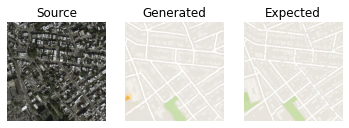

In [26]:
# example of loading a pix2pix model and using it for image to image translation
import tensorflow as tf
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
 
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()
 
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model

model = load_model('model_032880.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

Loaded (1, 256, 256, 3)


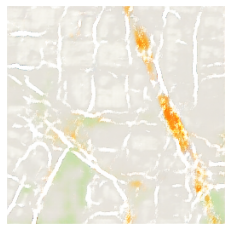

In [18]:
# example of loading a pix2pix model and using it for one-off image translation
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
 
# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels
 
# load source image
src_image = load_image('vetinh.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('model_032880.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image


pyplot.imshow(gen_image[0])
pyplot.savefig('ggmap.png')
pyplot.axis('off')
pyplot.show()

In [1]:

# Import necessary modules
import sys, os, cv2
from PyQt5.QtWidgets import (QApplication, QMainWindow, QWidget, QLabel, 
QFileDialog, QMessageBox, QHBoxLayout, QVBoxLayout, QAction)
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt
style_sheet = """
  QLabel#ImageLabel{
  color: darkgrey;
  border: 2px dashed darkgrey
  }
  QLabel{
  qproperty-alignment: AlignCenter
  }"""
class DisplayImage(QMainWindow):
 def __init__(self):
  super().__init__()
  self.initializeUI()
 def initializeUI(self):
  """Initialize the window and display its contents to the screen."""
  self.setMinimumSize(800, 500)
  self.setWindowTitle('Ex 5.1 - Displaying Images')
  self.setupWindow()
  self.setupMenu()
  self.show()
 def setupWindow(self):
  """Set up widgets in the main window."""
  # Create two QLabels, one for original image and one for displaying example from OpenCV
  original_img_header = QLabel("Original Image")
  self.original_label = QLabel()
  self.original_label.setObjectName("ImageLabel")
  opencv_img_header = QLabel(" Image Traslation")
  self.opencv_label = QLabel()
  self.opencv_label.setObjectName("ImageLabel")
  # Create horizontal and vertical layouts
  original_v_box = QVBoxLayout()
  original_v_box.addWidget(original_img_header)
  original_v_box.addWidget(self.original_label, 1)
  opencv_v_box = QVBoxLayout()
  opencv_v_box.addWidget(opencv_img_header)
  opencv_v_box.addWidget(self.opencv_label, 1)
  main_h_box = QHBoxLayout()
  main_h_box.addLayout(original_v_box, Qt.AlignCenter)
  main_h_box.addLayout(opencv_v_box, Qt.AlignCenter)
  # Create container widget and set main window's widget
  container = QWidget()
  container.setLayout(main_h_box)
  self.setCentralWidget(container)
 def setupMenu(self):
  """Simple menu bar to select local images."""
  # Create actions for file menu
  open_act = QAction('Open...', self)
  open_act.setShortcut('Ctrl+O')
  open_act.triggered.connect(self.openImageFile)
  # Create menu bar
  menu_bar = self.menuBar()
  menu_bar.setNativeMenuBar(False)
    # Create file menu and add actions
  file_menu = menu_bar.addMenu('File')
  file_menu.addAction(open_act)
 def openImageFile(self):
  """Open an image file and display the contents in the two label 
  widgets."""
  image_file, _ = QFileDialog.getOpenFileName(self, "Open Image", 
  os.getenv('HOME'), "Images (*.png *.jpeg *.jpg *.bmp)")
  if image_file:
   image = QImage() # Create QImage instance
   image.load(image_file)
   # Set the pixmap for the original_label using the QImage instance
   self.original_label.setPixmap(QPixmap.fromImage(image).scaled(
   self.original_label.width(), self.original_label.
   height(), Qt.KeepAspectRatioByExpanding))
   # Display the image that has been converted from the OpenCV Mat object to a Qt QImage
   converted_image = self.convertCVToQImage(image_file)
   self.opencv_label.setPixmap(QPixmap.fromImage(converted_image).
   scaled(
   self.opencv_label.width(), self.opencv_label.height(), 
   Qt.KeepAspectRatioByExpanding))
   self.adjustSize() # Adjust the size of the main window to better fit its contents
  else:
   QMessageBox.information(self, "Error",
      "No image was loaded.", QMessageBox.Ok)
# def convertCVToQImage(self, image_file):
#  """Demonstrates how to load a cv image and convert the image to a 
#  Qt QImage. Displays the OpenCV image for comparison. Returns the 
#  converted Qimage."""
#  cv_image = cv2.imread(image_file)
    # Demonstrate what the cv_image looks like using imshow()
#  cv2.imshow('OpenCV Image', cv_image)
#  cv2.waitKey(0) # waits for user to press any key
#  cv2.destroyAllWindows() # Close the cv window
  # Get the shape of the image, height * width * channels. BGR/RGB/HSV images have 3 channels
#  height, width, channels = cv_image.shape # Format: (rows, columns, channels)
  # Number of bytes required by the image pixels in a row; dependency on the number of channels
#  bytes_per_line = width * channels
  # Create instance of QImage using data from cv_image
#  converted_Qt_image = QImage(cv_image, width, height, bytes_per_line, QImage.Format_RGB888)
#  return converted_Qt_image
 def convertCVToQImage(self, image_file):
  """Demonstrates how to load a cv image and convert the image to a 
#  Qt QImage. Displays the OpenCV image for comparison. Returns the 
#  converted Qimage."""
  cv_image = cv2.imread(image_file)
    # Demonstrate what the cv_image looks like using imshow()
  cv2.imshow('OpenCV Image', cv_image)
  cv2.waitKey(0) # waits for user to press any key
  cv2.destroyAllWindows() # Close the cv window
  # Get the shape of the image, height * width * channels. BGR/RGB/HSV images have 3 channels
  height, width, channels = cv_image.shape # Format: (rows, columns, channels)
  # Number of bytes required by the image pixels in a row; dependency on the number of channels
  bytes_per_line = width * channels
  # Create instance of QImage using data from cv_image
  #converted_Qt_image = QImage(cv_image, width, height, bytes_per_line, QImage.Format_RGB888)
  return converted_Qt_image
if __name__ == '__main__':
 app = QApplication(sys.argv)
 app.setStyleSheet(style_sheet)
 window = DisplayImage()
 sys.exit(app.exec_())

NameError: name 'converted_Qt_image' is not defined

SystemExit: 0

C:\Users\Bich Ninh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
